In [3]:
!pip install session_info

ERROR: Could not find a version that satisfies the requirement session_info (from versions: none)
ERROR: No matching distribution found for session_info


___
---
# Zindi New User Engagement Prediction Challenge
## Time-series Binary Classification using Light Gradient Boosting


---
#### Author: Siwar Nasri

#### November 2022

---

### https://zindi.africa/competitions/zindi-new-user-engagement-prediction-challenge

## IMPORTS

In [4]:
# Standard
import os
import gc
import re
import pandas as pd
import numpy as np
import random
import time
import seaborn as sns
sns.set(font_scale=1.4)
sns.set_style('darkgrid')
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import pearsonr
from numpy.random import seed
import scipy as sc

from tqdm import tqdm 
from joblib import parallel_backend, Parallel, delayed

# Modelling
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GroupKFold ,KFold ,TimeSeriesSplit
from skmultilearn.problem_transform import BinaryRelevance
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score

# Saving
import pickle
import joblib

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 150)

def set_seed(seeed):
    seed(seeed)
    os.environ['PYTHONHASHSEED'] = str(seeed)
    np.random.seed(seeed)
    random.seed(seeed)
    
set_seed(42)

import math

In [5]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    columns = list(df.columns)

    for col in columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
#         else:
#             df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [6]:
mkdir './train'

In [7]:
mkdir './feathers'

# EXPLORATORY DATA ANALYSIS
### THE DATA

In [8]:
root = '../input/engagement-prediction/'

info = pd.read_csv(root+'VariableDefinitions.csv').drop_duplicates()
sub = pd.read_csv(root+'SampleSubmission.csv').drop_duplicates()

In [9]:
discussions = pd.read_csv(root+'Discussion.csv').drop_duplicates()
activities = pd.read_csv(root+'UserActivity.csv').drop_duplicates()
cp = pd.read_csv(root+'CompetitionPartipation.csv').drop_duplicates()
comments = pd.read_csv(root+'Comments.csv').drop_duplicates()
comps = pd.read_csv(root+'Competition.csv').drop_duplicates()
users = pd.read_csv(root+'Users.csv').drop_duplicates()

blog = pd.read_csv(root+'Blogs.csv').drop_duplicates()
job = pd.read_csv(root+'Jobs.csv').drop_duplicates()

### Train

In [10]:
train = pd.DataFrame(columns=["User_ID", "month", "year", "day"])

#### An active user is one that enters a competition, makes a submission, or engages through the discussion forums

---
#### The submission format:

In [11]:
display(sub.head(), sub.shape)

,User_ID_Next_month_Activity,Active
0,ID_4TOXNBGB_Month_5,0
1,ID_CHFTIP26_Month_5,0
2,ID_FU5GMWLQ_Month_5,0
3,ID_254TVBQP_Month_5,0
4,ID_4ENO2VFE_Month_5,0


(1340, 2)

# PREPROCESSING

#### We are provided with several datasets which can help us in finding out "how" active a user was in a particular month. First we need to clean these tables and then through the use of appropriate and intuitive feature engineering we can create features to help in predicting whether a user will be active in the next month.

In [12]:
info = info[~info['VariableDefinition'].isna()]
display(info.head())

,VariableName,VariableDefinition
1,UserID,This is the unique ID of the user who made the comment
2,CommentDate Year,The year the comment was made in. Years are in chronological order
3,CommentDate Month,The month of the year the comment was made in. Months are in chronological order but January is not neccesarily month 1.
4,CommentDate Day_of_week,The day of the week the comment was made on. Days are in chronological order but Monday is not neccesarily day 1.
7,Country,Country competition host is from or where hackathon is being hosted. This field is masked in the same way Country is masked in the User table.


In [13]:
k = 0
for i in info['VariableDefinition'].values:
    if 'merge' in i:
        print(info.iloc[k]['VariableName'], ':', i)
    k+=1

DiscID : The unique ID for each discussion, the comments table can be merged on this feature
UserID : The user who created the discussion, this can be merged with the User table on UserID
CompID : This is the ID of the competition or hackathon, this can be used to merge with the Competition Table
UserID : Unique user ID, this feature can be used to merge onto the discussion, comments and submission table


In [14]:
display(print('DISCUSSIONS'),discussions.head(1), discussions.shape) #1
display(print('COMMENTS'), comments.head(1), comments.shape)         #1
display(print('USERS'), users.head(1), users.shape)                  #1
display(print('COMPETITION PARTICIPATION'), cp.head(1), cp.shape)    #2
display(print('COMPETITIONS'), comps.head(1), comps.shape)           #2
display(print('ACTIVITIES'), activities.head(1), activities.shape)   #3
display(print('BLOGS'), blog.head(1), blog.shape)                    #1
display(print('JOBS'), job.head(1), job.shape)                       #1

DISCUSSIONS


None

,Competition ID,Personal,Theme,Disc_ID,User_ID,Created At time,Created At Year,Created At Month,Created At Day_of_month
0,GeneralDiscussion,1,NaN,ID_0BK7TH,ID_AAGFVLHH,19:48:26.862175,1,12,27


(1439, 9)

COMMENTS


None

,Disc_ID,User_ID,Created At time,Created At Year,Created At Month,Created At Day_of_month
0,ID_ONQEAR,ID_CEDNKSVV,16:18:44.841697,1,5,11


(467, 6)

USERS


None

,FeatureX,FeatureY,User_ID,Countries_ID,Created At time,Created At Year,Created At Month,Created At Day_of_month
0,0,0,ID_DC6S4E9O,X9GR,19:33:13.663391,1,1,16


(12413, 8)

COMPETITION PARTICIPATION


None

,Competition ID,Participant Type,Successful Submission Count,User_ID,Created At time,Created At Year,Created At Month,Created At Day_of_month
0,ID_WPP3,1,NaN,ID_40G01FGV,19:38:04.689865,1,11,20


(8385, 8)

COMPETITIONS


None

,FeatureA,FeatureB,FeatureC,FeatureD,FeatureE,SecretCode,FeatureF,FeatureG,FeatureH,FeatureI,Country_ID,Comp_ID,End Time time,End Time Year,End Time Month,End Time Day_of_month,Start Time time,Start Time Year,Start Time Month,Start Time Day_of_month
0,"[2, 4]",[14],15.0,0,2,1,[3],[],[],NaN,G3F0,ID_AU0T,21:05:00,2.0,6.0,19.0,07:00:00,2,6,19


(247, 20)

ACTIVITIES


None

,User_ID,Title,datetime time,datetime Year,datetime Month,datetime Day_of_month
0,ID_RT43AK77,comp_ID_IV5D,22:00:38,1,11,22


(317292, 6)

BLOGS


None

,Theme,blog_ID,Published At time,Published At Year,Published At Month,Published At Day_of_month
0,5.0,ID_Z6MM,10:34:55.071854,5,4,5


(117, 6)

JOBS


None

,Remote,Experience,Industry,Employment Type,Company Size,Data Science Functions,job_ID
0,NaN,2-5,"{Government,Health,""Financial Services""}",fulltime,50-200,"{""Data modelling"",""Business/Data Analysis""}",ID_VJ43


(34, 7)

In [15]:
for i in comps['End Time Month'].unique():
    
    if math.isnan(i):
        print(i)

nan


In [16]:
# for m in range(1,13):
#     for tab in [cp,users,comments,discussions]:
#         print(tab[["Created At Month","Created At Day_of_month"]].loc[tab["Created At Month"]==m].max())
      
#     print('\n comps')
#     print(comps[["End Time Month","End Time Day_of_month"]].loc[comps["End Time Month"]==m].max())
#     print(comps[["Start Time Month","Start Time Day_of_month"]].loc[comps["Start Time Month"]==m].max())
#     print('\n activities')
#     print(activities[['datetime Month',"datetime Day_of_month"]].loc[activities["datetime Month"]==m].max(),'\n')

In [17]:
def changing_month(month_list):
    
    from_zindi_months = {1:6,2:7,3:8,4:9,5:10,6:11,7:12,8:1,9:2,10:3,11:4,12:5}
     
    months_list = [from_zindi_months[m] if not math.isnan(m) else np.nan for m in month_list]
    
    return months_list

np.unique(changing_month(comps['End Time Month']))

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan])

In [18]:
# CHANGING MONTHS NOTATION

discussions['Created At Month'] = changing_month(discussions['Created At Month'])

comments['Created At Month'] = changing_month(comments['Created At Month'])

users['Created At Month'] = changing_month(users['Created At Month'])

cp['Created At Month'] = changing_month(cp['Created At Month'])

comps['End Time Month'] = changing_month(comps['End Time Month'])
comps['Start Time Month'] = changing_month(comps['Start Time Month'])

activities['datetime Month'] = changing_month(activities['datetime Month'])

blog['Published At Month'] = changing_month(blog['Published At Month'])

In [19]:
def max_month(list_months):
    
    list_months = list_months.fillna(0).unique()
    
    return list_months.max()

def min_month(list_months):
    
    list_months = list_months.fillna(12).unique()
    
    return list_months.min()

def max_year(list_years):
    
    list_years = list_years.fillna(0).unique()
    
    return list_years.max()

def min_year(list_years):
    
    list_years = list_years.fillna(2290).unique()
    
    return list_years.min()

def max_day(list_months):
    
    month_days = {1:31,2:28,3:31,4:30,5:31,6:30,7:31,8:31,9:30,10:31,11:30,12:31}
    
    return [month_days[month] for month in list_months]
 
max_day([2,3])

[28, 31]

In [20]:
print(discussions['Created At Year'].unique() )
print(comments['Created At Year'].unique())
print(users['Created At Year'].unique())  
print(cp['Created At Year'].unique())
print(activities['datetime Year'].unique())
print(comps['Start Time Year'].unique())
print(blog['Published At Year'].unique())

[1]
[1]
[1]
[1]
[1]
[2 3 1 4 5]
[5 4 3 2 1]


In [21]:
comps = comps[comps['Start Time Year']==1]
blog = blog[blog['Published At Year']==1]

In [22]:
# FILLING NaN TIME_DAY, TIME_MONTH AND TIME_YEAR 

# FILLING NaN YEARS MISSING VALUES 
discussions['Created At Year'] = discussions['Created At Year'].fillna(min_year(discussions['Created At Year']))

comments['Created At Year'] = comments['Created At Year'].fillna(min_year(comments['Created At Year']))

users['Created At Year'] = users['Created At Year'].fillna(min_year(users['Created At Year']))

cp['Created At Year'] = cp['Created At Year'].fillna(min_year(cp['Created At Year']))

comps['Start Time Year'] = comps['Start Time Year'].fillna(min_year(comps['Start Time Year']))
comps['End Time Year'] = comps['End Time Year'].fillna(max_year(comps['End Time Year']))

activities['datetime Year'] = activities['datetime Year'] .fillna(min_year(activities['datetime Year']))

blog['Published At Year'] = blog['Published At Year'].fillna(min_year(blog['Published At Year']))

# FILLING NaN MONTHS MISSING VALUES

discussions['Created At Month'] = discussions['Created At Month'].fillna(min_month(discussions['Created At Month']))

comments['Created At Month'] = comments['Created At Month'].fillna(min_month(comments['Created At Month']))

users['Created At Month'] = users['Created At Month'].fillna(min_month(users['Created At Month']))

cp['Created At Month'] = cp['Created At Month'].fillna(min_month(cp['Created At Month']))

comps['Start Time Month'] = comps['Start Time Month'].fillna(min_month(comps['Start Time Month']))
comps['End Time Month'] = comps['End Time Month'].fillna(max_month(comps['End Time Month']))

activities['datetime Month'] = activities['datetime Month'] .fillna(min_month(activities['datetime Month']))

blog['Published At Month'] = blog['Published At Month'].fillna(min_month(blog['Published At Month']))



# FILLING NaN DAYS MISSING VALUES 

discussions['Created At Day_of_month'] = discussions['Created At Day_of_month'].fillna(1)

comments['Created At Day_of_month'] = comments['Created At Day_of_month'].fillna(1)

users['Created At Day_of_month'] = users['Created At Day_of_month'].fillna(1)

cp['Created At Day_of_month'] = cp['Created At Day_of_month'].fillna(1)

comps['Start Time Day_of_month'] = comps['Start Time Day_of_month'].fillna(1)
max_days_by_mon = max_day(comps['End Time Month'])
comps['End Time Day_of_month'] = [m if not math.isnan(m) else max_days_by_mon[i] for i, m in enumerate(comps['End Time Day_of_month'])]

activities['datetime Day_of_month'] = activities['datetime Day_of_month'].fillna(1)

blog['Published At Day_of_month'] = blog['Published At Day_of_month'].fillna(1)

# FILLING NaN CONTRIES VALUES
comps.Country_ID = comps.Country_ID.fillna('entire_world')
users.Countries_ID = users.Countries_ID.fillna('entire_world')

In [23]:
# CLEAN THE COLUMN NAMES
discussions.columns = discussions.columns.str.replace(' ', '_')
comments.columns = comments.columns.str.replace(' ', '_')
users.columns = users.columns.str.replace(' ', '_')
cp.columns = cp.columns.str.replace(' ', '_')
comps.columns = comps.columns.str.replace(' ', '_')
activities.columns = activities.columns.str.replace(' ', '_')
blog.columns = blog.columns.str.replace(' ', '_')
job.columns = job.columns.str.replace(' ', '_')

# DROP UNNAICESSARY COLUMNS 
discussions = discussions.drop(['Created_At_time'], 1)
activities = activities.drop(['datetime_time'], 1)
cp = cp.drop(['Created_At_time'], 1)
comments = comments.drop(['Created_At_time'], 1)
comps = comps.drop(['Start_Time_time', 'End_Time_time'], 1)
users = users.drop(['Created_At_time'], 1)
blog = blog.drop(['Published_At_time'], 1)

"""# 1 HOT ENCODE CATORGORICAL COLUMNS FROM USER AND COMPS DF
users = pd.get_dummies(users, columns=['FeatureY', 'FeatureX'], drop_first=False)
comps = pd.get_dummies(comps, columns=['FeatureE', 'FeatureD', 'FeatureC', 'FeatureI', 'Country_ID', 'SecretCode'], drop_first=False)
"""
# CLEAN COMPETITION PARTICIPATION COLUMNS AND 1 HOT ENCODE
cp = cp.drop(columns="Participant_Type")
cp['Successful_Submission_Count'] = cp['Successful_Submission_Count'].str.replace('count ', '')
cp['Sub'] = pd.isna(cp["Successful_Submission_Count"]).replace({True:False, False:True})*1
cp = pd.get_dummies(cp, columns = ['Successful_Submission_Count'], drop_first=False) 

# THE DATA IN FEATURE COLUMNS IN OUR COMPS TABLE ARE IN LISTS, INDICATING WHICH CATORGORIES THE COMP FALLS INTO
## LETS CREATE SOME NEW FEATURES FROM EACH FEATURE COLUMNS VALUES IN THE LISTS
# FIRST REMOVE LIST BRACKETS SO WE ARE LEFT WITH COMMA SEPARATED VALUES
comps['FeatureA'] =  comps['FeatureA'].apply(lambda x:re.sub(r'\[|\]', '', x))
comps['FeatureB'] =  comps['FeatureB'].apply(lambda x:re.sub(r'\[|\]', '', x))
comps['FeatureF'] =  comps['FeatureF'].apply(lambda x:re.sub(r'\[|\]', '', x))
comps['FeatureG'] =  comps['FeatureG'].apply(lambda x:re.sub(r'\[|\]', '', x))
comps['FeatureH'] =  comps['FeatureH'].apply(lambda x:re.sub(r'\[|\]', '', x))

# CREATE DATAFRAME OF COLUMNS INDICATING WHETHER A VALUE IS PRESENT IN THE FEATURE COLUMN FOR EACH COMPID
feature_A = comps.set_index('Comp_ID').FeatureA.str.split(', ') \
            .apply(pd.value_counts).fillna(0).astype(int).reset_index(drop=True)
feature_B = comps.set_index('Comp_ID').FeatureB.str.split(', ') \
            .apply(pd.value_counts).fillna(0).astype(int).reset_index(drop=True)
feature_F = comps.set_index('Comp_ID').FeatureF.str.split(', ') \
            .apply(pd.value_counts).fillna(0).astype(int).reset_index(drop=True)
feature_G = comps.set_index('Comp_ID').FeatureG.str.split(', ') \
            .apply(pd.value_counts).fillna(0).astype(int).reset_index(drop=True)
feature_H = comps.set_index('Comp_ID').FeatureH.str.split(', ') \
            .apply(pd.value_counts).fillna(0).astype(int).reset_index(drop=True)

# RENAME THE COLUMNS OF CREATED DATAFRAMES
for col in feature_A.columns:
    feature_A.rename(columns={col:'feature_A_'+col}, inplace=True)
for col in feature_B.columns:
    feature_B.rename(columns={col:'feature_B_'+col}, inplace=True)
for col in feature_F.columns:
    feature_F.rename(columns={col:'feature_F_'+col}, inplace=True)
for col in feature_G.columns:
    feature_G.rename(columns={col:'feature_G_'+col}, inplace=True)
for col in feature_H.columns:
    feature_H.rename(columns={col:'feature_H_'+col}, inplace=True)

# CONCAT THE CLEAN DATAFRAMES ON COMPS TABLE AND DROP THE ORIGINAL FEATURE
comps = pd.concat([comps, feature_A, feature_B, feature_F, feature_G, feature_H], axis=1).drop(['FeatureA', 'FeatureB', 'FeatureF', 'FeatureG', 'FeatureH'],1)

### ALL THE DATASETS

In [24]:
display(print('DISCUSSIONS'),discussions.head(1), discussions.shape) #1
display(print('COMMENTS'), comments.head(1), comments.shape)         #1
display(print('USERS'), users.head(1), users.shape)                  #1
display(print('COMPETITION PARTICIPATION'), cp.head(1), cp.shape)    #2
display(print('COMPETITIONS'), comps.head(1), comps.shape)           #2
display(print('ACTIVITIES'), activities.head(1), activities.shape)#3
display(print('BLOGS'),blog.head(1), blog.shape)                     #1
display(print('JOBS'), job.head(1), job.shape)                       #1

DISCUSSIONS


None

,Competition_ID,Personal,Theme,Disc_ID,User_ID,Created_At_Year,Created_At_Month,Created_At_Day_of_month
0,GeneralDiscussion,1,NaN,ID_0BK7TH,ID_AAGFVLHH,1,5,27


(1439, 8)

COMMENTS


None

,Disc_ID,User_ID,Created_At_Year,Created_At_Month,Created_At_Day_of_month
0,ID_ONQEAR,ID_CEDNKSVV,1,10,11


(467, 5)

USERS


None

,FeatureX,FeatureY,User_ID,Countries_ID,Created_At_Year,Created_At_Month,Created_At_Day_of_month
0,0,0,ID_DC6S4E9O,X9GR,1,6,16


(12413, 7)

COMPETITION PARTICIPATION


None

,Competition_ID,User_ID,Created_At_Year,Created_At_Month,Created_At_Day_of_month,Sub,Successful_Submission_Count_10,Successful_Submission_Count_3,Successful_Submission_Count_4,Successful_Submission_Count_5,Successful_Submission_Count_6,Successful_Submission_Count_7,Successful_Submission_Count_8,Successful_Submission_Count_9
0,ID_WPP3,ID_40G01FGV,1,4,20,0,0,0,0,0,0,0,0,0


(8385, 14)

COMPETITIONS


None

,FeatureC,FeatureD,FeatureE,SecretCode,FeatureI,Country_ID,Comp_ID,End_Time_Year,End_Time_Month,End_Time_Day_of_month,Start_Time_Year,Start_Time_Month,Start_Time_Day_of_month,feature_A_,feature_A_1,feature_A_2,feature_A_5,feature_A_7,feature_A_4,feature_A_3,feature_A_6,feature_B_,feature_B_5,feature_B_7,feature_B_15,feature_B_2,feature_B_6,feature_B_16,feature_B_9,feature_B_1,feature_B_12,feature_B_14,feature_F_1,feature_F_7,feature_F_2,feature_F_8,feature_F_,feature_F_9,feature_F_10,feature_F_6,feature_F_3,feature_F_12,feature_F_5,feature_F_11,feature_F_14,feature_F_15,feature_G_3,feature_G_5,feature_G_4,feature_G_,feature_H_,feature_H_7,feature_H_1,feature_H_2,feature_H_8,feature_H_3,feature_H_9,feature_H_10,feature_H_6,feature_H_11
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


(136, 60)

ACTIVITIES


None

,User_ID,Title,datetime_Year,datetime_Month,datetime_Day_of_month
0,ID_RT43AK77,comp_ID_IV5D,1,4,22


(317292, 5)

BLOGS


None

,Theme,blog_ID,Published_At_Year,Published_At_Month,Published_At_Day_of_month
89,1.0,ID_Q2AQ,1,1,6


(28, 5)

JOBS


None

,Remote,Experience,Industry,Employment_Type,Company_Size,Data_Science_Functions,job_ID
0,NaN,2-5,"{Government,Health,""Financial Services""}",fulltime,50-200,"{""Data modelling"",""Business/Data Analysis""}",ID_VJ43


(34, 7)

#### If a UserID is present in the DISCUSSIONS, COMMENTS, COMPETITION PARTICIPATION, or ACTIVITIES table in a particular month, then the Target in that particular month should be 1 for the UserID in the train df.

In [25]:
def fix_incorrect_target_labels(train):

    check1 = train[train['Comment']==1]['User_ID'].unique()
    print(len(check1))
    check2 = comments[comments['User_ID'].isin(check1)]['User_ID'].unique()
    print(len(check2))
    
    # TO BE CORRECTED USERIDS FOR COMMENTS TABLE
    tbc = list(set(check1) - set(check2))
    print(len(tbc))

    for userid in tbc:
        train.loc[train['User_ID']==userid, 'Comment'] = 0

    check1 = train[train['Comment']==1]['User_ID'].unique()
    print(len(check1))
    check2 = comments[comments['User_ID'].isin(check1)]['User_ID'].unique()
    print(len(check2))
    
    # SHOULD BE CORRECTED NOW: LETS CHECK
    tbc = list(set(check1) - set(check2))
    print(len(tbc))
    
    check1 = train[train['CompPart']==1]['User_ID'].unique()
    print(len(check1))
    check2 = cp[cp['User_ID'].isin(check1)]['User_ID'].unique()
    print(len(check2))
    tbc = list(set(check1) - set(check2))
    print(len(tbc))

    for userid in tbc:
        train.loc[train['User_ID']==userid, 'CompPart'] = 0

    check1 = train[train['CompPart']==1]['User_ID'].unique()
    print(len(check1))
    check2 = cp[cp['User_ID'].isin(check1)]['User_ID'].unique()
    print(len(check2))
    tbc = list(set(check1) - set(check2))
    print(len(tbc))

    train['Target'] = train['CompPart'] + train['Comment'] ####+ train['Sub'] #### + train['Disc']
    train.loc[train['Target']>0, 'Target'] = 1
    return train

---
---
# FEATURE ENGINEERING

### Using Competition Participation data and Competition data

In [26]:
cp = cp.rename(columns={"Competition_ID":"Comp_ID"})

In [27]:
user_comps = cp.merge(comps, on='Comp_ID', how='left')
display(user_comps.head(), user_comps.shape) 

,Comp_ID,User_ID,Created_At_Year,Created_At_Month,Created_At_Day_of_month,Sub,Successful_Submission_Count_10,Successful_Submission_Count_3,Successful_Submission_Count_4,Successful_Submission_Count_5,Successful_Submission_Count_6,Successful_Submission_Count_7,Successful_Submission_Count_8,Successful_Submission_Count_9,FeatureC,FeatureD,FeatureE,SecretCode,FeatureI,Country_ID,End_Time_Year,End_Time_Month,End_Time_Day_of_month,Start_Time_Year,Start_Time_Month,Start_Time_Day_of_month,feature_A_,feature_A_1,feature_A_2,feature_A_5,feature_A_7,feature_A_4,feature_A_3,feature_A_6,feature_B_,feature_B_5,feature_B_7,feature_B_15,feature_B_2,feature_B_6,feature_B_16,feature_B_9,feature_B_1,feature_B_12,feature_B_14,feature_F_1,feature_F_7,feature_F_2,feature_F_8,feature_F_,feature_F_9,feature_F_10,feature_F_6,feature_F_3,feature_F_12,feature_F_5,feature_F_11,feature_F_14,feature_F_15,feature_G_3,feature_G_5,feature_G_4,feature_G_,feature_H_,feature_H_7,feature_H_1,feature_H_2,feature_H_8,feature_H_3,feature_H_9,feature_H_10,feature_H_6,feature_H_11
0,ID_WPP3,ID_40G01FGV,1,4,20,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ID_ZN92,ID_40G01FGV,1,4,20,0,0,0,0,0,0,0,0,0,NaN,1.0,1.0,0.0,NaN,entire_world,1.0,5.0,1.0,1.0,2.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ID_I9BN,ID_40G01FGV,1,5,17,0,0,0,0,0,0,0,0,0,NaN,1.0,1.0,0.0,10.0,03GB,1.0,8.0,14.0,1.0,5.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ID_PDKH,ID_40G01FGV,1,5,6,1,1,0,0,0,0,0,0,0,10.0,1.0,2.0,0.0,10.0,G3F0,1.0,7.0,23.0,1.0,4.0,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ID_CFN7,ID_P33ABQX5,1,10,26,0,0,0,0,0,0,0,0,0,NaN,1.0,2.0,0.0,NaN,entire_world,2023.0,2.0,12.0,1.0,10.0,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(8385, 73)

In [28]:
# CREATE EMPTY DATAFRAME TO STORE AGGREGATIONS
user_comps_agg = pd.DataFrame()
# CREATE GROUBY OBJECT FOR THE MONTH AND YEAR THE A USER PARTICIPATED IN A COMP
uc_groupby = user_comps[['User_ID','Comp_ID', 'Created_At_Year', 'Created_At_Month', 'Created_At_Day_of_month', 'Sub']].groupby(['User_ID','Comp_ID', 'Created_At_Year', 'Created_At_Month', 'Created_At_Day_of_month'])

In [29]:
# SUM ALL THESE FEATURES FOR A USER BY DAY MONTH YEAR AND ADD TO AGG DF
user_comps_agg['Sub_sum'] = uc_groupby.agg({'Sub':np.sum})

In [30]:
# FIND OUT HOW MANY COMPS A USER JOINED DURING EACH MONTH
user_comps_agg['count_users_by_comp'] = uc_groupby.agg({'User_ID':pd.Series.count})
user_comps_agg = user_comps_agg.reset_index()
# RENAME COLUMNS FOR EASY MERGE WITH TRAIN COLUMNS
user_comps_agg.rename(columns={'Created_At_Month':'month', 'Created_At_Year':'year', 'Created_At_Day_of_month':'day'}, inplace=True)
user_comps_agg.set_index(['User_ID', 'month', 'year', 'day'], inplace=True)
display(user_comps_agg.head(3), user_comps_agg.shape)

Comp_ID  Sub_sum  count_users_by_comp
User_ID     month year day                                       
ID_011YM9VH 8     1    9    ID_F7QD        0                    1
            7     1    27   ID_GAV9        0                    1
ID_015M2NE1 5     1    27   ID_8SHD        0                    1

(8385, 3)

---
### Using Activities data

In [31]:
display(activities.sample(3))

,User_ID,Title,datetime_Year,datetime_Month,datetime_Day_of_month
76738,ID_SUMPZG2P,Confirmed Email,1,6,3
244954,ID_KPIZKQIN,Viewed All Learning Pages,1,8,9
148596,ID_SHK0G9UL,Confirmed Email,1,6,13


#### Using the activities data we can create a feature that represents how frequently a user makes activities per month per comp by considering the difference in time between submission days of the week.

In [32]:
def diff(df):
    """
    Function to calculate circular difference between two days of the month where each day is
    consecutive and labeled from 1 - 30.
    
    eg. The mathematical difference between 30 and 1 is 29 but the the circular difference 
        between day 30 and day 1 is 1. 
    
    input:   df[['day of month', 'day of month shitfed']]
    returns: series with circular differenece along axis 1.
    """
    min_ = df.min(axis=1).reset_index(drop=True)
    max_ = df.max(axis=1).reset_index(drop=True)
    diff = max_ - min_
    d = diff.where(diff<=4, abs(30 - max_))
    return d.reset_index(drop=True)

In [33]:
np.unique([a.split('_ID_')[0]+'_ID' if '_ID_' in a else np.nan for a in activities.Title])

#['ID_'+a.split('_ID_')[1] if '_ID_' in a else np.nan for a in activities.Title] 

array(['blog_ID', 'comp_ID', 'job_ID', 'nan'], dtype='<U7')

In [34]:
activities['Comp_ID'] = ['ID_'+a.split('_ID_')[1] if 'comp_ID' in a else np.nan for a in activities.Title] 
activities['Blog_ID'] = ['ID_'+a.split('_ID_')[1] if 'blog_ID' in a else np.nan for a in activities.Title]

In [35]:
# CREATE EMPTY DATARFRAME TO STORE AGGREGATED DATA
activities_agg = pd.DataFrame()
# CREATE GROUBY OBJECT FOR THE MONTH AND YEAR A USER SUMMITED TO A COMP
subs_groupby = activities.groupby(['User_ID','Title','datetime_Year','datetime_Month', 'datetime_Day_of_month'])
            
for col in activities.columns:
    for i in ['sub_time_diff']: #['datetime_Day_of_month', 'FeatureG', 'sub_time_diff']:
        if i in col:
            # MEAN VALUES FOR COLUMNS PER COMP IN A MONTH
            activities_agg[col + '_mean'] = subs_groupby.agg({col:np.mean})
    
# NUMBER OF SUBS TO COMP IN A MONTH PER USER
activities_agg['count_subs'] = subs_groupby.agg({'User_ID':pd.Series.count})
activities_agg['count_comps'] = subs_groupby.agg({'Comp_ID':pd.Series.count})
activities_agg['count_blogs'] = subs_groupby.agg({'Blog_ID':pd.Series.count})
activities_agg = activities_agg.reset_index()

In [36]:
# NUMBER OF COMPS A USER MADE ACTIVITIES TO
activities_actions = pd.DataFrame([])
activities_actions['count_comps_sub'] = activities_agg.groupby(['User_ID','datetime_Year','datetime_Month', 'datetime_Day_of_month'])['User_ID'].count()
activities_agg = activities_agg.merge(activities_actions, on =['User_ID','datetime_Year','datetime_Month', 'datetime_Day_of_month'])
activities_agg = activities_agg.drop(['Title'], 1)

In [37]:
# SUM VALUES FOR COLUMNS IN A DAY (COMBINE INFO FROM ACTIVITIES)
# TOTAL NUMBER OF SUBS MADE TO COMPS IN A DAY
for col in ['count_subs', 'count_comps', 'count_blogs']: #['datetime_Day_of_month_mean', 'sub_time_diff_mean']:
  
    activities_agg[col+'_sum'] = activities_agg.groupby(['User_ID', 
                                                    'datetime_Year',
                                                    'datetime_Month',
                                                    'datetime_Day_of_month'])[col].transform('sum')

# RENAME COLUMNS FOR EASY MERGE WITH TRAIN DF
activities_agg.rename(columns={'datetime_Month':'month', 'datetime_Year':'year', 'datetime_Day_of_month':'day'}, inplace=True)

In [38]:
# DROP COMPID AS IT IS NO LONGER REQUIRED
##### activities_agg = activities_agg.drop(['Comp_ID'],1).drop_duplicates().set_index(['User_ID', 'month', 'year'])
        
activities_agg = activities_agg.drop_duplicates()
 
activities_agg = activities_agg.set_index(['User_ID', 'month', 'year','day'])

display(activities_agg.sample(3))

,,,,count_subs,count_comps,count_blogs,count_comps_sub,count_subs_sum,count_comps_sum,count_blogs_sum
User_ID,month,year,day,,,,,,,
ID_XWWBUX9G,10,1,5,2,0,0,8,10,2,0
ID_H1CTSY8S,6,1,1,1,1,0,4,4,1,0
ID_SMQQSJ0P,10,1,17,1,0,0,8,29,3,1


---

In [39]:
train = train.set_index(['User_ID', 'month', 'year','day'])
print(train.shape)

(0, 0)


### MERGE AGGREGATED DATA FROM ACTIVITIES AND COMPETITION PARTICIPATION TABLES ONTO TRAIN DF

In [40]:
user_comps_agg.sample()

,,,,Comp_ID,Sub_sum,count_users_by_comp
User_ID,month,year,day,,,
ID_41FIO5Y8,9,1,27,ID_BARV,0,1


In [41]:
activities_agg.sample()

,,,,count_subs,count_comps,count_blogs,count_comps_sub,count_subs_sum,count_comps_sum,count_blogs_sum
User_ID,month,year,day,,,,,,,
ID_UM819Q34,7,1,15,2,0,0,11,52,4,0


In [42]:
train = train.merge(activities_agg, left_index=True, right_index=True, how='outer') #how='left'
train = train.merge(user_comps_agg, left_index=True, right_index=True, how='outer') #how='left'

train = train.reset_index()
train = train.sort_values(['year','month', 'day'])

print('\n\n NEW TRAIN DATAFRAME: \n')
display(train)



 NEW TRAIN DATAFRAME: 



,User_ID,month,year,day,count_subs,count_comps,count_blogs,count_comps_sub,count_subs_sum,count_comps_sum,count_blogs_sum,Comp_ID,Sub_sum,count_users_by_comp
846,ID_0B7198UX,4,1,1,1.0,0.0,0.0,2.0,2.0,0.0,0.0,NaN,NaN,NaN
1373,ID_0JQTGLPB,4,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ID_CR6P,0.0,1.0
1508,ID_0LEMS0F7,4,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ID_E1KX,0.0,1.0
2405,ID_0W3L4Z8R,4,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ID_9BU8,0.0,1.0
7378,ID_340JJ7SU,4,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ID_AL6C,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80874,ID_XZS1QE0W,10,1,27,3.0,0.0,0.0,7.0,9.0,0.0,0.0,NaN,NaN,NaN
81002,ID_Y0RTEBIN,10,1,27,1.0,0.0,0.0,7.0,8.0,0.0,0.0,NaN,NaN,NaN
81003,ID_Y0RTEBIN,10,1,27,2.0,0.0,0.0,7.0,8.0,0.0,0.0,NaN,NaN,NaN
85179,ID_ZYK49EEF,10,1,27,1.0,0.0,0.0,8.0,8.0,0.0,0.0,NaN,NaN,NaN


---
### Using Comments and Discussion dataframes

In [43]:
# RENAME COLUMNS FOR EASY MERGE
discussions.drop(columns=(['Competition_ID']), inplace=True)
discussions.sample()

,Personal,Theme,Disc_ID,User_ID,Created_At_Year,Created_At_Month,Created_At_Day_of_month
1255,1,NaN,ID_61CPLS,ID_URYOXTAI,1,5,27


In [44]:
comments = comments.merge(discussions, on = ['Disc_ID', 'User_ID', 'Created_At_Year', 'Created_At_Month',
       'Created_At_Day_of_month'], how ='outer')

In [45]:
# RENAME COLUMNS FOR EASY MERGE WITH TRAIN DF
comments.rename(columns={'Created_At_Year': 'year', 
                         'Created_At_Month': 'month',
                         'Created_At_Day_of_month': 'day'}, inplace=True)

In [46]:
# FIND NUMBER OF COMMENTS MADE BY USERS IN A MONTH
comments['count_comments'] = comments.groupby(['User_ID', 'year', 'month', 'day'])['User_ID'].transform('count')
# GET THE MEAN DAY OF WEEK EACH USER MADE A COMMENT ON
"""comments['CommentDate_Day_of_month'] = comments.groupby(['User_ID', 'year', 'month'])['Created_At_Day_of_month'].\
                                                                                     transform('mean')
"""
comments["Disc"] = pd.isna(comments["Disc_ID"]).replace({True:False, False:True})*1
comments.drop(columns=["Disc_ID"], inplace=True)
comments = comments.drop_duplicates()
display(comments)

,User_ID,year,month,day,Personal,Theme,count_comments,Disc
0,ID_CEDNKSVV,1,10,11,NaN,NaN,1,1
1,ID_CEDNKSVV,1,5,23,0.0,4.0,2,1
2,ID_CEDNKSVV,1,6,3,0.0,1.0,3,1
3,ID_CEDNKSVV,1,6,5,NaN,NaN,1,1
4,ID_CEDNKSVV,1,5,19,0.0,1.0,2,1
...,...,...,...,...,...,...,...,...
1861,ID_AAJKI0P3,1,10,23,1.0,NaN,2,1
1863,ID_8A3X5IWU,1,10,14,1.0,NaN,1,1
1864,ID_3NL0QLE6,1,10,12,1.0,NaN,1,1
1865,ID_3PL1LQQX,1,10,9,1.0,NaN,1,1


In [47]:
from collections import Counter
Counter(comments.count_comments)

Counter({1: 1196,
         2: 226,
         3: 74,
         6: 7,
         4: 23,
         8: 3,
         9: 1,
         5: 10,
         12: 1,
         11: 1,
         10: 2,
         7: 2})

### MERGE AGGREGATED DATA FROM COMMENTS TABLE ONTO TRAIN DF  

In [48]:
train = train.merge(comments, on = ['User_ID', 'year', 'month', 'day'], how='outer')
display(train.sample(3))

,User_ID,month,year,day,count_subs,count_comps,count_blogs,count_comps_sub,count_subs_sum,count_comps_sum,count_blogs_sum,Comp_ID,Sub_sum,count_users_by_comp,Personal,Theme,count_comments,Disc
21521,ID_GT7RNC09,6,1,12,3.0,0.0,0.0,5.0,20.0,3.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68008,ID_WL23F4VO,9,1,13,2.0,0.0,0.0,13.0,25.0,5.0,0.0,ID_KU2G,0.0,1.0,NaN,NaN,NaN,NaN
68589,ID_HBUJVJKY,9,1,15,2.0,0.0,0.0,12.0,29.0,4.0,0.0,ID_2MIC,1.0,1.0,NaN,NaN,NaN,NaN


### MERGE USER INFO FROM USERS TABLE ONTO TRAIN DF

In [49]:
# RENAME COLUMNS FOR EASY MERGE WITH TRAIN DF
users.rename(columns={'Created_At_Year': 'year', 
                         'Created_At_Month': 'month',
                         'Created_At_Day_of_month': 'day'}, inplace=True)

In [50]:
train = train.merge(users, on=['User_ID','year','month','day'], how='outer')
display(train.head(2))

,User_ID,month,year,day,count_subs,count_comps,count_blogs,count_comps_sub,count_subs_sum,count_comps_sum,count_blogs_sum,Comp_ID,Sub_sum,count_users_by_comp,Personal,Theme,count_comments,Disc,FeatureX,FeatureY,Countries_ID
0,ID_0B7198UX,4,1,1,1.0,0.0,0.0,2.0,2.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,X9GR
1,ID_0JQTGLPB,4,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ID_CR6P,0.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,8CE7


---

In [51]:
# SORT
train = train.sort_values(['User_ID','year','month','day'])

---
## MORE FEATURE ENGINEERING


### Getting data on the latest competition a user participated in

In [52]:
# SUBSET THE COMPETETION PARTICIPATION DATAFRAME FOR THE LAST COMP A USER JOINED PER MONTH
cp = cp.sort_values(['User_ID', 'Created_At_Year', 
                     'Created_At_Month', 
                     'Created_At_Day_of_month']).drop_duplicates(subset=
                                                                     ['User_ID', 'Created_At_Year', 
                                                                      'Created_At_Month','Created_At_Day_of_month'], keep='last')

display(cp.sample(3))

,Comp_ID,User_ID,Created_At_Year,Created_At_Month,Created_At_Day_of_month,Sub,Successful_Submission_Count_10,Successful_Submission_Count_3,Successful_Submission_Count_4,Successful_Submission_Count_5,Successful_Submission_Count_6,Successful_Submission_Count_7,Successful_Submission_Count_8,Successful_Submission_Count_9
1053,ID_KU2G,ID_7WARCS06,1,8,27,1,0,0,1,0,0,0,0,0
2180,ID_PB3Q,ID_C6OAJCMJ,1,10,6,0,0,0,0,0,0,0,0,0
2172,ID_Y4Y2,ID_XU8191ZC,1,8,20,0,0,0,0,0,0,0,0,0


In [53]:
# MERGE WITH COMPS INFO TABLE
latest_cp = pd.merge(cp, comps, on='Comp_ID', how='outer')

# DO VERY MINIMAL FEATURE SELECTION 
cols = ['User_ID', 'Sub', 'Created_At_Month', 'Created_At_Year','Created_At_Day_of_month'] + [c for c in latest_cp.columns if 'Comp' in c] + \
       [c for c in latest_cp.columns if 'Feature' in c] + [c for c in latest_cp.columns if 'feature' in c]
latest_cp = latest_cp[cols]
 
latest_cp.rename(columns={'Created_At_Month':'month', 'Created_At_Year':'year', 'Created_At_Day_of_month':'day'}, inplace=True)
display(latest_cp.head(), latest_cp.shape)

,User_ID,Sub,month,year,day,Comp_ID,FeatureC,FeatureD,FeatureE,FeatureI,feature_A_,feature_A_1,feature_A_2,feature_A_5,feature_A_7,feature_A_4,feature_A_3,feature_A_6,feature_B_,feature_B_5,feature_B_7,feature_B_15,feature_B_2,feature_B_6,feature_B_16,feature_B_9,feature_B_1,feature_B_12,feature_B_14,feature_F_1,feature_F_7,feature_F_2,feature_F_8,feature_F_,feature_F_9,feature_F_10,feature_F_6,feature_F_3,feature_F_12,feature_F_5,feature_F_11,feature_F_14,feature_F_15,feature_G_3,feature_G_5,feature_G_4,feature_G_,feature_H_,feature_H_7,feature_H_1,feature_H_2,feature_H_8,feature_H_3,feature_H_9,feature_H_10,feature_H_6,feature_H_11
0,ID_011YM9VH,0.0,7.0,1.0,27.0,ID_GAV9,2.0,0.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ID_03CFOV9J,0.0,7.0,1.0,25.0,ID_GAV9,2.0,0.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ID_03IZAONO,0.0,8.0,1.0,4.0,ID_GAV9,2.0,0.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ID_06EVBQZD,0.0,7.0,1.0,27.0,ID_GAV9,2.0,0.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ID_06K3WW7Z,0.0,8.0,1.0,4.0,ID_GAV9,2.0,0.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(6816, 57)

#### USING MERGE ASOF TO MERGE COMP INFO WITH TRAIN BY USER ID AND DATE

In [54]:
cp[["Created_At_Month", "Created_At_Day_of_month"]].loc[cp["Created_At_Day_of_month"]==30].Created_At_Month.unique()

array([6, 7, 5, 8, 9, 4])

In [55]:
cp[["Created_At_Month", "Created_At_Day_of_month"]].loc[cp["Created_At_Month"]==7]

,Created_At_Month,Created_At_Day_of_month
3284,7,27
6152,7,25
1197,7,21
1198,7,23
1201,7,27
...,...,...
614,7,6
1211,7,23
2199,7,6
2973,7,30


In [56]:
latest_cp = latest_cp.dropna() 

In [57]:
# FOR MERGING ONTO THE TRAIN DF WE WILL CREATE A DATE COLUMN BY MAPPING A MONTH AND YEAR NAME TO EACH MONTH,YEAR
"""year_dict = {1:2015,2:2016,3:2017,4:2018}
month_dict = {8:'January',9:'February',10:'March',11:'April',12:'May',1:'June', 2:'July',3:'August',4:'September', 5:'October', 6:'November', 7:'December'}
"""

year_dict = {1:2020,2:2021,3:2022,4:2023,5:2023,2023:2023}
month_dict = {1:'January',2:'February',3:'March',4:'April',5:'May',6:'June', 7:'July',8:'August',9:'September', 10:'October', 11:'November', 12:'December'}

train['date_year'] = train['year'].map(year_dict)
train['date_month'] = train['month'].map(month_dict)

latest_cp['date_year'] = latest_cp['year'].map(year_dict)
latest_cp['date_month'] = latest_cp['month'].map(month_dict)

In [58]:
# CONVERT THE DATE COLUMN TO DATETIME

train['date'] = pd.to_datetime(train['date_year'].astype(str)  + train['date_month']  + train['day'].astype(str), format='%Y%B%d')

latest_cp['date'] = pd.to_datetime(latest_cp['date_year'].astype(str)  + latest_cp['date_month']  + train['day'].astype(str), format='%Y%B%d')
latest_cp = latest_cp.drop(['year', 'month', 'date_year', 'date_month', 'day'], 1)

# SORT BY DATE
latest_cp = latest_cp.sort_values('date')
train = train.sort_values('date')

### MERGE LATEST COMP DATA TO TRAIN DF USING pd.merge_asof

In [59]:
train = pd.merge_asof(train, latest_cp, by=['User_ID','Comp_ID'], on='date')
# train = train.drop(['date', 'date_year', 'date_month'],1)
# train = train.sort_values(['User_ID','year','month','day'])

train = train.drop(['date_year', 'date_month'],1)
train = train.sort_values(['User_ID','date'])

---
### CREATING CUMSUM FEATURES 

#### We can create cumsum features to capture the users activity over time. We will select some features from the train dataframe based on how many unique values are present in the column and create cumsum features using these columns.

In [60]:
# CREATE EMPTY DATAFRAME
nunique_df = pd.DataFrame()

# FILL THE DATAFRAME WITH NUMBER OF UNIQUE FEATURES FOR EACH COLUMN IN TRAIN DF
features = [c for c in train.columns if c not in ['User_ID', 'date']]
for col in features:
    nunique_df[col] = [train[col].nunique()]

nunique_df = nunique_df.T.reset_index()
nunique_df.rename(columns={0:'n_unique', 'index':'feature'}, inplace=True)
nunique_df = nunique_df.sort_values('n_unique')
display(nunique_df)

,feature,n_unique
35,feature_B_7,1
33,feature_B_,1
34,feature_B_5,1
70,feature_H_6,1
37,feature_B_2,1
...,...,...
8,count_comps_sum,65
3,count_subs,74
10,Comp_ID,131
7,count_subs_sum,132


In [61]:
%%time
# SELECT COLUMNS
ccols = nunique_df[nunique_df['n_unique']>=18]['feature'].tolist()+['CompPart', 'Comment', 'Sub', 'Disc','Target']
"""
# CREATE CUMSUM FEATURES FROM SELECTED COLUMNS
for col in tqdm(ccols):
    train[f'{col}_cumsum'] = train.groupby('User_ID')[col].cumsum()"""

CPU times: user 1.09 ms, sys: 7 µs, total: 1.1 ms
Wall time: 1.06 ms


"\n# CREATE CUMSUM FEATURES FROM SELECTED COLUMNS\nfor col in tqdm(ccols):\n    train[f'{col}_cumsum'] = train.groupby('User_ID')[col].cumsum()"

---

#### DEALING WITH NaNs and inf VALUES BY FORWARD FILLING

In [62]:
%%time
# REPLACE INFINITE VALUES
train = train.replace([np.inf, -np.inf], np.nan)
# FILL NaNs BY FORWARD FILLING COLUMNS
train = train.groupby('User_ID').apply(lambda x: pd.DataFrame.ffill(x))

CPU times: user 14.4 s, sys: 467 ms, total: 14.9 s
Wall time: 14.9 s


---

---

#### STANDARDISE SOME CUMSUM FEATURES BY DIVIDING BY MONTHS SINCE A USER JOINED ZINDI

In [63]:
train['cumcount'] = train.groupby(['User_ID']).cumcount()
train['cumcount'] = train['cumcount']+1

In [64]:
del train['cumcount']
gc.collect()

46

---
#### NEW TRAIN DATAFRAME

In [65]:
display(train.sample(3))

,User_ID,month,year,day,count_subs,count_comps,count_blogs,count_comps_sub,count_subs_sum,count_comps_sum,count_blogs_sum,Comp_ID,Sub_sum,count_users_by_comp,Personal,Theme,count_comments,Disc,FeatureX,FeatureY,Countries_ID,date,Sub,FeatureC,FeatureD,FeatureE,FeatureI,feature_A_,feature_A_1,feature_A_2,feature_A_5,feature_A_7,feature_A_4,feature_A_3,feature_A_6,feature_B_,feature_B_5,feature_B_7,feature_B_15,feature_B_2,feature_B_6,feature_B_16,feature_B_9,feature_B_1,feature_B_12,feature_B_14,feature_F_1,feature_F_7,feature_F_2,feature_F_8,feature_F_,feature_F_9,feature_F_10,feature_F_6,feature_F_3,feature_F_12,feature_F_5,feature_F_11,feature_F_14,feature_F_15,feature_G_3,feature_G_5,feature_G_4,feature_G_,feature_H_,feature_H_7,feature_H_1,feature_H_2,feature_H_8,feature_H_3,feature_H_9,feature_H_10,feature_H_6,feature_H_11
26667,ID_YMMSHAJY,6,1,16,2.0,2.0,0.0,16.0,23.0,8.0,0.0,ID_VGMZ,0.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,ZEWU,2020-06-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68415,ID_8PYX9ZJH,9,1,11,1.0,1.0,0.0,9.0,24.0,12.0,0.0,ID_WZ0H,0.0,1.0,1.0,NaN,1.0,1.0,0.0,0.0,entire_world,2020-09-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32689,ID_W28YK1UB,6,1,29,2.0,0.0,0.0,4.0,9.0,1.0,0.0,ID_UILN,0.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,GYYX,2020-06-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


---

## PROBABILITY OF JOING A COMPETITION NEXT MONTH AS A FEATURE

#### Using this improved training and validation AUC considerably but didn't translate well to public leaderboaord so I DID NOT USE THIS.
#### The idea behind this: Because we are given data on competitions that are scheduled to start after the training data period, we can build a model that predicts the probability of a user joining the new competions.
#### Note: The runtime of this section is 2 hours because a separate model is fitted on each user who participated in competition.


In [66]:
PREDICT_CP = False    
LOAD_SAVED_CP = False 
INSPECT_CP = False # YOU CAN LEAVE THIS AS TRUE TO SEE WHAT I MEANT ABOVE

In [67]:
if PREDICT_CP or LOAD_SAVED_CP or INSPECT_CP:
    
    # LOAD AND PREPROCESS THE COMP PARTICIPATION TABLE AGAIN
    cp_ = pd.read_csv(root+'CompetitionPartipation.csv').drop_duplicates()
    cp_.columns = cp_.columns.str.replace(' ', '_')
    cp_['PublicRank'] = cp_['PublicRank'].str.replace('rank ', '')
    cp_['Successful_Submission_Count'] = cp_['Successful_Submission_Count'].str.replace('count ', '')
    cp_ = pd.get_dummies(cp_, columns = ['PublicRank', 'Successful_Submission_Count'], drop_first=False)
    display(cp_)

In [68]:
if PREDICT_CP or LOAD_SAVED_CP or INSPECT_CP:
    
    # CREATE NEW DF FROM SORTED COMPS INFO TABLE
    comps_df = comps.sort_values(['CompStartTime_Year', 'CompStartTime_Month', 'Points_Reward'])
    # SORT CP DF BY DATE JOINED COMP
    cp_ = cp_.sort_values(['CompPartCreated_Year', 'CompPartCreated_Month'])
    # CREATE MONTH YEAR IDENTIFIER
    comps_df['start_my'] = comps_df['CompStartTime_Month'].astype(str) +'_'+comps_df['CompStartTime_Year'].astype(str) 
    cp_['start_my'] = cp_['CompPartCreated_Month'].astype(str) +'_'+cp_['CompPartCreated_Year'].astype(str)
    # ADD YEAR 4 MONTHS TO INDENTIFIERS
    my = list(cp_['start_my'].unique()) + ['1_4', '2_4', '3_4']
    print(my)
    
    # CREATE DICT TO ORDINALLY ENCODE THE MY VALUES 
    mydict = {}
    for k, v in zip(my,np.arange(len(my))):
        mydict[k] = v
        
    # ENCODE
    comps_df['start_my'] = comps_df['start_my'].map(mydict)
    cp_['start_my'] = cp_['start_my'].map(mydict)
    print(comps_df['start_my'].unique())
    display(comps_df)

In [69]:
def get_cp_prediction(userid, user_cp_preds1, user_cp_preds2, user_cp_preds3):
    """
    Funtion to train a model to predict the probability or a user joining a competiton scheduled to start
    1 month ahead, 2 months ahead and 3 months ahead of the current month, respectively.
    
    userid:           str  - The user identifier
    user_cp_preds1:   dict - The dictionary predictions for 1 month ahead for all users will be stored in 
    user_cp_preds2:   dict - The dictionary predictions for 2 months ahead for all users will be stored in 
    user_cp_preds3:   dict - The dictionary predictions for 3 months ahead for all users will be stored in 
    
    returns:
    NONE - probabilities are stored in the dictionaries given as input
    
    """
    
    # FIND COMPETITIONS THE USER JOINED
    ucomps = cp_[cp_['User_ID']==userid]['Comp_ID'].values
    
    # LABEL THOSE COMPS AS OUR TARGET POSITIVE CLASS
    comps_df['target'] = 0
    comps_df.loc[comps_df['Comp_ID'].isin(ucomps), 'target'] = 1
    
    # GET THE FIRST DATE A USER JOINED A COMP
    unique_my = cp_[cp_['UserID']==userid]['start_my'].unique()
    
    # CREATE DICTS INSIDE THE INPUT DICTS TO HOLD OUR PREDICTIONS FOR EACH MONTH
    user_cp_preds1[userid]={}
    user_cp_preds2[userid]={}
    user_cp_preds3[userid]={}
    
    # FOR EACH DATE SINCE A USER JOINED A COMP TILL THE LAST DATE OF THE TRAIN DATAFRAME: DO THIS->
    for my in list(range(unique_my[0],33)):
        # FOR EACH DICT AND MONTH AHEAD DO THIS ->
        for pred_dict, offset in zip([user_cp_preds1, user_cp_preds2, user_cp_preds3],[1,2,3]):
            
            # OUR TRAINING SAMPLES ARE ALL COMPS BEFORE AND EQUAL TO THE THE DATE THE USE JOINED A COMP
            X = comps_df[comps_df['start_my']<=my].drop(['Comp_ID',
                                                         'target']+drop,1).fillna(-9999)
            
            y = comps_df[comps_df['start_my']<=my]['target']
            
            # OUR TEST SAMPLES ARE THE ONES WE NEED PREDICTIONS FOR AND ARE THOSE COMPS
            # WHICH START THE FOLLING MONTH OR THE NEXT MONTH OR THE NEXT NEXT MONTH
            test_c = comps_df[comps_df['start_my']==my+offset].drop(['Comp_ID',
                                                                     'target']+drop,1).fillna(-9999)
            
            # IF WE DONT HAVE ANY COMPS STARTING THE NEXT MONTH WE CANT PREDICT AND CONTINUE THE LOOP
            if len(test_c) == 0:
                pred_dict[userid][my] = np.nan
                
            # OTHERWISE WE GET STRAIGHT TO THE TRAINING
            else:
                # SCALE
                scaler = MinMaxScaler()
                X = scaler.fit_transform(X)
                test_c = scaler.transform(test_c)
                
                # I USE A LIGHT GBM WITH DEFAULT PARAMS BUT WITH N_JOBS = 1 BECUASE I ONLY WANT TO USE 
                # ONE PROCESSOR TO FIT THE MODEL AS IT DOESN'T REQUIRE MORE BECUASE THE DATA IS SMALL.
                ## MAINLY I SET THIS PARAMETER BECAUSE I WOULD LIKE TO RUN THIS FUNCTION ON MULTIPLE 
                ## USERS AT THE SAME TIME USING MULTIPROCESSING SINCE THE NUMBER OF USERS ARE LARGE. 
                ## AND I'LL GET A GOOD SPEED UP. 
                model = LGBMClassifier(max_depth=3,n_jobs=1)
                
                # TRAIN THE MODEL
                model.fit(X, y)
                # PREDICT ON TEST SET
                preds = model.predict_proba(test_c)[:,1]
                
                # WE WILL HAVE MULTIPLE PREDICTIONS FOR DIFFERENT COMPS BUT ONLY NEED ONE PROBABILTY OF 
                # A USER JOINING A COMP AND THEREFORE GET THE MEAN OF ALL PREDICTIONS,
                
                # THE PROBABILITY IS ADDED TO THE PREDICTION DICT WITH DATE BEING THE KEY
                pred_dict[userid][my] = preds.mean()

#### EXAMPLE OF RUNNING THE COMP PARTICIPATION FUNCTION

----

## EVEN MORE FEATURE ENGINEERING

### Calculating Months Left Before a Competition Ends

In [70]:
comps_ =  pd.merge(train[['User_ID','month','year','day','Comp_ID']] , comps[['Comp_ID',"End_Time_Year", "End_Time_Month", "End_Time_Day_of_month", "Start_Time_Year", "Start_Time_Month", "Start_Time_Day_of_month"]], on="Comp_ID", how='inner').drop_duplicates()
comps_["CompPart"] = pd.isna(comps_["Comp_ID"]).replace({True:False, False:True})*1

# SUBSET TRAIN DF FOR USERS WHO TOOK PART IN A COMPETITION
comps_ = comps_.dropna()

In [71]:
print(comps_.info('deep'))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16043 entries, 1590468 to 1635961
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   User_ID                  16043 non-null  object 
 1   month                    16043 non-null  int64  
 2   year                     16043 non-null  int64  
 3   day                      16043 non-null  int64  
 4   Comp_ID                  16043 non-null  object 
 5   End_Time_Year            16043 non-null  float64
 6   End_Time_Month           16043 non-null  float64
 7   End_Time_Day_of_month    16043 non-null  float64
 8   Start_Time_Year          16043 non-null  float64
 9   Start_Time_Month         16043 non-null  float64
 10  Start_Time_Day_of_month  16043 non-null  float64
 11  CompPart                 16043 non-null  int64  
dtypes: float64(6), int64(4), object(2)
memory usage: 1.6+ MB
None


In [72]:
for col in comps_.columns:
    print(col)
    print(comps_[col].unique(),'\n')

User_ID
['ID_011YM9VH' 'ID_03CFOV9J' 'ID_03IZAONO' ... 'ID_IIJD9N94' 'ID_RVZG7NGR'
 'ID_V78XBOHK'] 

month
[ 7  8  9 10  6  5  4] 

year
[1] 

day
[27 28 29 30 31  1  2  4  5 25  3 11  8 12 22 26 18 24  6  7 17 21 19 16
  9 10 13 14 15 20 23] 

Comp_ID
['ID_GAV9' 'ID_KU2G' 'ID_I9BN' 'ID_528W' 'ID_BXIL' 'ID_WZ0H' 'ID_YDM3'
 'ID_XZ71' 'ID_JRC2' 'ID_20XL' 'ID_GR92' 'ID_PDKH' 'ID_8B8I' 'ID_Y6FW'
 'ID_IV5D' 'ID_56O8' 'ID_5KD8' 'ID_OAR6' 'ID_L9R0' 'ID_CFN7' 'ID_FN7K'
 'ID_HCST' 'ID_IMTG' 'ID_NKJR' 'ID_89DI' 'ID_D3SA' 'ID_5NAE' 'ID_9TS1'
 'ID_X2AS' 'ID_8DGC' 'ID_CYEF' 'ID_8BH9' 'ID_45W9' 'ID_Y1UE' 'ID_CMWO'
 'ID_2MIC' 'ID_0W7H' 'ID_0D02' 'ID_UB7R' 'ID_7YDI' 'ID_7CF2' 'ID_UU4Y'
 'ID_AS79' 'ID_64EM' 'ID_HCN1' 'ID_D242' 'ID_3MK3' 'ID_OXOJ' 'ID_ZN92'
 'ID_61E9' 'ID_F5JG' 'ID_Q2OB' 'ID_FCRM' 'ID_FM77' 'ID_WWZ3'] 

End_Time_Year
[1.000e+00 2.023e+03] 

End_Time_Month
[ 8. 10.  7.  9.  5. 12.  4. 11.  2.  3.  6.] 

End_Time_Day_of_month
[ 8.  2. 14.  3. 30. 31.  1.  4. 28. 23. 26. 24.  7. 13. 12.  9

In [73]:
def max_month(month_list):
    
    """to_zindi_months = {1:11,2:12,3:1,4:2,5:3,6:4,7:5,8:6,9:7,10:8,11:9,12:10}
    from_zindi_months = {1:3,2:4,3:5,4:6,5:7,6:8,7:9,8:10,9:11,10:12,11:1,12:2}
     
    months_list = [from_zindi_months[m] for m in month_list]
    
    return to_zindi_months[max(months_list)]"""
    return month_list.max()

max_month(train.month.unique())

10

In [74]:
def min_month(month_list):
    
    """to_zindi_months = {1:11,2:12,3:1,4:2,5:3,6:4,7:5,8:6,9:7,10:8,11:9,12:10}
    from_zindi_months = {1:3,2:4,3:5,4:6,5:7,6:8,7:9,8:10,9:11,10:12,11:1,12:2}
     
    months_list = [from_zindi_months[m] for m in month_list]
    
    return to_zindi_months[min(months_list)]"""
    return month_list.min()

min_month(train.month.unique())

4

In [75]:
def max_day(month):
    
    month_days = {1:31,2:29,3:31,4:30,5:31,6:30,7:31,8:31,9:30,10:31,11:30,12:31}
    
    from_zindi_months = {1:3,2:4,3:5,4:6,5:7,6:8,7:9,8:10,9:11,10:12,11:1,12:2}
     
    month = from_zindi_months[month] 
    
    return month_days[month]

max_day(train.month.unique()[0])

31

In [76]:
# FILLING NaN END_TIME_DAY, END_TIME_MONTH AND END_TIME_YEAR 

comps_["End_Time_Year"] = comps_["End_Time_Year"].fillna(train.year.unique().max())
comps_["Start_Time_Year"] = comps_["Start_Time_Year"].fillna(train.year.unique().min())

comps_.End_Time_Year[comps_.End_Time_Year > train.year.unique().max()] = train.year.unique().max()

comps_["End_Time_Month"] = comps_.End_Time_Month.fillna(max_month(train.month.unique()))
comps_["Start_Time_Month"] = comps_.Start_Time_Month.fillna(min_month(train.month.unique()))

comps_.End_Time_Day_of_month[comps_.End_Time_Day_of_month.isna()] = list(map(lambda x : max_day(x), comps_.End_Time_Month[comps_.End_Time_Day_of_month.isna()]))
comps_.Start_Time_Day_of_month[comps_.Start_Time_Day_of_month.isna()] = 1

comps_.sample(3) #comps_[comps_['Start_Time_Year'].isin(train.year.unique())][comps_["End_Time_Year"]<=train.year.unique().max()]

,User_ID,month,year,day,Comp_ID,End_Time_Year,End_Time_Month,End_Time_Day_of_month,Start_Time_Year,Start_Time_Month,Start_Time_Day_of_month,CompPart
1607153,ID_W942LN7F,6,1,30,ID_528W,1.0,7.0,3.0,1.0,5.0,28.0,1
1608780,ID_E7SKL6R4,10,1,5,ID_BXIL,1.0,9.0,30.0,1.0,8.0,15.0,1
1633148,ID_HOAAWXKS,7,1,15,ID_7YDI,1.0,7.0,17.0,1.0,7.0,15.0,1


In [77]:
comps_[comps_['Start_Time_Year'].isin(train.year.unique())].End_Time_Year[comps_["End_Time_Year"]>train.year.unique().max()]

Series([], Name: End_Time_Year, dtype: float64)

In [78]:
# CAST COLUMNS TO INT DTYPE 
c = [c for c in comps_.columns if c not in ['User_ID', 'Comp_ID']]
comps_[c] = comps_[c].astype(int)

In [79]:
display(comps_[comps_['User_ID']=='ID_ERDEKP4T'])

,User_ID,month,year,day,Comp_ID,End_Time_Year,End_Time_Month,End_Time_Day_of_month,Start_Time_Year,Start_Time_Month,Start_Time_Day_of_month,CompPart
1630116,ID_ERDEKP4T,10,1,18,ID_CYEF,1,11,27,1,11,1,1
1630124,ID_ERDEKP4T,10,1,19,ID_CYEF,1,11,27,1,11,1,1
1630125,ID_ERDEKP4T,10,1,20,ID_CYEF,1,11,27,1,11,1,1
1630127,ID_ERDEKP4T,10,1,21,ID_CYEF,1,11,27,1,11,1,1
1630130,ID_ERDEKP4T,10,1,23,ID_CYEF,1,11,27,1,11,1,1
1630131,ID_ERDEKP4T,10,1,24,ID_CYEF,1,11,27,1,11,1,1
1630132,ID_ERDEKP4T,10,1,25,ID_CYEF,1,11,27,1,11,1,1
1630133,ID_ERDEKP4T,10,1,26,ID_CYEF,1,11,27,1,11,1,1
1630134,ID_ERDEKP4T,10,1,27,ID_CYEF,1,11,27,1,11,1,1
1630293,ID_ERDEKP4T,10,1,18,ID_8BH9,1,11,27,1,11,1,1


In [80]:
comps_['Start_Time_Year2'] = comps_['Start_Time_Year'].map(year_dict)
comps_['Start_Time_Month2'] = comps_['Start_Time_Month'].map(month_dict)
comps_['End_Time_Year2'] = comps_['End_Time_Year'].map(year_dict)
comps_['End_Time_Month2'] = comps_['End_Time_Month'].map(month_dict)

comps_['comp_start_date'] = pd.to_datetime(comps_['Start_Time_Year2'].astype(str)  + comps_['Start_Time_Month2']  + comps_['Start_Time_Day_of_month'].astype(str), format='%Y%B%d')

comps_['comp_end_date'] = pd.to_datetime(comps_['End_Time_Year2'].astype(str)  + comps_['End_Time_Month2']  + comps_['End_Time_Day_of_month'].astype(str), format='%Y%B%d')

comps_ = comps_.drop(['year', 'month', 'day','End_Time_Month2', 'End_Time_Year2','Start_Time_Month2', 'Start_Time_Year2'],1)

In [81]:
train = train.merge(comps_, on=['User_ID','Comp_ID'], how = 'outer')
train = train.sort_values('date')
train['my']  = pd.Categorical(train.date)
train['my'] = train.my.cat.codes

# # CALCULATE COMP DURATION AS END TIME - START TIME
train['comp_duration'] = (train.comp_end_date - train.comp_start_date).astype('timedelta64[D]')

# # INITIATE CALCULATION OF MONTHS LEFT AS END TIME - CURRENT TIME
train['days_left'] = (train.comp_end_date - train.date).astype('timedelta64[D]')
train.sample(2)

,User_ID,month,year,day,count_subs,count_comps,count_blogs,count_comps_sub,count_subs_sum,count_comps_sum,count_blogs_sum,Comp_ID,Sub_sum,count_users_by_comp,Personal,Theme,count_comments,Disc,FeatureX,FeatureY,Countries_ID,date,Sub,FeatureC,FeatureD,FeatureE,FeatureI,feature_A_,feature_A_1,feature_A_2,feature_A_5,feature_A_7,feature_A_4,feature_A_3,feature_A_6,feature_B_,feature_B_5,feature_B_7,feature_B_15,feature_B_2,feature_B_6,feature_B_16,feature_B_9,feature_B_1,feature_B_12,feature_B_14,feature_F_1,feature_F_7,feature_F_2,feature_F_8,feature_F_,feature_F_9,feature_F_10,feature_F_6,feature_F_3,feature_F_12,feature_F_5,feature_F_11,feature_F_14,feature_F_15,feature_G_3,feature_G_5,feature_G_4,feature_G_,feature_H_,feature_H_7,feature_H_1,feature_H_2,feature_H_8,feature_H_3,feature_H_9,feature_H_10,feature_H_6,feature_H_11,End_Time_Year,End_Time_Month,End_Time_Day_of_month,Start_Time_Year,Start_Time_Month,Start_Time_Day_of_month,CompPart,comp_start_date,comp_end_date,my,comp_duration,days_left
278758,ID_OSRWTQ0L,6,1,25,1.0,0.0,1.0,32.0,116.0,26.0,1.0,ID_UB7R,0.0,1.0,0.0,1.0,2.0,1.0,0.0,3.0,entire_world,2020-06-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,9.0,25.0,1.0,6.0,24.0,1.0,2020-06-24,2020-09-25,85,93.0,92.0
314150,ID_RVHUZ9DP,6,1,5,2.0,2.0,0.0,1.0,2.0,2.0,0.0,ID_NKJR,0.0,1.0,0.0,NaN,1.0,1.0,1.0,0.0,X9GR,2020-06-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,12.0,31.0,1.0,3.0,29.0,1.0,2020-03-29,2020-12-31,65,277.0,209.0


### MERGE MONTHS LEFT CALCULATION ONTO TRAIN DF

In [82]:
# FILL NaN COMP DURATION BY FORWARD FILLING WITH VALUE OF LAST COMP JOINED
train['comp_duration'] = train.groupby('User_ID')['comp_duration'].ffill()
display(train.sample(3))

,User_ID,month,year,day,count_subs,count_comps,count_blogs,count_comps_sub,count_subs_sum,count_comps_sum,count_blogs_sum,Comp_ID,Sub_sum,count_users_by_comp,Personal,Theme,count_comments,Disc,FeatureX,FeatureY,Countries_ID,date,Sub,FeatureC,FeatureD,FeatureE,FeatureI,feature_A_,feature_A_1,feature_A_2,feature_A_5,feature_A_7,feature_A_4,feature_A_3,feature_A_6,feature_B_,feature_B_5,feature_B_7,feature_B_15,feature_B_2,feature_B_6,feature_B_16,feature_B_9,feature_B_1,feature_B_12,feature_B_14,feature_F_1,feature_F_7,feature_F_2,feature_F_8,feature_F_,feature_F_9,feature_F_10,feature_F_6,feature_F_3,feature_F_12,feature_F_5,feature_F_11,feature_F_14,feature_F_15,feature_G_3,feature_G_5,feature_G_4,feature_G_,feature_H_,feature_H_7,feature_H_1,feature_H_2,feature_H_8,feature_H_3,feature_H_9,feature_H_10,feature_H_6,feature_H_11,End_Time_Year,End_Time_Month,End_Time_Day_of_month,Start_Time_Year,Start_Time_Month,Start_Time_Day_of_month,CompPart,comp_start_date,comp_end_date,my,comp_duration,days_left
125455,ID_BSCS2G9I,6,1,15,1.0,1.0,0.0,8.0,8.0,1.0,0.0,ID_I9BN,0.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,GYYX,2020-06-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,8.0,14.0,1.0,5.0,13.0,1.0,2020-05-13,2020-08-14,75,93.0,60.0
106663,ID_95ZUB4LO,9,1,10,3.0,0.0,0.0,5.0,9.0,3.0,0.0,ID_20XL,0.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,QC4K,2020-09-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,9.0,4.0,1.0,6.0,6.0,1.0,2020-06-06,2020-09-04,162,90.0,-6.0
110984,ID_9ZXC39QZ,9,1,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ID_540G,0.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,entire_world,2020-09-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,161,56.0,NaN


#### We still have a problem of calculating months left correctly. We currently only have values present for the months left columns where CompPart == 1. This means we need to fill those NaN months left values between comp parts for each user appropriately.

#### The months left values need to decrease till the end of the competition. But each time the user joins a new comp, the months left vale is set to a calculation for that particular comp and we need to start monitoring that new comp. 

#### Therefore a solution would be to find the positions of all NaN values in the months left column, get a sort of count going from the start of the NaN position and when it hits a value not NaN, reset the count so when it gets to another NaN position the counter will start at 1 again. The subtract the count from months left value before it to fill the NaN spot with months left - 1 and so on.

In [83]:
#cols = ['User_ID','month','year','day', 'CompPart','Start_Time_Month','Start_Time_Year','End_Time_Month','End_Time_Year', 'End_Time_Day_of_month','Start_Time_Day_of_month','comp_duration', 'months_left'] 
df = train[train['User_ID']=='ID_W7NSO8S7']#[cols]
df.tail()

,User_ID,month,year,day,count_subs,count_comps,count_blogs,count_comps_sub,count_subs_sum,count_comps_sum,count_blogs_sum,Comp_ID,Sub_sum,count_users_by_comp,Personal,Theme,count_comments,Disc,FeatureX,FeatureY,Countries_ID,date,Sub,FeatureC,FeatureD,FeatureE,FeatureI,feature_A_,feature_A_1,feature_A_2,feature_A_5,feature_A_7,feature_A_4,feature_A_3,feature_A_6,feature_B_,feature_B_5,feature_B_7,feature_B_15,feature_B_2,feature_B_6,feature_B_16,feature_B_9,feature_B_1,feature_B_12,feature_B_14,feature_F_1,feature_F_7,feature_F_2,feature_F_8,feature_F_,feature_F_9,feature_F_10,feature_F_6,feature_F_3,feature_F_12,feature_F_5,feature_F_11,feature_F_14,feature_F_15,feature_G_3,feature_G_5,feature_G_4,feature_G_,feature_H_,feature_H_7,feature_H_1,feature_H_2,feature_H_8,feature_H_3,feature_H_9,feature_H_10,feature_H_6,feature_H_11,End_Time_Year,End_Time_Month,End_Time_Day_of_month,Start_Time_Year,Start_Time_Month,Start_Time_Day_of_month,CompPart,comp_start_date,comp_end_date,my,comp_duration,days_left
372223,ID_W7NSO8S7,4,1,24,1.0,1.0,0.0,1.0,1.0,1.0,0.0,ID_BARV,0.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,8CE7,2020-04-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,23,NaN,NaN
372224,ID_W7NSO8S7,4,1,25,1.0,1.0,0.0,1.0,1.0,1.0,0.0,ID_BARV,0.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,8CE7,2020-04-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,24,NaN,NaN
372225,ID_W7NSO8S7,5,1,22,1.0,1.0,0.0,2.0,3.0,1.0,0.0,ID_BARV,0.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,8CE7,2020-05-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,51,NaN,NaN
372226,ID_W7NSO8S7,5,1,22,2.0,0.0,0.0,2.0,3.0,1.0,0.0,ID_BARV,0.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,8CE7,2020-05-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,51,NaN,NaN
372227,ID_W7NSO8S7,6,1,15,1.0,0.0,0.0,1.0,1.0,0.0,0.0,ID_BARV,0.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,8CE7,2020-06-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,75,NaN,NaN


In [84]:
mask = df['days_left'].isna()
cumSum = mask.cumsum()
posCumSum = (cumSum - cumSum.where(~mask).ffill().fillna(0).astype(int))
posCumSum

372220    1
372221    2
372222    3
372223    4
372224    5
372225    6
372226    7
372227    8
Name: days_left, dtype: int64

In [85]:
df['days_left'] = df['days_left'].ffill() - posCumSum
df.head()

,User_ID,month,year,day,count_subs,count_comps,count_blogs,count_comps_sub,count_subs_sum,count_comps_sum,count_blogs_sum,Comp_ID,Sub_sum,count_users_by_comp,Personal,Theme,count_comments,Disc,FeatureX,FeatureY,Countries_ID,date,Sub,FeatureC,FeatureD,FeatureE,FeatureI,feature_A_,feature_A_1,feature_A_2,feature_A_5,feature_A_7,feature_A_4,feature_A_3,feature_A_6,feature_B_,feature_B_5,feature_B_7,feature_B_15,feature_B_2,feature_B_6,feature_B_16,feature_B_9,feature_B_1,feature_B_12,feature_B_14,feature_F_1,feature_F_7,feature_F_2,feature_F_8,feature_F_,feature_F_9,feature_F_10,feature_F_6,feature_F_3,feature_F_12,feature_F_5,feature_F_11,feature_F_14,feature_F_15,feature_G_3,feature_G_5,feature_G_4,feature_G_,feature_H_,feature_H_7,feature_H_1,feature_H_2,feature_H_8,feature_H_3,feature_H_9,feature_H_10,feature_H_6,feature_H_11,End_Time_Year,End_Time_Month,End_Time_Day_of_month,Start_Time_Year,Start_Time_Month,Start_Time_Day_of_month,CompPart,comp_start_date,comp_end_date,my,comp_duration,days_left
372220,ID_W7NSO8S7,4,1,22,1.0,0.0,0.0,9.0,12.0,0.0,0.0,ID_BARV,0.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,8CE7,2020-04-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,21,NaN,NaN
372221,ID_W7NSO8S7,4,1,22,4.0,0.0,0.0,9.0,12.0,0.0,0.0,ID_BARV,0.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,8CE7,2020-04-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,21,NaN,NaN
372222,ID_W7NSO8S7,4,1,23,1.0,0.0,0.0,3.0,3.0,0.0,0.0,ID_BARV,0.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,8CE7,2020-04-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,22,NaN,NaN
372223,ID_W7NSO8S7,4,1,24,1.0,1.0,0.0,1.0,1.0,1.0,0.0,ID_BARV,0.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,8CE7,2020-04-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,23,NaN,NaN
372224,ID_W7NSO8S7,4,1,25,1.0,1.0,0.0,1.0,1.0,1.0,0.0,ID_BARV,0.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,8CE7,2020-04-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,24,NaN,NaN


In [86]:
cpuids = train[train['CompPart']==1]['User_ID'].unique()

In [87]:
%%time
def cal_months_left(df):
    """
    Function to fill NaN months left positions appropriately. 
    """
    # ONLY USE USERS WHO TOOK PART IN A COMP
    if df['User_ID'].values[0] in cpuids:
        positions = df['days_left'].isna().astype(int)
        mask = df['days_left'].isna()
        cumSum = mask.cumsum()
        posCumSum = (cumSum - cumSum.where(~mask).ffill().fillna(0).astype(int))
        df['days_left'] = df['days_left'].ffill() - posCumSum
        return df
    else:
        return df

train = train.groupby('User_ID').apply(cal_months_left)

CPU times: user 24.2 s, sys: 807 ms, total: 25 s
Wall time: 25.1 s


---
### When last was a user Active?

In [88]:
train[['Sub', 'Disc', 'CompPart']] = train[['Sub', 'Disc', 'CompPart']].fillna(0)
train['Target'] = train['CompPart'] + train['Disc'] + train['Sub']
train.Target[train['Target']>0] = 1
train.Target.unique()

array([0., 1.])

In [89]:
train[['Target', 'Sub', 'Disc', 'CompPart']].sample(2)

,Target,Sub,Disc,CompPart
386642,1.0,0.0,1.0,1.0
387218,1.0,0.0,1.0,1.0


In [90]:
train = train.reset_index(drop=True)

---

---
# FINAL DATAFRAMES

In [91]:
# CREATE COUNT AND SUM FEATURES FROM SELECTED COLUMNS
aux = pd.DataFrame([])
aux = train.groupby(['User_ID','year','month','day']).sum()

for col in tqdm(aux.columns):
    aux.rename(columns ={col:f'{col}_sum_by_day'},inplace=True)
aux["counting"] = train[['User_ID','year','month','day','Sub']].groupby(['User_ID','year','month','day']).count() 

#aux = aux.reset_index()

aux2 = pd.DataFrame([])
aux2 = train.groupby(['User_ID','year','month']).sum()
for col in tqdm(aux2.columns):
    aux2.rename(columns ={col:f'{col}_sum_by_month'},inplace=True)
aux2["counting_by_month"] = train[['User_ID','year','month','Sub']].groupby(['User_ID','year','month']).count() 

100%|██████████| 79/79 [00:00<00:00, 3184.47it/s]


In [92]:
train = train.merge(aux2, on=['User_ID','year','month'])
train = train.merge(aux, on=['User_ID','year','month','day'])
train.shape

(412819, 246)

In [93]:
# 1 HOT ENCODE THE COMP_ID COLUMN
train = pd.get_dummies(train, columns=['Comp_ID']) 

# 1 HOT ENCODE THE CATOROGORICAL COUNTY COLUMN
train = pd.get_dummies(train, columns=['Countries_ID'])

display(train.head(2))

,User_ID,month,year,day,count_subs,count_comps,count_blogs,count_comps_sub,count_subs_sum,count_comps_sum,count_blogs_sum,Sub_sum,count_users_by_comp,Personal,Theme,count_comments,Disc,FeatureX,FeatureY,date,Sub,FeatureC,FeatureD,FeatureE,FeatureI,feature_A_,feature_A_1,feature_A_2,feature_A_5,feature_A_7,feature_A_4,feature_A_3,feature_A_6,feature_B_,feature_B_5,feature_B_7,feature_B_15,feature_B_2,feature_B_6,feature_B_16,feature_B_9,feature_B_1,feature_B_12,feature_B_14,feature_F_1,feature_F_7,feature_F_2,feature_F_8,feature_F_,feature_F_9,feature_F_10,feature_F_6,feature_F_3,feature_F_12,feature_F_5,feature_F_11,feature_F_14,feature_F_15,feature_G_3,feature_G_5,feature_G_4,feature_G_,feature_H_,feature_H_7,feature_H_1,feature_H_2,feature_H_8,feature_H_3,feature_H_9,feature_H_10,feature_H_6,feature_H_11,End_Time_Year,End_Time_Month,End_Time_Day_of_month,Start_Time_Year,Start_Time_Month,Start_Time_Day_of_month,CompPart,comp_start_date,comp_end_date,my,comp_duration,days_left,Target,day_sum_by_month,count_subs_sum_by_month,count_comps_sum_by_month,count_blogs_sum_by_month,count_comps_sub_sum_by_month,count_subs_sum_sum_by_month,count_comps_sum_sum_by_month,count_blogs_sum_sum_by_month,Sub_sum_sum_by_month,count_users_by_comp_sum_by_month,Personal_sum_by_month,Theme_sum_by_month,count_comments_sum_by_month,Disc_sum_by_month,FeatureX_sum_by_month,...,Countries_ID_EOMO,Countries_ID_ER9G,Countries_ID_F7QA,Countries_ID_FAJ7,Countries_ID_FI5Z,Countries_ID_FLPN,Countries_ID_FQ1U,Countries_ID_FRFA,Countries_ID_FRRA,Countries_ID_G3F0,Countries_ID_G4PG,Countries_ID_G58P,Countries_ID_G7B0,Countries_ID_GYYX,Countries_ID_H03V,Countries_ID_H801,Countries_ID_HDGH,Countries_ID_HE2Y,Countries_ID_HN13,Countries_ID_HRLC,Countries_ID_HSL8,Countries_ID_I44R,Countries_ID_IFO5,Countries_ID_IGPL,Countries_ID_ISIQ,Countries_ID_IYO8,Countries_ID_J0G8,Countries_ID_J17B,Countries_ID_J3U5,Countries_ID_JD0C,Countries_ID_JGLL,Countries_ID_JL83,Countries_ID_JMXU,Countries_ID_JZ50,Countries_ID_K4DG,Countries_ID_KCRN,Countries_ID_KDQW,Countries_ID_KWYA,Countries_ID_KYT4,Countries_ID_L9PA,Countries_ID_LFAG,Countries_ID_M0E2,Countries_ID_MA9L,Countries_ID_MZDD,Countries_ID_N6EN,Countries_ID_ND0L,Countries_ID_NDQK,Countries_ID_NP6G,Countries_ID_NRDP,Countries_ID_NUG6,Countries_ID_O1II,Countries_ID_ONON,Countries_ID_OTOG,Countries_ID_OU72,Countries_ID_P8OW,Countries_ID_PCJH,Countries_ID_PG1A,Countries_ID_PR87,Countries_ID_PR9X,Countries_ID_PVCK,Countries_ID_QC4K,Countries_ID_QF0N,Countries_ID_QPCM,Countries_ID_QTEJ,Countries_ID_QX77,Countries_ID_RJYN,Countries_ID_ROVH,Countries_ID_S3I4,Countries_ID_S8Z3,Countries_ID_SB8S,Countries_ID_SEJD,Countries_ID_SIQF,Countries_ID_SM32,Countries_ID_SMIZ,Countries_ID_SUWX,Countries_ID_TN04,Countries_ID_U8DC,Countries_ID_UKC2,Countries_ID_UL1R,Countries_ID_URO6,Countries_ID_V5LA,Countries_ID_V6J6,Countries_ID_V87E,Countries_ID_VP5C,Countries_ID_W0XO,Countries_ID_WE5Q,Countries_ID_WPCV,Countries_ID_X8KG,Countries_ID_X9GR,Countries_ID_XBMJ,Countries_ID_Y222,Countries_ID_Y7L1,Countries_ID_YHEZ,Countries_ID_YKPA,Countries_ID_YLRD,Countries_ID_YSLJ,Countries_ID_ZEWU,Countries_ID_ZRXX,Countries_ID_ZSGZ,Countries_ID_entire_world
0,ID_DBIHQTLP,4,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,3.0,2020-04-01,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaT,NaT,0,NaN,NaN,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,ID_Z7ZB2KTT,4,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,0.0,0.0,0.0,2020-04-01,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [94]:
# 1 HOT ENCODE CATORGORICAL COLUMNS 
train = pd.get_dummies(train, columns=['FeatureY', 'FeatureX'], drop_first=False)
train = pd.get_dummies(train, columns=['FeatureE', 'FeatureD', 'FeatureC', 'FeatureI'], drop_first=False)

In [95]:
train = train.drop_duplicates()

In [96]:
train.drop('my',1,inplace=True)
train = train.T.drop_duplicates().T 

In [97]:
train = train.fillna(0) 

#### CREATE SHIFTED FEATURES

In [98]:
for col in tqdm(['CompPart', 'Sub', 'Target', 'Disc']):
    for shift in [1,2,3]:
        train[col+f'_shift{shift}'] = train.groupby('User_ID')[col].shift(shift).fillna(0)

100%|██████████| 4/4 [00:00<00:00, 11.78it/s]


#### To create our activities we will need to create a testset using the final month of the final year of the above dataframe. 

### SPLIT TRAIN TO TRAINSET AND TESTSET

In [99]:
sub['User_ID'] = [s[:-8] for s in sub.User_ID_Next_month_Activity]
sub['Active'] = 1

In [100]:
print("Shape of the submussion set:", sub.shape)
print("Number of missing values in the sub set:", len(set(sub['User_ID']) - set(train.User_ID)))

list(set(sub['User_ID'])  - (set(sub['User_ID']) - set(train.User_ID)))[:5]

Shape of the submussion set: (1340, 3)
Number of missing values in the sub set: 0


['ID_GS03UEEX', 'ID_7M1FGZS9', 'ID_6HIUOSWI', 'ID_BB98D84X', 'ID_UC97UFDL']

In [101]:
len(list(set(sub['User_ID'])  - (set(sub['User_ID']) - set(train.User_ID))))

1340

In [102]:
train[train['User_ID'].isin(list(set(sub['User_ID'])))].Target.sum()

1717.0

In [103]:
train[train['User_ID'].isin(list(set(sub['User_ID'])))].month.unique()

array([4, 6, 8, 9])

In [104]:
train = train.sort_values('date')
train['date']  = pd.Categorical(train.date)
train['date'] = train.date.cat.codes

In [105]:
test = train[train['User_ID'].isin(list(set(sub['User_ID'])))]

train = train[train['User_ID'].isin(list(set(train['User_ID']) - set(sub['User_ID'])))]

In [106]:
# SAVE TRAIN FOR USE LATER
train[train.columns.difference(['comp_start_date','comp_end_date'])].reset_index(drop=True).to_feather('./feathers/train.feather')

# SAVE TEST FOR USE LATER
test[test.columns.difference(['comp_start_date','comp_end_date'])].reset_index(drop=True).to_feather('./feathers/test.feather')

---
---

In [213]:
# LOAD IN SAVED TRAIN
train = pd.read_feather('./feathers/train.feather')
# LOAD IN SAVED TEST
test = pd.read_feather('./feathers/test.feather')

In [214]:
# EXTRACTING THE TESTSET
for_test = train[(train['year']==train.year.unique().max())&(train['month']==max_month(train.month.unique()))]

train = train[(train['year']!=train.year.unique().max())|(train['month']!=max_month(train.month.unique()))]

In [215]:
# COPY THE TRAIN DATAFRAME INTO NEW VARIABLE FOR USE LATER
train_3 = train.copy()

### THE EXTRACTED TESTSET 

In [216]:
display(for_test.head(), for_test.shape)

,CompPart,CompPart_shift1,CompPart_shift2,CompPart_shift3,Comp_ID_ID_0D02,Comp_ID_ID_0SN1,Comp_ID_ID_0W7H,Comp_ID_ID_0Y9T,Comp_ID_ID_1261,Comp_ID_ID_1CTF,Comp_ID_ID_1DWD,Comp_ID_ID_1Q60,Comp_ID_ID_1ZWS,Comp_ID_ID_208Z,Comp_ID_ID_20XL,Comp_ID_ID_2MIC,Comp_ID_ID_3AG0,Comp_ID_ID_3MK3,Comp_ID_ID_3RMM,Comp_ID_ID_44CX,Comp_ID_ID_45W9,Comp_ID_ID_51ZG,Comp_ID_ID_528W,Comp_ID_ID_53GM,Comp_ID_ID_540G,Comp_ID_ID_56O8,Comp_ID_ID_5KD8,Comp_ID_ID_5NAE,Comp_ID_ID_61E9,Comp_ID_ID_64EM,Comp_ID_ID_66QC,Comp_ID_ID_6E1C,Comp_ID_ID_6IDY,Comp_ID_ID_7079,Comp_ID_ID_7CF2,Comp_ID_ID_7YDI,Comp_ID_ID_89DI,Comp_ID_ID_8B8I,Comp_ID_ID_8BH9,Comp_ID_ID_8DGC,Comp_ID_ID_8SHD,Comp_ID_ID_9BU8,Comp_ID_ID_9TS1,Comp_ID_ID_A1ZA,Comp_ID_ID_AL6C,Comp_ID_ID_AS79,Comp_ID_ID_BARV,Comp_ID_ID_BR9A,Comp_ID_ID_BXIL,Comp_ID_ID_BZV0,Comp_ID_ID_CFN7,Comp_ID_ID_CMWO,Comp_ID_ID_CNBR,Comp_ID_ID_CR6P,Comp_ID_ID_CVUS,Comp_ID_ID_CYEF,Comp_ID_ID_D242,Comp_ID_ID_D3SA,Comp_ID_ID_D6NX,Comp_ID_ID_DD5S,Comp_ID_ID_DFKK,Comp_ID_ID_E1KX,Comp_ID_ID_F5JG,Comp_ID_ID_F7QD,Comp_ID_ID_FCRM,Comp_ID_ID_FM77,Comp_ID_ID_FN7K,Comp_ID_ID_FZ48,Comp_ID_ID_G05Z,Comp_ID_ID_G5IQ,Comp_ID_ID_GAV9,Comp_ID_ID_GR92,Comp_ID_ID_GVGW,Comp_ID_ID_GWL0,Comp_ID_ID_H3QQ,Comp_ID_ID_HCN1,Comp_ID_ID_HCST,Comp_ID_ID_HGJN,Comp_ID_ID_I9BN,Comp_ID_ID_IMTG,Comp_ID_ID_IQLI,Comp_ID_ID_IV5D,Comp_ID_ID_IVH9,Comp_ID_ID_J5IZ,Comp_ID_ID_J883,Comp_ID_ID_JRC2,Comp_ID_ID_JX23,Comp_ID_ID_KESL,Comp_ID_ID_KGUF,Comp_ID_ID_KHED,Comp_ID_ID_KU2G,Comp_ID_ID_L3EB,Comp_ID_ID_L9R0,Comp_ID_ID_LFJT,Comp_ID_ID_LSIO,Comp_ID_ID_M3G0,Comp_ID_ID_MN35,Comp_ID_ID_N5MO,Comp_ID_ID_NKJR,Comp_ID_ID_OAR6,...,FeatureD_sum_by_month,FeatureE_1.0,FeatureE_2.0,FeatureE_3.0,FeatureE_sum_by_day,FeatureE_sum_by_month,FeatureX_0.0,FeatureX_1.0,FeatureX_sum_by_day,FeatureX_sum_by_month,FeatureY_0.0,FeatureY_1.0,FeatureY_3.0,FeatureY_sum_by_day,FeatureY_sum_by_month,Personal,Personal_sum_by_day,Personal_sum_by_month,Start_Time_Day_of_month,Start_Time_Day_of_month_sum_by_day,Start_Time_Day_of_month_sum_by_month,Start_Time_Month,Start_Time_Month_sum_by_day,Start_Time_Month_sum_by_month,Sub,Sub_shift1,Sub_shift2,Sub_shift3,Sub_sum,Sub_sum_by_day,Sub_sum_by_month,Sub_sum_sum_by_day,Sub_sum_sum_by_month,Target,Target_shift1,Target_shift2,Target_shift3,Target_sum_by_day,Target_sum_by_month,Theme,Theme_sum_by_day,Theme_sum_by_month,User_ID,comp_duration,comp_duration_sum_by_day,comp_duration_sum_by_month,count_blogs,count_blogs_sum,count_blogs_sum_by_day,count_blogs_sum_by_month,count_blogs_sum_sum_by_day,count_blogs_sum_sum_by_month,count_comments,count_comments_sum_by_day,count_comments_sum_by_month,count_comps,count_comps_sub,count_comps_sub_sum_by_day,count_comps_sub_sum_by_month,count_comps_sum,count_comps_sum_by_day,count_comps_sum_by_month,count_comps_sum_sum_by_day,count_comps_sum_sum_by_month,count_subs,count_subs_sum,count_subs_sum_by_day,count_subs_sum_by_month,count_subs_sum_sum_by_day,count_subs_sum_sum_by_month,count_users_by_comp,count_users_by_comp_sum_by_day,count_users_by_comp_sum_by_month,counting,counting_by_month,date,day,day_sum_by_month,days_left,days_left_sum_by_day,days_left_sum_by_month,feature_A_,feature_A_1,feature_A_1_sum_by_day,feature_A_1_sum_by_month,feature_A_4,feature_A_5,feature_A_5_sum_by_day,feature_A_5_sum_by_month,feature_A__sum_by_month,feature_F_2,feature_F_2_sum_by_day,feature_F_2_sum_by_month,feature_G_,feature_G__sum_by_day,feature_G__sum_by_month,month,my_sum_by_day,my_sum_by_month,year
68494,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0,0,0,0.0,0.0,1,0,0.0,0.0,0,0,1,18.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ID_0RKP0LQX,0.0,0.0,0.0,0.0,1.0,1.0,1.0,6.0,6.0,0.0,0.0,0.0,0.0,13.0,78.0,78.0,2.0,2.0,2.0,12.0,12.0,2.0,21.0,13.0,13.0,126.0,126.0,1.0,6.0,6.0,6,6,183,1,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

(14934, 402)

In [217]:
train[train['User_ID']==train['User_ID'].unique()[2]]

,CompPart,CompPart_shift1,CompPart_shift2,CompPart_shift3,Comp_ID_ID_0D02,Comp_ID_ID_0SN1,Comp_ID_ID_0W7H,Comp_ID_ID_0Y9T,Comp_ID_ID_1261,Comp_ID_ID_1CTF,Comp_ID_ID_1DWD,Comp_ID_ID_1Q60,Comp_ID_ID_1ZWS,Comp_ID_ID_208Z,Comp_ID_ID_20XL,Comp_ID_ID_2MIC,Comp_ID_ID_3AG0,Comp_ID_ID_3MK3,Comp_ID_ID_3RMM,Comp_ID_ID_44CX,Comp_ID_ID_45W9,Comp_ID_ID_51ZG,Comp_ID_ID_528W,Comp_ID_ID_53GM,Comp_ID_ID_540G,Comp_ID_ID_56O8,Comp_ID_ID_5KD8,Comp_ID_ID_5NAE,Comp_ID_ID_61E9,Comp_ID_ID_64EM,Comp_ID_ID_66QC,Comp_ID_ID_6E1C,Comp_ID_ID_6IDY,Comp_ID_ID_7079,Comp_ID_ID_7CF2,Comp_ID_ID_7YDI,Comp_ID_ID_89DI,Comp_ID_ID_8B8I,Comp_ID_ID_8BH9,Comp_ID_ID_8DGC,Comp_ID_ID_8SHD,Comp_ID_ID_9BU8,Comp_ID_ID_9TS1,Comp_ID_ID_A1ZA,Comp_ID_ID_AL6C,Comp_ID_ID_AS79,Comp_ID_ID_BARV,Comp_ID_ID_BR9A,Comp_ID_ID_BXIL,Comp_ID_ID_BZV0,Comp_ID_ID_CFN7,Comp_ID_ID_CMWO,Comp_ID_ID_CNBR,Comp_ID_ID_CR6P,Comp_ID_ID_CVUS,Comp_ID_ID_CYEF,Comp_ID_ID_D242,Comp_ID_ID_D3SA,Comp_ID_ID_D6NX,Comp_ID_ID_DD5S,Comp_ID_ID_DFKK,Comp_ID_ID_E1KX,Comp_ID_ID_F5JG,Comp_ID_ID_F7QD,Comp_ID_ID_FCRM,Comp_ID_ID_FM77,Comp_ID_ID_FN7K,Comp_ID_ID_FZ48,Comp_ID_ID_G05Z,Comp_ID_ID_G5IQ,Comp_ID_ID_GAV9,Comp_ID_ID_GR92,Comp_ID_ID_GVGW,Comp_ID_ID_GWL0,Comp_ID_ID_H3QQ,Comp_ID_ID_HCN1,Comp_ID_ID_HCST,Comp_ID_ID_HGJN,Comp_ID_ID_I9BN,Comp_ID_ID_IMTG,Comp_ID_ID_IQLI,Comp_ID_ID_IV5D,Comp_ID_ID_IVH9,Comp_ID_ID_J5IZ,Comp_ID_ID_J883,Comp_ID_ID_JRC2,Comp_ID_ID_JX23,Comp_ID_ID_KESL,Comp_ID_ID_KGUF,Comp_ID_ID_KHED,Comp_ID_ID_KU2G,Comp_ID_ID_L3EB,Comp_ID_ID_L9R0,Comp_ID_ID_LFJT,Comp_ID_ID_LSIO,Comp_ID_ID_M3G0,Comp_ID_ID_MN35,Comp_ID_ID_N5MO,Comp_ID_ID_NKJR,Comp_ID_ID_OAR6,...,FeatureD_sum_by_month,FeatureE_1.0,FeatureE_2.0,FeatureE_3.0,FeatureE_sum_by_day,FeatureE_sum_by_month,FeatureX_0.0,FeatureX_1.0,FeatureX_sum_by_day,FeatureX_sum_by_month,FeatureY_0.0,FeatureY_1.0,FeatureY_3.0,FeatureY_sum_by_day,FeatureY_sum_by_month,Personal,Personal_sum_by_day,Personal_sum_by_month,Start_Time_Day_of_month,Start_Time_Day_of_month_sum_by_day,Start_Time_Day_of_month_sum_by_month,Start_Time_Month,Start_Time_Month_sum_by_day,Start_Time_Month_sum_by_month,Sub,Sub_shift1,Sub_shift2,Sub_shift3,Sub_sum,Sub_sum_by_day,Sub_sum_by_month,Sub_sum_sum_by_day,Sub_sum_sum_by_month,Target,Target_shift1,Target_shift2,Target_shift3,Target_sum_by_day,Target_sum_by_month,Theme,Theme_sum_by_day,Theme_sum_by_month,User_ID,comp_duration,comp_duration_sum_by_day,comp_duration_sum_by_month,count_blogs,count_blogs_sum,count_blogs_sum_by_day,count_blogs_sum_by_month,count_blogs_sum_sum_by_day,count_blogs_sum_sum_by_month,count_comments,count_comments_sum_by_day,count_comments_sum_by_month,count_comps,count_comps_sub,count_comps_sub_sum_by_day,count_comps_sub_sum_by_month,count_comps_sum,count_comps_sum_by_day,count_comps_sum_by_month,count_comps_sum_sum_by_day,count_comps_sum_sum_by_month,count_subs,count_subs_sum,count_subs_sum_by_day,count_subs_sum_by_month,count_subs_sum_sum_by_day,count_subs_sum_sum_by_month,count_users_by_comp,count_users_by_comp_sum_by_day,count_users_by_comp_sum_by_month,counting,counting_by_month,date,day,day_sum_by_month,days_left,days_left_sum_by_day,days_left_sum_by_month,feature_A_,feature_A_1,feature_A_1_sum_by_day,feature_A_1_sum_by_month,feature_A_4,feature_A_5,feature_A_5_sum_by_day,feature_A_5_sum_by_month,feature_A__sum_by_month,feature_F_2,feature_F_2_sum_by_day,feature_F_2_sum_by_month,feature_G_,feature_G__sum_by_day,feature_G__sum_by_month,month,my_sum_by_day,my_sum_by_month,year
2,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0,0,0,0.0,0.0,0,1,1.0,2.0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ID_I2D5OYME,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,2,0,1,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [218]:
for_test[for_test['User_ID']==for_test['User_ID'].unique()[1]]

,CompPart,CompPart_shift1,CompPart_shift2,CompPart_shift3,Comp_ID_ID_0D02,Comp_ID_ID_0SN1,Comp_ID_ID_0W7H,Comp_ID_ID_0Y9T,Comp_ID_ID_1261,Comp_ID_ID_1CTF,Comp_ID_ID_1DWD,Comp_ID_ID_1Q60,Comp_ID_ID_1ZWS,Comp_ID_ID_208Z,Comp_ID_ID_20XL,Comp_ID_ID_2MIC,Comp_ID_ID_3AG0,Comp_ID_ID_3MK3,Comp_ID_ID_3RMM,Comp_ID_ID_44CX,Comp_ID_ID_45W9,Comp_ID_ID_51ZG,Comp_ID_ID_528W,Comp_ID_ID_53GM,Comp_ID_ID_540G,Comp_ID_ID_56O8,Comp_ID_ID_5KD8,Comp_ID_ID_5NAE,Comp_ID_ID_61E9,Comp_ID_ID_64EM,Comp_ID_ID_66QC,Comp_ID_ID_6E1C,Comp_ID_ID_6IDY,Comp_ID_ID_7079,Comp_ID_ID_7CF2,Comp_ID_ID_7YDI,Comp_ID_ID_89DI,Comp_ID_ID_8B8I,Comp_ID_ID_8BH9,Comp_ID_ID_8DGC,Comp_ID_ID_8SHD,Comp_ID_ID_9BU8,Comp_ID_ID_9TS1,Comp_ID_ID_A1ZA,Comp_ID_ID_AL6C,Comp_ID_ID_AS79,Comp_ID_ID_BARV,Comp_ID_ID_BR9A,Comp_ID_ID_BXIL,Comp_ID_ID_BZV0,Comp_ID_ID_CFN7,Comp_ID_ID_CMWO,Comp_ID_ID_CNBR,Comp_ID_ID_CR6P,Comp_ID_ID_CVUS,Comp_ID_ID_CYEF,Comp_ID_ID_D242,Comp_ID_ID_D3SA,Comp_ID_ID_D6NX,Comp_ID_ID_DD5S,Comp_ID_ID_DFKK,Comp_ID_ID_E1KX,Comp_ID_ID_F5JG,Comp_ID_ID_F7QD,Comp_ID_ID_FCRM,Comp_ID_ID_FM77,Comp_ID_ID_FN7K,Comp_ID_ID_FZ48,Comp_ID_ID_G05Z,Comp_ID_ID_G5IQ,Comp_ID_ID_GAV9,Comp_ID_ID_GR92,Comp_ID_ID_GVGW,Comp_ID_ID_GWL0,Comp_ID_ID_H3QQ,Comp_ID_ID_HCN1,Comp_ID_ID_HCST,Comp_ID_ID_HGJN,Comp_ID_ID_I9BN,Comp_ID_ID_IMTG,Comp_ID_ID_IQLI,Comp_ID_ID_IV5D,Comp_ID_ID_IVH9,Comp_ID_ID_J5IZ,Comp_ID_ID_J883,Comp_ID_ID_JRC2,Comp_ID_ID_JX23,Comp_ID_ID_KESL,Comp_ID_ID_KGUF,Comp_ID_ID_KHED,Comp_ID_ID_KU2G,Comp_ID_ID_L3EB,Comp_ID_ID_L9R0,Comp_ID_ID_LFJT,Comp_ID_ID_LSIO,Comp_ID_ID_M3G0,Comp_ID_ID_MN35,Comp_ID_ID_N5MO,Comp_ID_ID_NKJR,Comp_ID_ID_OAR6,...,FeatureD_sum_by_month,FeatureE_1.0,FeatureE_2.0,FeatureE_3.0,FeatureE_sum_by_day,FeatureE_sum_by_month,FeatureX_0.0,FeatureX_1.0,FeatureX_sum_by_day,FeatureX_sum_by_month,FeatureY_0.0,FeatureY_1.0,FeatureY_3.0,FeatureY_sum_by_day,FeatureY_sum_by_month,Personal,Personal_sum_by_day,Personal_sum_by_month,Start_Time_Day_of_month,Start_Time_Day_of_month_sum_by_day,Start_Time_Day_of_month_sum_by_month,Start_Time_Month,Start_Time_Month_sum_by_day,Start_Time_Month_sum_by_month,Sub,Sub_shift1,Sub_shift2,Sub_shift3,Sub_sum,Sub_sum_by_day,Sub_sum_by_month,Sub_sum_sum_by_day,Sub_sum_sum_by_month,Target,Target_shift1,Target_shift2,Target_shift3,Target_sum_by_day,Target_sum_by_month,Theme,Theme_sum_by_day,Theme_sum_by_month,User_ID,comp_duration,comp_duration_sum_by_day,comp_duration_sum_by_month,count_blogs,count_blogs_sum,count_blogs_sum_by_day,count_blogs_sum_by_month,count_blogs_sum_sum_by_day,count_blogs_sum_sum_by_month,count_comments,count_comments_sum_by_day,count_comments_sum_by_month,count_comps,count_comps_sub,count_comps_sub_sum_by_day,count_comps_sub_sum_by_month,count_comps_sum,count_comps_sum_by_day,count_comps_sum_by_month,count_comps_sum_sum_by_day,count_comps_sum_sum_by_month,count_subs,count_subs_sum,count_subs_sum_by_day,count_subs_sum_by_month,count_subs_sum_sum_by_day,count_subs_sum_sum_by_month,count_users_by_comp,count_users_by_comp_sum_by_day,count_users_by_comp_sum_by_month,counting,counting_by_month,date,day,day_sum_by_month,days_left,days_left_sum_by_day,days_left_sum_by_month,feature_A_,feature_A_1,feature_A_1_sum_by_day,feature_A_1_sum_by_month,feature_A_4,feature_A_5,feature_A_5_sum_by_day,feature_A_5_sum_by_month,feature_A__sum_by_month,feature_F_2,feature_F_2_sum_by_day,feature_F_2_sum_by_month,feature_G_,feature_G__sum_by_day,feature_G__sum_by_month,month,my_sum_by_day,my_sum_by_month,year
68495,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0,0,0,0.0,0.0,0,1,2.0,2.0,1,0,0,0.0,0.0,1.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,ID_U91NSYHH,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,2.0,0.0,10.0,20.0,20.0,0.0,0.0,0.0,0.0,0.0,1.0,11.0,3.0,3.0,22.0,22.0,0.0,0.0,0.0,2,2,183,1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

### EXTRACTING THE TRAINSETS

##### REMEMBER: WE NEED TO PREDICT 1 MONTH AHEAD, 2 MONTHS AHEAD AND THREE MONTHS AHEAD FOR EACH USER IN THE EXTRACTED TESTSET

If a user was present only once in the final dataframe, that means we dont have information on that user that can be used for training. This is because when predictiing 1 month ahead the target for each user for each month is whether that user was active in the following month. The logic is the same for predicting 2 months ahead, i.e. if a user was only present in the final dataframe twice, that means we dont have information that can be used for predicting wheher that user will be active in the next 2 months from the current month. The same goes for predicting 3 months ahead. 


With that said, we can partion the final dataframe into 3 separate ones: The first one excluding users with value counts == 1 for predicting the next month, the second for excluding users with value counts == 1 and 2 for predicting 2 months ahead, and the third one by excluding users with value counts == 1,2 and 3 for predicting 3 months ahead. 

In [219]:
# CREATING DATAFRAME FOR PREDICTING 1 MONTH AHEAD
## GETTING THE VALUE COUNTS
train_vc = train['User_ID'].value_counts().to_frame().reset_index()
## SELECTING USERS WITH VALUE COUNTS == 1
train_new_users = train_vc[train_vc['User_ID'].isin([1])]['index'].values
## EXCLUDING THOSE USERS FROM FINAL DATAFRAME
train_1 = train_3[~train_3['User_ID'].isin(train_new_users)]
display(train_1.sample(2))

# CREATING DATAFRAME FOR PREDICTING 2 MONTHS AHEAD
## GETTING THE VALUE COUNTS
train_vc = train['User_ID'].value_counts().to_frame().reset_index()
## SELECTING USERS WITH VALUE COUNTS == 1 AND 2
train_new_users = train_vc[train_vc['User_ID'].isin([1,2])]['index'].values
## EXCLUDING THOSE USERS FROM FINAL DATAFRAME
train_2 = train_3[~train_3['User_ID'].isin(train_new_users)]
display(train_2.sample(2))

# CREATING DATAFRAME FOR PREDICTING 3 MONTHS AHEAD
## GETTING THE VALUE COUNTS
train_vc = train['User_ID'].value_counts().to_frame().reset_index()
## SELECTING USERS WITH VALUE COUNTS == 1 ,2 AND 3
train_new_users = train_vc[train_vc['User_ID'].isin([1,2,3])]['index'].values
## EXCLUDING THOSE USERS FROM FINAL DATAFRAME
train_3 = train_3[~train_3['User_ID'].isin(train_new_users)]
display(train_3.sample(2))

,CompPart,CompPart_shift1,CompPart_shift2,CompPart_shift3,Comp_ID_ID_0D02,Comp_ID_ID_0SN1,Comp_ID_ID_0W7H,Comp_ID_ID_0Y9T,Comp_ID_ID_1261,Comp_ID_ID_1CTF,Comp_ID_ID_1DWD,Comp_ID_ID_1Q60,Comp_ID_ID_1ZWS,Comp_ID_ID_208Z,Comp_ID_ID_20XL,Comp_ID_ID_2MIC,Comp_ID_ID_3AG0,Comp_ID_ID_3MK3,Comp_ID_ID_3RMM,Comp_ID_ID_44CX,Comp_ID_ID_45W9,Comp_ID_ID_51ZG,Comp_ID_ID_528W,Comp_ID_ID_53GM,Comp_ID_ID_540G,Comp_ID_ID_56O8,Comp_ID_ID_5KD8,Comp_ID_ID_5NAE,Comp_ID_ID_61E9,Comp_ID_ID_64EM,Comp_ID_ID_66QC,Comp_ID_ID_6E1C,Comp_ID_ID_6IDY,Comp_ID_ID_7079,Comp_ID_ID_7CF2,Comp_ID_ID_7YDI,Comp_ID_ID_89DI,Comp_ID_ID_8B8I,Comp_ID_ID_8BH9,Comp_ID_ID_8DGC,Comp_ID_ID_8SHD,Comp_ID_ID_9BU8,Comp_ID_ID_9TS1,Comp_ID_ID_A1ZA,Comp_ID_ID_AL6C,Comp_ID_ID_AS79,Comp_ID_ID_BARV,Comp_ID_ID_BR9A,Comp_ID_ID_BXIL,Comp_ID_ID_BZV0,Comp_ID_ID_CFN7,Comp_ID_ID_CMWO,Comp_ID_ID_CNBR,Comp_ID_ID_CR6P,Comp_ID_ID_CVUS,Comp_ID_ID_CYEF,Comp_ID_ID_D242,Comp_ID_ID_D3SA,Comp_ID_ID_D6NX,Comp_ID_ID_DD5S,Comp_ID_ID_DFKK,Comp_ID_ID_E1KX,Comp_ID_ID_F5JG,Comp_ID_ID_F7QD,Comp_ID_ID_FCRM,Comp_ID_ID_FM77,Comp_ID_ID_FN7K,Comp_ID_ID_FZ48,Comp_ID_ID_G05Z,Comp_ID_ID_G5IQ,Comp_ID_ID_GAV9,Comp_ID_ID_GR92,Comp_ID_ID_GVGW,Comp_ID_ID_GWL0,Comp_ID_ID_H3QQ,Comp_ID_ID_HCN1,Comp_ID_ID_HCST,Comp_ID_ID_HGJN,Comp_ID_ID_I9BN,Comp_ID_ID_IMTG,Comp_ID_ID_IQLI,Comp_ID_ID_IV5D,Comp_ID_ID_IVH9,Comp_ID_ID_J5IZ,Comp_ID_ID_J883,Comp_ID_ID_JRC2,Comp_ID_ID_JX23,Comp_ID_ID_KESL,Comp_ID_ID_KGUF,Comp_ID_ID_KHED,Comp_ID_ID_KU2G,Comp_ID_ID_L3EB,Comp_ID_ID_L9R0,Comp_ID_ID_LFJT,Comp_ID_ID_LSIO,Comp_ID_ID_M3G0,Comp_ID_ID_MN35,Comp_ID_ID_N5MO,Comp_ID_ID_NKJR,Comp_ID_ID_OAR6,...,FeatureD_sum_by_month,FeatureE_1.0,FeatureE_2.0,FeatureE_3.0,FeatureE_sum_by_day,FeatureE_sum_by_month,FeatureX_0.0,FeatureX_1.0,FeatureX_sum_by_day,FeatureX_sum_by_month,FeatureY_0.0,FeatureY_1.0,FeatureY_3.0,FeatureY_sum_by_day,FeatureY_sum_by_month,Personal,Personal_sum_by_day,Personal_sum_by_month,Start_Time_Day_of_month,Start_Time_Day_of_month_sum_by_day,Start_Time_Day_of_month_sum_by_month,Start_Time_Month,Start_Time_Month_sum_by_day,Start_Time_Month_sum_by_month,Sub,Sub_shift1,Sub_shift2,Sub_shift3,Sub_sum,Sub_sum_by_day,Sub_sum_by_month,Sub_sum_sum_by_day,Sub_sum_sum_by_month,Target,Target_shift1,Target_shift2,Target_shift3,Target_sum_by_day,Target_sum_by_month,Theme,Theme_sum_by_day,Theme_sum_by_month,User_ID,comp_duration,comp_duration_sum_by_day,comp_duration_sum_by_month,count_blogs,count_blogs_sum,count_blogs_sum_by_day,count_blogs_sum_by_month,count_blogs_sum_sum_by_day,count_blogs_sum_sum_by_month,count_comments,count_comments_sum_by_day,count_comments_sum_by_month,count_comps,count_comps_sub,count_comps_sub_sum_by_day,count_comps_sub_sum_by_month,count_comps_sum,count_comps_sum_by_day,count_comps_sum_by_month,count_comps_sum_sum_by_day,count_comps_sum_sum_by_month,count_subs,count_subs_sum,count_subs_sum_by_day,count_subs_sum_by_month,count_subs_sum_sum_by_day,count_subs_sum_sum_by_month,count_users_by_comp,count_users_by_comp_sum_by_day,count_users_by_comp_sum_by_month,counting,counting_by_month,date,day,day_sum_by_month,days_left,days_left_sum_by_day,days_left_sum_by_month,feature_A_,feature_A_1,feature_A_1_sum_by_day,feature_A_1_sum_by_month,feature_A_4,feature_A_5,feature_A_5_sum_by_day,feature_A_5_sum_by_month,feature_A__sum_by_month,feature_F_2,feature_F_2_sum_by_day,feature_F_2_sum_by_month,feature_G_,feature_G__sum_by_day,feature_G__sum_by_month,month,my_sum_by_day,my_sum_by_month,year
49007,1.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0,0,0,0.0,0.0,1,0,0.0,0.0,0,1,0,4.0,4.0,0.0,0.0,0.0,15.0,60.0,60.0,7.0,28.0,28.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4.0,4.0,0.0,0.0,0.0,ID_XV60GMG3,24.0,96.0,96.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,44.0,44.0,2.0,2.0,2.0,8.0,8.0,3.0,17.0,8.0,8.0,68.0,68.0,1.0,4.0,4.0,4,4,119,29,116,10.0,40.0,40.0,0.0,0.0,0.0,0.0

,CompPart,CompPart_shift1,CompPart_shift2,CompPart_shift3,Comp_ID_ID_0D02,Comp_ID_ID_0SN1,Comp_ID_ID_0W7H,Comp_ID_ID_0Y9T,Comp_ID_ID_1261,Comp_ID_ID_1CTF,Comp_ID_ID_1DWD,Comp_ID_ID_1Q60,Comp_ID_ID_1ZWS,Comp_ID_ID_208Z,Comp_ID_ID_20XL,Comp_ID_ID_2MIC,Comp_ID_ID_3AG0,Comp_ID_ID_3MK3,Comp_ID_ID_3RMM,Comp_ID_ID_44CX,Comp_ID_ID_45W9,Comp_ID_ID_51ZG,Comp_ID_ID_528W,Comp_ID_ID_53GM,Comp_ID_ID_540G,Comp_ID_ID_56O8,Comp_ID_ID_5KD8,Comp_ID_ID_5NAE,Comp_ID_ID_61E9,Comp_ID_ID_64EM,Comp_ID_ID_66QC,Comp_ID_ID_6E1C,Comp_ID_ID_6IDY,Comp_ID_ID_7079,Comp_ID_ID_7CF2,Comp_ID_ID_7YDI,Comp_ID_ID_89DI,Comp_ID_ID_8B8I,Comp_ID_ID_8BH9,Comp_ID_ID_8DGC,Comp_ID_ID_8SHD,Comp_ID_ID_9BU8,Comp_ID_ID_9TS1,Comp_ID_ID_A1ZA,Comp_ID_ID_AL6C,Comp_ID_ID_AS79,Comp_ID_ID_BARV,Comp_ID_ID_BR9A,Comp_ID_ID_BXIL,Comp_ID_ID_BZV0,Comp_ID_ID_CFN7,Comp_ID_ID_CMWO,Comp_ID_ID_CNBR,Comp_ID_ID_CR6P,Comp_ID_ID_CVUS,Comp_ID_ID_CYEF,Comp_ID_ID_D242,Comp_ID_ID_D3SA,Comp_ID_ID_D6NX,Comp_ID_ID_DD5S,Comp_ID_ID_DFKK,Comp_ID_ID_E1KX,Comp_ID_ID_F5JG,Comp_ID_ID_F7QD,Comp_ID_ID_FCRM,Comp_ID_ID_FM77,Comp_ID_ID_FN7K,Comp_ID_ID_FZ48,Comp_ID_ID_G05Z,Comp_ID_ID_G5IQ,Comp_ID_ID_GAV9,Comp_ID_ID_GR92,Comp_ID_ID_GVGW,Comp_ID_ID_GWL0,Comp_ID_ID_H3QQ,Comp_ID_ID_HCN1,Comp_ID_ID_HCST,Comp_ID_ID_HGJN,Comp_ID_ID_I9BN,Comp_ID_ID_IMTG,Comp_ID_ID_IQLI,Comp_ID_ID_IV5D,Comp_ID_ID_IVH9,Comp_ID_ID_J5IZ,Comp_ID_ID_J883,Comp_ID_ID_JRC2,Comp_ID_ID_JX23,Comp_ID_ID_KESL,Comp_ID_ID_KGUF,Comp_ID_ID_KHED,Comp_ID_ID_KU2G,Comp_ID_ID_L3EB,Comp_ID_ID_L9R0,Comp_ID_ID_LFJT,Comp_ID_ID_LSIO,Comp_ID_ID_M3G0,Comp_ID_ID_MN35,Comp_ID_ID_N5MO,Comp_ID_ID_NKJR,Comp_ID_ID_OAR6,...,FeatureD_sum_by_month,FeatureE_1.0,FeatureE_2.0,FeatureE_3.0,FeatureE_sum_by_day,FeatureE_sum_by_month,FeatureX_0.0,FeatureX_1.0,FeatureX_sum_by_day,FeatureX_sum_by_month,FeatureY_0.0,FeatureY_1.0,FeatureY_3.0,FeatureY_sum_by_day,FeatureY_sum_by_month,Personal,Personal_sum_by_day,Personal_sum_by_month,Start_Time_Day_of_month,Start_Time_Day_of_month_sum_by_day,Start_Time_Day_of_month_sum_by_month,Start_Time_Month,Start_Time_Month_sum_by_day,Start_Time_Month_sum_by_month,Sub,Sub_shift1,Sub_shift2,Sub_shift3,Sub_sum,Sub_sum_by_day,Sub_sum_by_month,Sub_sum_sum_by_day,Sub_sum_sum_by_month,Target,Target_shift1,Target_shift2,Target_shift3,Target_sum_by_day,Target_sum_by_month,Theme,Theme_sum_by_day,Theme_sum_by_month,User_ID,comp_duration,comp_duration_sum_by_day,comp_duration_sum_by_month,count_blogs,count_blogs_sum,count_blogs_sum_by_day,count_blogs_sum_by_month,count_blogs_sum_sum_by_day,count_blogs_sum_sum_by_month,count_comments,count_comments_sum_by_day,count_comments_sum_by_month,count_comps,count_comps_sub,count_comps_sub_sum_by_day,count_comps_sub_sum_by_month,count_comps_sum,count_comps_sum_by_day,count_comps_sum_by_month,count_comps_sum_sum_by_day,count_comps_sum_sum_by_month,count_subs,count_subs_sum,count_subs_sum_by_day,count_subs_sum_by_month,count_subs_sum_sum_by_day,count_subs_sum_sum_by_month,count_users_by_comp,count_users_by_comp_sum_by_day,count_users_by_comp_sum_by_month,counting,counting_by_month,date,day,day_sum_by_month,days_left,days_left_sum_by_day,days_left_sum_by_month,feature_A_,feature_A_1,feature_A_1_sum_by_day,feature_A_1_sum_by_month,feature_A_4,feature_A_5,feature_A_5_sum_by_day,feature_A_5_sum_by_month,feature_A__sum_by_month,feature_F_2,feature_F_2_sum_by_day,feature_F_2_sum_by_month,feature_G_,feature_G__sum_by_day,feature_G__sum_by_month,month,my_sum_by_day,my_sum_by_month,year
68267,1.0,1.0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0,0,0,0.0,0.0,0,1,38.0,1140.0,1,0,0,0.0,0.0,1.0,38.0,1140.0,24.0,912.0,27360.0,6.0,228.0,6840.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,38.0,1140.0,0.0,0.0,0.0,ID_O7G9LNWS,93.0,3534.0,106020.0,0.0,0.0,0.0,38.0,0.0,76.0,1.0,38.0,1140.0,1.0,1.0,38.0,2508.0,1.0,38.0,2546.0,38.0,4598.0,1.0,1.0,38.0,3876.0,38.0,8474.0,1.0,38.0,114

,CompPart,CompPart_shift1,CompPart_shift2,CompPart_shift3,Comp_ID_ID_0D02,Comp_ID_ID_0SN1,Comp_ID_ID_0W7H,Comp_ID_ID_0Y9T,Comp_ID_ID_1261,Comp_ID_ID_1CTF,Comp_ID_ID_1DWD,Comp_ID_ID_1Q60,Comp_ID_ID_1ZWS,Comp_ID_ID_208Z,Comp_ID_ID_20XL,Comp_ID_ID_2MIC,Comp_ID_ID_3AG0,Comp_ID_ID_3MK3,Comp_ID_ID_3RMM,Comp_ID_ID_44CX,Comp_ID_ID_45W9,Comp_ID_ID_51ZG,Comp_ID_ID_528W,Comp_ID_ID_53GM,Comp_ID_ID_540G,Comp_ID_ID_56O8,Comp_ID_ID_5KD8,Comp_ID_ID_5NAE,Comp_ID_ID_61E9,Comp_ID_ID_64EM,Comp_ID_ID_66QC,Comp_ID_ID_6E1C,Comp_ID_ID_6IDY,Comp_ID_ID_7079,Comp_ID_ID_7CF2,Comp_ID_ID_7YDI,Comp_ID_ID_89DI,Comp_ID_ID_8B8I,Comp_ID_ID_8BH9,Comp_ID_ID_8DGC,Comp_ID_ID_8SHD,Comp_ID_ID_9BU8,Comp_ID_ID_9TS1,Comp_ID_ID_A1ZA,Comp_ID_ID_AL6C,Comp_ID_ID_AS79,Comp_ID_ID_BARV,Comp_ID_ID_BR9A,Comp_ID_ID_BXIL,Comp_ID_ID_BZV0,Comp_ID_ID_CFN7,Comp_ID_ID_CMWO,Comp_ID_ID_CNBR,Comp_ID_ID_CR6P,Comp_ID_ID_CVUS,Comp_ID_ID_CYEF,Comp_ID_ID_D242,Comp_ID_ID_D3SA,Comp_ID_ID_D6NX,Comp_ID_ID_DD5S,Comp_ID_ID_DFKK,Comp_ID_ID_E1KX,Comp_ID_ID_F5JG,Comp_ID_ID_F7QD,Comp_ID_ID_FCRM,Comp_ID_ID_FM77,Comp_ID_ID_FN7K,Comp_ID_ID_FZ48,Comp_ID_ID_G05Z,Comp_ID_ID_G5IQ,Comp_ID_ID_GAV9,Comp_ID_ID_GR92,Comp_ID_ID_GVGW,Comp_ID_ID_GWL0,Comp_ID_ID_H3QQ,Comp_ID_ID_HCN1,Comp_ID_ID_HCST,Comp_ID_ID_HGJN,Comp_ID_ID_I9BN,Comp_ID_ID_IMTG,Comp_ID_ID_IQLI,Comp_ID_ID_IV5D,Comp_ID_ID_IVH9,Comp_ID_ID_J5IZ,Comp_ID_ID_J883,Comp_ID_ID_JRC2,Comp_ID_ID_JX23,Comp_ID_ID_KESL,Comp_ID_ID_KGUF,Comp_ID_ID_KHED,Comp_ID_ID_KU2G,Comp_ID_ID_L3EB,Comp_ID_ID_L9R0,Comp_ID_ID_LFJT,Comp_ID_ID_LSIO,Comp_ID_ID_M3G0,Comp_ID_ID_MN35,Comp_ID_ID_N5MO,Comp_ID_ID_NKJR,Comp_ID_ID_OAR6,...,FeatureD_sum_by_month,FeatureE_1.0,FeatureE_2.0,FeatureE_3.0,FeatureE_sum_by_day,FeatureE_sum_by_month,FeatureX_0.0,FeatureX_1.0,FeatureX_sum_by_day,FeatureX_sum_by_month,FeatureY_0.0,FeatureY_1.0,FeatureY_3.0,FeatureY_sum_by_day,FeatureY_sum_by_month,Personal,Personal_sum_by_day,Personal_sum_by_month,Start_Time_Day_of_month,Start_Time_Day_of_month_sum_by_day,Start_Time_Day_of_month_sum_by_month,Start_Time_Month,Start_Time_Month_sum_by_day,Start_Time_Month_sum_by_month,Sub,Sub_shift1,Sub_shift2,Sub_shift3,Sub_sum,Sub_sum_by_day,Sub_sum_by_month,Sub_sum_sum_by_day,Sub_sum_sum_by_month,Target,Target_shift1,Target_shift2,Target_shift3,Target_sum_by_day,Target_sum_by_month,Theme,Theme_sum_by_day,Theme_sum_by_month,User_ID,comp_duration,comp_duration_sum_by_day,comp_duration_sum_by_month,count_blogs,count_blogs_sum,count_blogs_sum_by_day,count_blogs_sum_by_month,count_blogs_sum_sum_by_day,count_blogs_sum_sum_by_month,count_comments,count_comments_sum_by_day,count_comments_sum_by_month,count_comps,count_comps_sub,count_comps_sub_sum_by_day,count_comps_sub_sum_by_month,count_comps_sum,count_comps_sum_by_day,count_comps_sum_by_month,count_comps_sum_sum_by_day,count_comps_sum_sum_by_month,count_subs,count_subs_sum,count_subs_sum_by_day,count_subs_sum_by_month,count_subs_sum_sum_by_day,count_subs_sum_sum_by_month,count_users_by_comp,count_users_by_comp_sum_by_day,count_users_by_comp_sum_by_month,counting,counting_by_month,date,day,day_sum_by_month,days_left,days_left_sum_by_day,days_left_sum_by_month,feature_A_,feature_A_1,feature_A_1_sum_by_day,feature_A_1_sum_by_month,feature_A_4,feature_A_5,feature_A_5_sum_by_day,feature_A_5_sum_by_month,feature_A__sum_by_month,feature_F_2,feature_F_2_sum_by_day,feature_F_2_sum_by_month,feature_G_,feature_G__sum_by_day,feature_G__sum_by_month,month,my_sum_by_day,my_sum_by_month,year
21482,1.0,1.0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,70.0,0,0,0,0.0,70.0,1,0,0.0,0.0,1,0,0,0.0,0.0,0.0,0.0,0.0,24.0,1320.0,10596.0,5.0,275.0,2720.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,55.0,442.0,1.0,1.0,1.0,1.0,55.0,512.0,0.0,0.0,0.0,ID_W12LC7MK,96.0,5280.0,42486.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6.0,330.0,3409.0,6.0,66.0,645.0,330.0,3917.0,1.0,12.0,121.0,1412.0,660.0,9161.0,1.0,55.0,531.0,55,

In [220]:
train_vc.User_ID.unique()

array([584, 263, 240, 239, 227, 212, 185, 177, 168, 161, 155, 154, 149,
       144, 141, 136, 135, 130, 127, 126, 125, 124, 121, 120, 119, 118,
       116, 115, 113, 110, 107, 105, 104, 103, 101, 100,  98,  97,  94,
        92,  91,  90,  87,  86,  83,  82,  81,  80,  79,  78,  77,  74,
        73,  72,  71,  70,  69,  68,  67,  66,  65,  64,  63,  62,  61,
        60,  59,  58,  57,  56,  55,  54,  53,  52,  51,  50,  49,  48,
        47,  46,  45,  44,  43,  42,  41,  40,  39,  38,  37,  36,  35,
        34,  33,  32,  31,  30,  29,  28,  27,  26,  25,  24,  23,  22,
        21,  20,  19,  18,  17,  16,  15,  14,  13,  12,  11,  10,   9,
         8,   7,   6,   5,   4,   3,   2,   1])

### GETTING THE TARGETS
#### If a user was active in the next month, i.e Target == 1 in that month, then the target for the current month should be 1. 
#### If a user was active 2 months ahead of the current month, the target for the current month should be 1. 
#### Same goes for 3 months ahead.

In [221]:
%%time
# TARGET FOR PREDICTING 1 MONTH AHEAD ADDED TO TRAIN 1
train_1['target1'] = train_1.groupby('User_ID')['Target'].shift(-1)
## DROP MONTHS FOR WHICH WE CANNOT CALCULATE THE TARGET
train_1 = train_1.dropna(axis = 0, subset=['target1'])
train_1 = train_1.reset_index(drop=True)
#train_1[train_1.columns.difference(['date','comp_start_date','comp_end_date'])].reset_index(drop=True).to_feather('./feathers/train_1.feather')
display(train_1.tail(2))
    
# TARGET FOR PREDICTING 2 MONTH AHEAD ADDED TO TRAIN 2
train_2['target2'] = train_2.groupby('User_ID')['Target'].shift(-2)
## DROP MONTHS FOR WHICH WE CANNOT CALCULATE THE TARGET
train_2 = train_2.dropna(axis = 0, subset=['target2'])
train_2 = train_2.sort_values(['year', 'month', 'day'])
train_2 = train_2.reset_index(drop=True)
#train_2[train_2.columns.difference(['date','comp_start_date','comp_end_date'])].reset_index(drop=True).to_feather('./feathers/train_2.feather')
display(train_2.tail(2))
    
# TARGET FOR PREDICTING 3 MONTH AHEAD ADDED TO TRAIN 3  
train_3['target3'] = train_3.groupby('User_ID')['Target'].shift(-3)
## DROP MONTHS FOR WHICH WE CANNOT CALCULATE THE TARGET
train_3 = train_3.dropna(axis = 0, subset=['target3'])
train_3 = train_3.sort_values(['year', 'month', 'day'])
train_3 = train_3.reset_index(drop=True)
#train_3[train_3.columns.difference(['date','comp_start_date','comp_end_date'])].reset_index(drop=True).to_feather('./feathers/train_3.feather')
display(train_3.tail(2))

,CompPart,CompPart_shift1,CompPart_shift2,CompPart_shift3,Comp_ID_ID_0D02,Comp_ID_ID_0SN1,Comp_ID_ID_0W7H,Comp_ID_ID_0Y9T,Comp_ID_ID_1261,Comp_ID_ID_1CTF,Comp_ID_ID_1DWD,Comp_ID_ID_1Q60,Comp_ID_ID_1ZWS,Comp_ID_ID_208Z,Comp_ID_ID_20XL,Comp_ID_ID_2MIC,Comp_ID_ID_3AG0,Comp_ID_ID_3MK3,Comp_ID_ID_3RMM,Comp_ID_ID_44CX,Comp_ID_ID_45W9,Comp_ID_ID_51ZG,Comp_ID_ID_528W,Comp_ID_ID_53GM,Comp_ID_ID_540G,Comp_ID_ID_56O8,Comp_ID_ID_5KD8,Comp_ID_ID_5NAE,Comp_ID_ID_61E9,Comp_ID_ID_64EM,Comp_ID_ID_66QC,Comp_ID_ID_6E1C,Comp_ID_ID_6IDY,Comp_ID_ID_7079,Comp_ID_ID_7CF2,Comp_ID_ID_7YDI,Comp_ID_ID_89DI,Comp_ID_ID_8B8I,Comp_ID_ID_8BH9,Comp_ID_ID_8DGC,Comp_ID_ID_8SHD,Comp_ID_ID_9BU8,Comp_ID_ID_9TS1,Comp_ID_ID_A1ZA,Comp_ID_ID_AL6C,Comp_ID_ID_AS79,Comp_ID_ID_BARV,Comp_ID_ID_BR9A,Comp_ID_ID_BXIL,Comp_ID_ID_BZV0,Comp_ID_ID_CFN7,Comp_ID_ID_CMWO,Comp_ID_ID_CNBR,Comp_ID_ID_CR6P,Comp_ID_ID_CVUS,Comp_ID_ID_CYEF,Comp_ID_ID_D242,Comp_ID_ID_D3SA,Comp_ID_ID_D6NX,Comp_ID_ID_DD5S,Comp_ID_ID_DFKK,Comp_ID_ID_E1KX,Comp_ID_ID_F5JG,Comp_ID_ID_F7QD,Comp_ID_ID_FCRM,Comp_ID_ID_FM77,Comp_ID_ID_FN7K,Comp_ID_ID_FZ48,Comp_ID_ID_G05Z,Comp_ID_ID_G5IQ,Comp_ID_ID_GAV9,Comp_ID_ID_GR92,Comp_ID_ID_GVGW,Comp_ID_ID_GWL0,Comp_ID_ID_H3QQ,Comp_ID_ID_HCN1,Comp_ID_ID_HCST,Comp_ID_ID_HGJN,Comp_ID_ID_I9BN,Comp_ID_ID_IMTG,Comp_ID_ID_IQLI,Comp_ID_ID_IV5D,Comp_ID_ID_IVH9,Comp_ID_ID_J5IZ,Comp_ID_ID_J883,Comp_ID_ID_JRC2,Comp_ID_ID_JX23,Comp_ID_ID_KESL,Comp_ID_ID_KGUF,Comp_ID_ID_KHED,Comp_ID_ID_KU2G,Comp_ID_ID_L3EB,Comp_ID_ID_L9R0,Comp_ID_ID_LFJT,Comp_ID_ID_LSIO,Comp_ID_ID_M3G0,Comp_ID_ID_MN35,Comp_ID_ID_N5MO,Comp_ID_ID_NKJR,Comp_ID_ID_OAR6,...,FeatureE_1.0,FeatureE_2.0,FeatureE_3.0,FeatureE_sum_by_day,FeatureE_sum_by_month,FeatureX_0.0,FeatureX_1.0,FeatureX_sum_by_day,FeatureX_sum_by_month,FeatureY_0.0,FeatureY_1.0,FeatureY_3.0,FeatureY_sum_by_day,FeatureY_sum_by_month,Personal,Personal_sum_by_day,Personal_sum_by_month,Start_Time_Day_of_month,Start_Time_Day_of_month_sum_by_day,Start_Time_Day_of_month_sum_by_month,Start_Time_Month,Start_Time_Month_sum_by_day,Start_Time_Month_sum_by_month,Sub,Sub_shift1,Sub_shift2,Sub_shift3,Sub_sum,Sub_sum_by_day,Sub_sum_by_month,Sub_sum_sum_by_day,Sub_sum_sum_by_month,Target,Target_shift1,Target_shift2,Target_shift3,Target_sum_by_day,Target_sum_by_month,Theme,Theme_sum_by_day,Theme_sum_by_month,User_ID,comp_duration,comp_duration_sum_by_day,comp_duration_sum_by_month,count_blogs,count_blogs_sum,count_blogs_sum_by_day,count_blogs_sum_by_month,count_blogs_sum_sum_by_day,count_blogs_sum_sum_by_month,count_comments,count_comments_sum_by_day,count_comments_sum_by_month,count_comps,count_comps_sub,count_comps_sub_sum_by_day,count_comps_sub_sum_by_month,count_comps_sum,count_comps_sum_by_day,count_comps_sum_by_month,count_comps_sum_sum_by_day,count_comps_sum_sum_by_month,count_subs,count_subs_sum,count_subs_sum_by_day,count_subs_sum_by_month,count_subs_sum_sum_by_day,count_subs_sum_sum_by_month,count_users_by_comp,count_users_by_comp_sum_by_day,count_users_by_comp_sum_by_month,counting,counting_by_month,date,day,day_sum_by_month,days_left,days_left_sum_by_day,days_left_sum_by_month,feature_A_,feature_A_1,feature_A_1_sum_by_day,feature_A_1_sum_by_month,feature_A_4,feature_A_5,feature_A_5_sum_by_day,feature_A_5_sum_by_month,feature_A__sum_by_month,feature_F_2,feature_F_2_sum_by_day,feature_F_2_sum_by_month,feature_G_,feature_G__sum_by_day,feature_G__sum_by_month,month,my_sum_by_day,my_sum_by_month,year,target1
59422,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0.0,0.0,1,0,0.0,0.0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ID_ERCARZBJ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2,2,180,28,56,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

,CompPart,CompPart_shift1,CompPart_shift2,CompPart_shift3,Comp_ID_ID_0D02,Comp_ID_ID_0SN1,Comp_ID_ID_0W7H,Comp_ID_ID_0Y9T,Comp_ID_ID_1261,Comp_ID_ID_1CTF,Comp_ID_ID_1DWD,Comp_ID_ID_1Q60,Comp_ID_ID_1ZWS,Comp_ID_ID_208Z,Comp_ID_ID_20XL,Comp_ID_ID_2MIC,Comp_ID_ID_3AG0,Comp_ID_ID_3MK3,Comp_ID_ID_3RMM,Comp_ID_ID_44CX,Comp_ID_ID_45W9,Comp_ID_ID_51ZG,Comp_ID_ID_528W,Comp_ID_ID_53GM,Comp_ID_ID_540G,Comp_ID_ID_56O8,Comp_ID_ID_5KD8,Comp_ID_ID_5NAE,Comp_ID_ID_61E9,Comp_ID_ID_64EM,Comp_ID_ID_66QC,Comp_ID_ID_6E1C,Comp_ID_ID_6IDY,Comp_ID_ID_7079,Comp_ID_ID_7CF2,Comp_ID_ID_7YDI,Comp_ID_ID_89DI,Comp_ID_ID_8B8I,Comp_ID_ID_8BH9,Comp_ID_ID_8DGC,Comp_ID_ID_8SHD,Comp_ID_ID_9BU8,Comp_ID_ID_9TS1,Comp_ID_ID_A1ZA,Comp_ID_ID_AL6C,Comp_ID_ID_AS79,Comp_ID_ID_BARV,Comp_ID_ID_BR9A,Comp_ID_ID_BXIL,Comp_ID_ID_BZV0,Comp_ID_ID_CFN7,Comp_ID_ID_CMWO,Comp_ID_ID_CNBR,Comp_ID_ID_CR6P,Comp_ID_ID_CVUS,Comp_ID_ID_CYEF,Comp_ID_ID_D242,Comp_ID_ID_D3SA,Comp_ID_ID_D6NX,Comp_ID_ID_DD5S,Comp_ID_ID_DFKK,Comp_ID_ID_E1KX,Comp_ID_ID_F5JG,Comp_ID_ID_F7QD,Comp_ID_ID_FCRM,Comp_ID_ID_FM77,Comp_ID_ID_FN7K,Comp_ID_ID_FZ48,Comp_ID_ID_G05Z,Comp_ID_ID_G5IQ,Comp_ID_ID_GAV9,Comp_ID_ID_GR92,Comp_ID_ID_GVGW,Comp_ID_ID_GWL0,Comp_ID_ID_H3QQ,Comp_ID_ID_HCN1,Comp_ID_ID_HCST,Comp_ID_ID_HGJN,Comp_ID_ID_I9BN,Comp_ID_ID_IMTG,Comp_ID_ID_IQLI,Comp_ID_ID_IV5D,Comp_ID_ID_IVH9,Comp_ID_ID_J5IZ,Comp_ID_ID_J883,Comp_ID_ID_JRC2,Comp_ID_ID_JX23,Comp_ID_ID_KESL,Comp_ID_ID_KGUF,Comp_ID_ID_KHED,Comp_ID_ID_KU2G,Comp_ID_ID_L3EB,Comp_ID_ID_L9R0,Comp_ID_ID_LFJT,Comp_ID_ID_LSIO,Comp_ID_ID_M3G0,Comp_ID_ID_MN35,Comp_ID_ID_N5MO,Comp_ID_ID_NKJR,Comp_ID_ID_OAR6,...,FeatureE_1.0,FeatureE_2.0,FeatureE_3.0,FeatureE_sum_by_day,FeatureE_sum_by_month,FeatureX_0.0,FeatureX_1.0,FeatureX_sum_by_day,FeatureX_sum_by_month,FeatureY_0.0,FeatureY_1.0,FeatureY_3.0,FeatureY_sum_by_day,FeatureY_sum_by_month,Personal,Personal_sum_by_day,Personal_sum_by_month,Start_Time_Day_of_month,Start_Time_Day_of_month_sum_by_day,Start_Time_Day_of_month_sum_by_month,Start_Time_Month,Start_Time_Month_sum_by_day,Start_Time_Month_sum_by_month,Sub,Sub_shift1,Sub_shift2,Sub_shift3,Sub_sum,Sub_sum_by_day,Sub_sum_by_month,Sub_sum_sum_by_day,Sub_sum_sum_by_month,Target,Target_shift1,Target_shift2,Target_shift3,Target_sum_by_day,Target_sum_by_month,Theme,Theme_sum_by_day,Theme_sum_by_month,User_ID,comp_duration,comp_duration_sum_by_day,comp_duration_sum_by_month,count_blogs,count_blogs_sum,count_blogs_sum_by_day,count_blogs_sum_by_month,count_blogs_sum_sum_by_day,count_blogs_sum_sum_by_month,count_comments,count_comments_sum_by_day,count_comments_sum_by_month,count_comps,count_comps_sub,count_comps_sub_sum_by_day,count_comps_sub_sum_by_month,count_comps_sum,count_comps_sum_by_day,count_comps_sum_by_month,count_comps_sum_sum_by_day,count_comps_sum_sum_by_month,count_subs,count_subs_sum,count_subs_sum_by_day,count_subs_sum_by_month,count_subs_sum_sum_by_day,count_subs_sum_sum_by_month,count_users_by_comp,count_users_by_comp_sum_by_day,count_users_by_comp_sum_by_month,counting,counting_by_month,date,day,day_sum_by_month,days_left,days_left_sum_by_day,days_left_sum_by_month,feature_A_,feature_A_1,feature_A_1_sum_by_day,feature_A_1_sum_by_month,feature_A_4,feature_A_5,feature_A_5_sum_by_day,feature_A_5_sum_by_month,feature_A__sum_by_month,feature_F_2,feature_F_2_sum_by_day,feature_F_2_sum_by_month,feature_G_,feature_G__sum_by_day,feature_G__sum_by_month,month,my_sum_by_day,my_sum_by_month,year,target2
52150,1.0,0.0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0,1,12.0,61.0,0,1,0,12.0,61.0,0.0,0.0,0.0,23.0,167.0,1583.0,9.0,87.0,476.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,58.0,1.0,0.0,1.0,1.0,11.0,60.0,0.0,0.0,0.0,ID_0HI8E3M8,72.0,737.0,881.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,24.0,182.0,1.0,0.0,24.0,12.0,121.0,3.0,4.0,36.0,153.0,48.0,340.0,1.0,12.0,61.0,12,61,180,28,795,67.0,180.0,-330.0,0.0,0

,CompPart,CompPart_shift1,CompPart_shift2,CompPart_shift3,Comp_ID_ID_0D02,Comp_ID_ID_0SN1,Comp_ID_ID_0W7H,Comp_ID_ID_0Y9T,Comp_ID_ID_1261,Comp_ID_ID_1CTF,Comp_ID_ID_1DWD,Comp_ID_ID_1Q60,Comp_ID_ID_1ZWS,Comp_ID_ID_208Z,Comp_ID_ID_20XL,Comp_ID_ID_2MIC,Comp_ID_ID_3AG0,Comp_ID_ID_3MK3,Comp_ID_ID_3RMM,Comp_ID_ID_44CX,Comp_ID_ID_45W9,Comp_ID_ID_51ZG,Comp_ID_ID_528W,Comp_ID_ID_53GM,Comp_ID_ID_540G,Comp_ID_ID_56O8,Comp_ID_ID_5KD8,Comp_ID_ID_5NAE,Comp_ID_ID_61E9,Comp_ID_ID_64EM,Comp_ID_ID_66QC,Comp_ID_ID_6E1C,Comp_ID_ID_6IDY,Comp_ID_ID_7079,Comp_ID_ID_7CF2,Comp_ID_ID_7YDI,Comp_ID_ID_89DI,Comp_ID_ID_8B8I,Comp_ID_ID_8BH9,Comp_ID_ID_8DGC,Comp_ID_ID_8SHD,Comp_ID_ID_9BU8,Comp_ID_ID_9TS1,Comp_ID_ID_A1ZA,Comp_ID_ID_AL6C,Comp_ID_ID_AS79,Comp_ID_ID_BARV,Comp_ID_ID_BR9A,Comp_ID_ID_BXIL,Comp_ID_ID_BZV0,Comp_ID_ID_CFN7,Comp_ID_ID_CMWO,Comp_ID_ID_CNBR,Comp_ID_ID_CR6P,Comp_ID_ID_CVUS,Comp_ID_ID_CYEF,Comp_ID_ID_D242,Comp_ID_ID_D3SA,Comp_ID_ID_D6NX,Comp_ID_ID_DD5S,Comp_ID_ID_DFKK,Comp_ID_ID_E1KX,Comp_ID_ID_F5JG,Comp_ID_ID_F7QD,Comp_ID_ID_FCRM,Comp_ID_ID_FM77,Comp_ID_ID_FN7K,Comp_ID_ID_FZ48,Comp_ID_ID_G05Z,Comp_ID_ID_G5IQ,Comp_ID_ID_GAV9,Comp_ID_ID_GR92,Comp_ID_ID_GVGW,Comp_ID_ID_GWL0,Comp_ID_ID_H3QQ,Comp_ID_ID_HCN1,Comp_ID_ID_HCST,Comp_ID_ID_HGJN,Comp_ID_ID_I9BN,Comp_ID_ID_IMTG,Comp_ID_ID_IQLI,Comp_ID_ID_IV5D,Comp_ID_ID_IVH9,Comp_ID_ID_J5IZ,Comp_ID_ID_J883,Comp_ID_ID_JRC2,Comp_ID_ID_JX23,Comp_ID_ID_KESL,Comp_ID_ID_KGUF,Comp_ID_ID_KHED,Comp_ID_ID_KU2G,Comp_ID_ID_L3EB,Comp_ID_ID_L9R0,Comp_ID_ID_LFJT,Comp_ID_ID_LSIO,Comp_ID_ID_M3G0,Comp_ID_ID_MN35,Comp_ID_ID_N5MO,Comp_ID_ID_NKJR,Comp_ID_ID_OAR6,...,FeatureE_1.0,FeatureE_2.0,FeatureE_3.0,FeatureE_sum_by_day,FeatureE_sum_by_month,FeatureX_0.0,FeatureX_1.0,FeatureX_sum_by_day,FeatureX_sum_by_month,FeatureY_0.0,FeatureY_1.0,FeatureY_3.0,FeatureY_sum_by_day,FeatureY_sum_by_month,Personal,Personal_sum_by_day,Personal_sum_by_month,Start_Time_Day_of_month,Start_Time_Day_of_month_sum_by_day,Start_Time_Day_of_month_sum_by_month,Start_Time_Month,Start_Time_Month_sum_by_day,Start_Time_Month_sum_by_month,Sub,Sub_shift1,Sub_shift2,Sub_shift3,Sub_sum,Sub_sum_by_day,Sub_sum_by_month,Sub_sum_sum_by_day,Sub_sum_sum_by_month,Target,Target_shift1,Target_shift2,Target_shift3,Target_sum_by_day,Target_sum_by_month,Theme,Theme_sum_by_day,Theme_sum_by_month,User_ID,comp_duration,comp_duration_sum_by_day,comp_duration_sum_by_month,count_blogs,count_blogs_sum,count_blogs_sum_by_day,count_blogs_sum_by_month,count_blogs_sum_sum_by_day,count_blogs_sum_sum_by_month,count_comments,count_comments_sum_by_day,count_comments_sum_by_month,count_comps,count_comps_sub,count_comps_sub_sum_by_day,count_comps_sub_sum_by_month,count_comps_sum,count_comps_sum_by_day,count_comps_sum_by_month,count_comps_sum_sum_by_day,count_comps_sum_sum_by_month,count_subs,count_subs_sum,count_subs_sum_by_day,count_subs_sum_by_month,count_subs_sum_sum_by_day,count_subs_sum_sum_by_month,count_users_by_comp,count_users_by_comp_sum_by_day,count_users_by_comp_sum_by_month,counting,counting_by_month,date,day,day_sum_by_month,days_left,days_left_sum_by_day,days_left_sum_by_month,feature_A_,feature_A_1,feature_A_1_sum_by_day,feature_A_1_sum_by_month,feature_A_4,feature_A_5,feature_A_5_sum_by_day,feature_A_5_sum_by_month,feature_A__sum_by_month,feature_F_2,feature_F_2_sum_by_day,feature_F_2_sum_by_month,feature_G_,feature_G__sum_by_day,feature_G__sum_by_month,month,my_sum_by_day,my_sum_by_month,year,target3
46367,1.0,1.0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0,1,1.0,61.0,0,1,0,1.0,61.0,0.0,0.0,0.0,24.0,24.0,1583.0,5.0,5.0,476.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,58.0,1.0,1.0,1.0,1.0,1.0,60.0,0.0,0.0,0.0,ID_0HI8E3M8,96.0,96.0,881.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,182.0,1.0,0.0,24.0,1.0,121.0,3.0,4.0,3.0,153.0,4.0,340.0,1.0,1.0,61.0,1,61,179,27,795,-30.0,-30.0,-330.0,0.0,0.0,0.0,0.0,0

CPU times: user 963 ms, sys: 302 ms, total: 1.26 s
Wall time: 1.22 s


----
----

## EXPLORATORY DATA ANALYSIS

### TARGET DISTRIBUTION

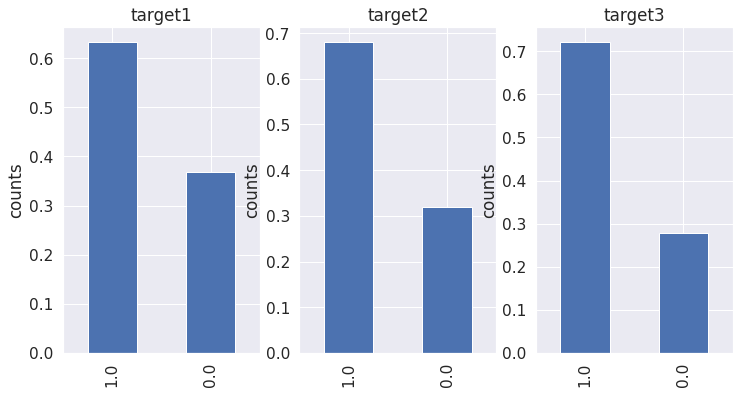

In [222]:
fig, ax = plt.subplots(1,3, figsize=(12,6))
for i,column in zip([0,1,2], [train_1['target1'], train_2['target2'],train_3['target3']]):
    column.value_counts(normalize=True).plot(kind='bar', ax=ax[i], title=column.name,ylabel='counts')

### CORRELATION WITH TARGET

In [223]:
%%time
CORR=True
targets = ['target1', 'target2', 'target3']
dataframes = [train_1, train_2, train_3]

if CORR:
    for df, target in zip(dataframes, targets):
        print('\n\t', target.upper())
        features = [c for c in df.columns if c not in ['User_ID', target]]
        corrs = {}
        for c in tqdm(features):  
            try:
                corrs[c] = np.corrcoef(df[c], df[target])[0][1]
            except:
                pass

        corr_df = pd.DataFrame(corrs, index = [0]).melt().rename(columns={'variable':'FEATURE', 'value': 'CORRELATION'}).sort_values('CORRELATION', ascending=False).dropna()
        display(corr_df.head(20),corr_df.tail(4))


	 TARGET1


100%|██████████| 401/401 [00:00<00:00, 1060.51it/s]


,FEATURE,CORRELATION
335,Target,0.930104
336,Target_shift1,0.854628
294,End_Time_Year,0.831203
0,CompPart,0.831203
291,End_Time_Month,0.804208
323,Start_Time_Month,0.789697
1,CompPart_shift1,0.771899
337,Target_shift2,0.769007
2,CompPart_shift2,0.700030
338,Target_shift3,0.699110


,FEATURE,CORRELATION
63,Comp_ID_ID_F7QD,-0.126244
9,Comp_ID_ID_1CTF,-0.139979
136,Countries_ID_0FT1,-0.169870
308,FeatureX_0.0,-0.192556



	 TARGET2


100%|██████████| 401/401 [00:00<00:00, 1173.08it/s]


,FEATURE,CORRELATION
335,Target,0.876295
336,Target_shift1,0.798040
0,CompPart,0.774854
294,End_Time_Year,0.774854
291,End_Time_Month,0.746347
323,Start_Time_Month,0.734605
337,Target_shift2,0.734077
1,CompPart_shift1,0.713307
338,Target_shift3,0.667134
2,CompPart_shift2,0.662597


,FEATURE,CORRELATION
63,Comp_ID_ID_F7QD,-0.127825
9,Comp_ID_ID_1CTF,-0.157948
136,Countries_ID_0FT1,-0.167290
308,FeatureX_0.0,-0.179150



	 TARGET3


100%|██████████| 401/401 [00:00<00:00, 1216.49it/s]


,FEATURE,CORRELATION
335,Target,0.814749
336,Target_shift1,0.742727
0,CompPart,0.712055
294,End_Time_Year,0.712055
337,Target_shift2,0.683892
291,End_Time_Month,0.683178
323,Start_Time_Month,0.674656
1,CompPart_shift1,0.657215
338,Target_shift3,0.634965
2,CompPart_shift2,0.611340


,FEATURE,CORRELATION
63,Comp_ID_ID_F7QD,-0.123195
136,Countries_ID_0FT1,-0.164937
308,FeatureX_0.0,-0.169170
9,Comp_ID_ID_1CTF,-0.175298


CPU times: user 1.15 s, sys: 18.9 ms, total: 1.17 s
Wall time: 1.17 s


### HOW HAS ZINDIS USER BASE GROWN OVER TIME?

In [224]:
train['year']=1

In [226]:
df = train[['User_ID','month', 'year','day','date']]
df['count_users'] = df.groupby(['month', 'year', 'day'])['User_ID'].transform('count')
df = df.drop(['User_ID'],1).drop_duplicates()

df = df.sort_values(['month', 'year', 'day'])

df.sample(3)

,month,year,day,date,count_users
482,4,1,11,10,135
14168,5,1,30,59,717
39907,7,1,14,104,505


In [227]:
np.sort(df['count_users'])[-5:]

array([1002, 1028, 1737, 1896, 3259])

In [228]:
df['count_users'][df['count_users']==np.sort(df['count_users'])[-1]] =np.sort(df['count_users'])[-2]

In [229]:
df[df['month']==4].day.max()

30

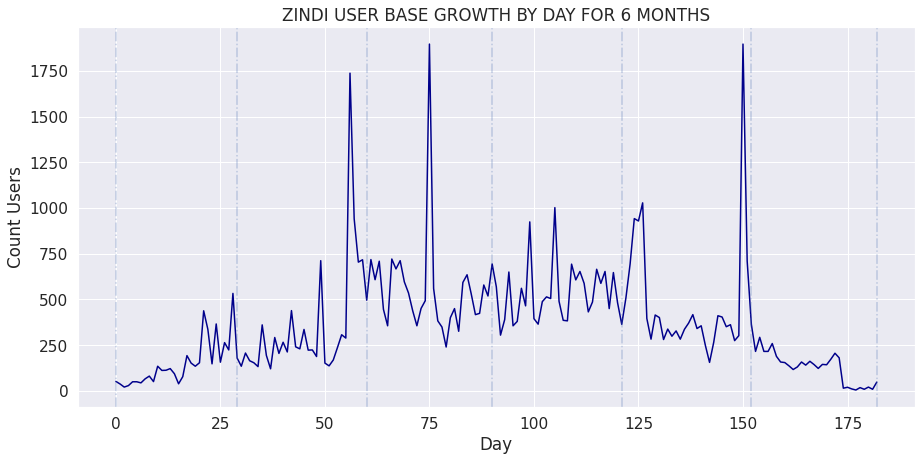

In [230]:
fig, ax = plt.subplots(figsize=(15,7))
ax.plot(df['date'].values, df['count_users'].values,  color = 'darkblue')

ax.axvline(x = df[df['month']==4].date.min(), color = 'b', alpha=0.3, linestyle='dashdot')
ax.axvline(x = df[df['month']==4].date.max(), color = 'b', alpha=0.3, linestyle='dashdot')
ax.axvline(x = df[df['month']==5].date.max(), color = 'b', alpha=0.3, linestyle='dashdot')
ax.axvline(x = df[df['month']==6].date.max(), color = 'b', alpha=0.3, linestyle='dashdot') 
ax.axvline(x = df[df['month']==7].date.max(), color = 'b', alpha=0.3, linestyle='dashdot')
ax.axvline(x = df[df['month']==8].date.max(), color = 'b', alpha=0.3, linestyle='dashdot')
ax.axvline(x = df[df['month']==9].date.max(), color = 'b', alpha=0.3, linestyle='dashdot') 

ax.set_title('ZINDI USER BASE GROWTH BY DAY FOR 6 MONTHS')
ax.set_ylabel('Count Users')
ax.set_xlabel('Day')
plt.show()

In [231]:
df = train[['User_ID', 'Target']].groupby(['User_ID']).count().reset_index()
df[df.Target >200]

,User_ID,Target
213,ID_0SXRNUSA,263
3172,ID_CEDNKSVV,584
3634,ID_E7SKL6R4,239
6064,ID_NOPDIGFM,227
7598,ID_TQM9E72F,240
8655,ID_Y5D6LTDR,212


In [232]:
df = train
df['count_activities'] = df.groupby(['User_ID','month', 'year', 'day','date'])['Target'].transform('count')
df = df.sort_values(['date'])
# df['my'] = df['year'].astype(str) +'_'+ df['month'].astype(str) +'_'+ df['day'].astype(str)
# # MAP PREVIOUSLY CREATED DICT TO TRANSFORM MY
# df['my'] = df['my'].map(m_ydict)

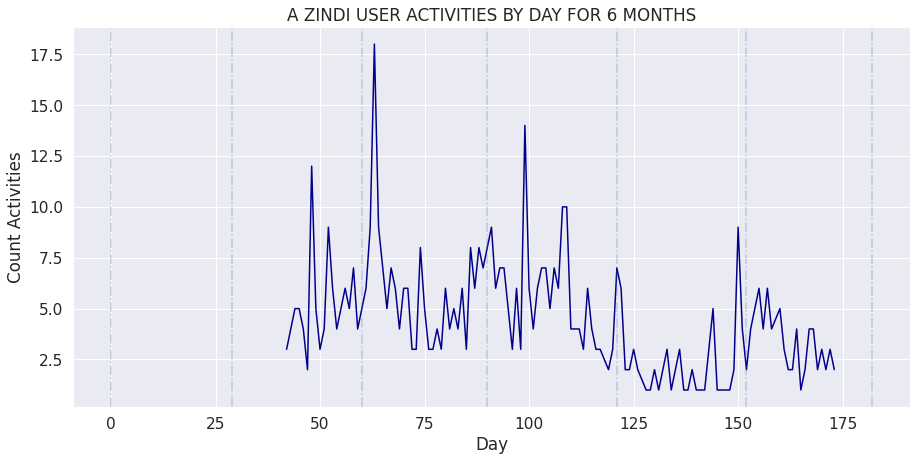

In [233]:
fig, ax = plt.subplots(figsize=(15,7)) 
ax.plot(df[df.User_ID == "ID_CEDNKSVV"]['date'].values, df[df.User_ID == "ID_CEDNKSVV"]['count_activities'].values,  color = 'darkblue')

ax.axvline(x = df[df['month']==4].date.min(), color = 'b', alpha=0.3, linestyle='dashdot')
ax.axvline(x = df[df['month']==4].date.max(), color = 'b', alpha=0.3, linestyle='dashdot')
ax.axvline(x = df[df['month']==5].date.max(), color = 'b', alpha=0.3, linestyle='dashdot')
ax.axvline(x = df[df['month']==6].date.max(), color = 'b', alpha=0.3, linestyle='dashdot') 
ax.axvline(x = df[df['month']==7].date.max(), color = 'b', alpha=0.3, linestyle='dashdot')
ax.axvline(x = df[df['month']==8].date.max(), color = 'b', alpha=0.3, linestyle='dashdot')
ax.axvline(x = df[df['month']==9].date.max(), color = 'b', alpha=0.3, linestyle='dashdot') 

ax.set_title('A ZINDI USER ACTIVITIES BY DAY FOR 6 MONTHS')
ax.set_ylabel('Count Activities')
ax.set_xlabel('Day')
plt.show()

---
---

# MODELLING

#### I separated the users into groups of 3 for predicting the next month, and groups of 2 for predicting the following 2 months. Users were grouped based on when they joined Zindi (i.e how many time they appear in the train dataframe)

In [234]:
# GETTING USER VALUE COUNTS
train_vc = train_1['User_ID'].value_counts().to_frame().reset_index()
display(train_vc)

,index,User_ID
0,ID_CEDNKSVV,583
1,ID_0SXRNUSA,262
2,ID_TQM9E72F,239
3,ID_E7SKL6R4,238
4,ID_NOPDIGFM,226
...,...,...
7267,ID_MG3JQOOV,1
7268,ID_T08JQ93I,1
7269,ID_PMGZKP91,1
7270,ID_H0DIHFTS,1


<AxesSubplot:xlabel='Value Count', ylabel='Density'>

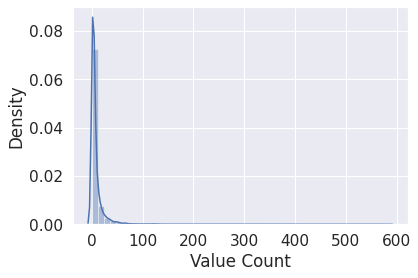

In [235]:
# COUNTS OF HOW MANY USERS SHARE THE SAME VALUE COUNTS
series = train_vc['User_ID']
series.name = 'Value Count'
sns.distplot(series, bins=50)

#### GROUPING THE USERS

In [236]:
# CLUSTER 1 CONTAINS ALL USERS WHO JOINED ZINDI 17 MONTHS AGO OR LATER
c1 = train_vc[train_vc['User_ID']>=4]['index'].tolist()
print(len(c1))

# CLUSTER 3 CONTAINS ALL USERS WHO JOINED ZINDI 6 MONTHS AGO OR EARLIER
c3 = train_vc[train_vc['User_ID']<=2]['index'].tolist()
print(len(c3))

# WE WILL ADD MORE USERS TO CLUSTER 3 FOR TRAINING PURPOSES (MORE DATA) BUT 
# WILL NOT USE THIS MODEL TO PREDICT ON THESE ADDED USERS
### HERE WE SELECT USERS WHO JOINED ZINDI 11 MONTHS AGO OR LATER AND
### WE'LL EXCLUDE THESE USERS FROM THE DATA USED TO TRAIN AND PREDICT
### FOR CLUSTER 3 USERS
c3_1 = train_vc[train_vc['User_ID']>=3]['index'].tolist()
print(len(c3_1))

# AND CLUSTER 2 USERS WILL BE USERS NOT IN CLUSTER 1 OR 3

3451
2870
4402


In [237]:
# SUBSET OUR DATAFRAMES FOR EACH USER GROUP
train1_c1 = train_1[train_1['User_ID'].isin(c1)]
print(train1_c1.shape)
# ---- train1_c2 is just train_1
train1_c3 = train_1[~train_1['User_ID'].isin(c3_1)]
print(train1_c3.shape)

train2_c1 = train_2[train_2['User_ID'].isin(c1)]
print(train2_c1.shape)
# ---- train2_c2 is just train_2

train3_c1 = train_3[train_3['User_ID'].isin(c1)]
print(train3_c1.shape)
# ---- train3_c2 is just train_3

(52320, 403)
(4251, 403)
(48869, 403)
(45418, 403)


#### PARTION THE TEST DATA BY USER GROUP

In [238]:
# SAVE USER ORDER IN TEST DATASET
for_test_user_order = for_test[['User_ID']].set_index(['User_ID'])
display(for_test_user_order.head())
print(for_test_user_order.shape)

# GROUP 1 USERS
for_test_c1 = for_test[for_test['User_ID'].isin(c1)]
print(for_test_c1.shape)

# GROUP 2 USERS ARENT IN GROUP ONE OR GROUP 3
for_test_c2 = for_test[~for_test['User_ID'].isin(c1)]
for_test_c2 = for_test_c2[~for_test_c2['User_ID'].isin(c3)]
print(for_test_c2.shape)

# GROUP 3 USERS ARE THE MOST RECENT USERS, THEY ARE NOT IN GROUP 1 OR 2
not_c3 = list(for_test_c2['User_ID'].unique()) + list(for_test_c1['User_ID'].unique())
for_test_c3 = for_test[~for_test['User_ID'].isin(not_c3)]
print(for_test_c3.shape)

# DOES IT ALL ADD UP?
print(for_test_c1.shape[0]+for_test_c2.shape[0]+for_test_c3.shape[0])

""
User_ID
ID_0RKP0LQX
ID_U91NSYHH
ID_U91NSYHH
ID_81ANW3VU
ID_81ANW3VU


(14934, 0)
(2800, 402)
(11976, 402)
(158, 402)
14934


### REOMVE OUTLIERS

In [239]:
def remove_outliers(df, columns, threshold, return_df=True):
    df = df.copy()
    # Calculate the lower and upper bounds on the Z distribution given a threshold value
    lower_bound = sc.stats.norm.ppf(q=threshold / 2, loc=0, scale=1)
    upper_bound = sc.stats.norm.ppf(q=1 - threshold / 2, loc=0, scale=1)

    # Calculate X scores for affected columns
    outlier_df = df.loc[:, columns].copy().astype(float)
    
    zscores = pd.DataFrame(sc.stats.zscore(outlier_df, axis=0),
                           index=outlier_df.index,
                           columns=outlier_df.columns)

    # Get boolean arrays denoting the outlier examples
    lower_outliers = (zscores < lower_bound).any(axis=1)
    upper_outliers = (zscores >= upper_bound).any(axis=1)

    # Get indicies of all outlier examples
    outliers = list(df[pd.concat([lower_outliers, upper_outliers],
                            axis=1).any(axis=1)].index)
    
    del zscores,lower_outliers,upper_outliers,outlier_df,columns
    gc.collect()
    
    if return_df:
        # Drop the outliers
        df = df.drop(outliers, axis=0).reset_index(drop=True)

        return df, outliers
    else: 
        return outliers

def noise_removal(df, target_name, targets, threshold, col_thresholds,return_df=True):
    print(f'\n\n{target_name.upper()}\n')
    less_noisy = pd.DataFrame()
    all_the_noise = []
    
    # SELECTING WHICH COLUMNS TO USE IN FINDING OUTLIERS BY CONSIDERING THE 
    # AMOUNT OF UNIQUE VALUES IN THE COLUMN
    
    tempdf = df.drop(['User_ID'], axis=1).copy()
    features = [c for c in tempdf.columns if c not in ['User_ID', 'comp_start_date','comp_end_date','month', 'year', 'day','date']]
    ###### tempdf = df.drop(['User_ID','Comp_ID'], axis=1).copy()
    ###### features = [c for c in tempdf.columns if c not in ['User_ID','Comp_ID', 'month', 'year', 'day']]
    
    nunique_df = pd.DataFrame()

    for col in features:
        nunique_df[col] = [tempdf[col].nunique()]

    nunique_df = nunique_df.T.reset_index()
    nunique_df.rename(columns={0:'n_unique', 'index':'feature'}, inplace=True)
    nunique_df = nunique_df.sort_values(['n_unique'])
    
    col_threshold_min, col_threshold_max = col_thresholds[0], col_thresholds[1]
    # GET THE COLUMNS WITHIN THE N_UNIQUE BOUNDARIES
    numerical_columns = nunique_df[nunique_df['n_unique'].isin(range(col_threshold_min,
                                                                     col_threshold_max))]['feature'].tolist()
    
    del tempdf
    
    # REMOVE OUTLIERS WITHIN TARGET
    for target in targets: 
        targetdf = df.loc[df[target_name]==target] 
        if return_df:
            less_noise, the_noise = remove_outliers(df=targetdf,
                                    columns=numerical_columns,
                                    threshold=threshold,
                                    return_df=True) 
            less_noisy = less_noisy.append([less_noise]) 
            del less_noise
            
        else:
            the_noise = remove_outliers(df=targetdf,
                                        columns=numerical_columns,
                                        threshold=threshold,
                                        return_df=False) 
        
        all_the_noise += the_noise 
        
        print(f'Targeted {len(the_noise)} outliers from target {target}')
        del targetdf, the_noise
        gc.collect()

    del numerical_columns
    gc.collect()

    print('Train df:\t\t\t',df.shape)
    print('\n Noise:',len(all_the_noise), '\n')
    
    if return_df:
        print('Train df after removing ouliers within each target group:', less_noisy.shape)
        return less_noisy
    else:
        return all_the_noise

#### ONLY LOOKING FOR OUTLIERS WITHIN GROUP 2, AS THIS GROUP WILL BE TRAINIED ON ALL THE DATA, BUT PREDICTING FOR THOSE ONLY IN GROUP 2

In [240]:
%%time
return_df = False
train_1_outliers = noise_removal(train_1, 'target1',[0,1], 0.00000005, [15,1500], return_df=return_df)
train_2_outliers = noise_removal(train_2, 'target2',[0,1], 0.000000000025, [15,1500], return_df=return_df)



TARGET1

Targeted 1663 outliers from target 0
Targeted 3294 outliers from target 1
Train df:			 (59424, 403)

 Noise: 4957 



TARGET2

Targeted 1025 outliers from target 0
Targeted 2362 outliers from target 1
Train df:			 (52152, 403)

 Noise: 3387 

CPU times: user 2.86 s, sys: 300 ms, total: 3.16 s
Wall time: 3.15 s


In [241]:
outliers_train_1 = train_1.loc[train_1_outliers]
# ONLY CONSIDER REMOVING THE OUTLIERS NOT FROM GROUP 2
outliers_train_1 = outliers_train_1[outliers_train_1['User_ID'].isin(c1)]
display(outliers_train_1)
print(outliers_train_1['target1'].value_counts())

,CompPart,CompPart_shift1,CompPart_shift2,CompPart_shift3,Comp_ID_ID_0D02,Comp_ID_ID_0SN1,Comp_ID_ID_0W7H,Comp_ID_ID_0Y9T,Comp_ID_ID_1261,Comp_ID_ID_1CTF,Comp_ID_ID_1DWD,Comp_ID_ID_1Q60,Comp_ID_ID_1ZWS,Comp_ID_ID_208Z,Comp_ID_ID_20XL,Comp_ID_ID_2MIC,Comp_ID_ID_3AG0,Comp_ID_ID_3MK3,Comp_ID_ID_3RMM,Comp_ID_ID_44CX,Comp_ID_ID_45W9,Comp_ID_ID_51ZG,Comp_ID_ID_528W,Comp_ID_ID_53GM,Comp_ID_ID_540G,Comp_ID_ID_56O8,Comp_ID_ID_5KD8,Comp_ID_ID_5NAE,Comp_ID_ID_61E9,Comp_ID_ID_64EM,Comp_ID_ID_66QC,Comp_ID_ID_6E1C,Comp_ID_ID_6IDY,Comp_ID_ID_7079,Comp_ID_ID_7CF2,Comp_ID_ID_7YDI,Comp_ID_ID_89DI,Comp_ID_ID_8B8I,Comp_ID_ID_8BH9,Comp_ID_ID_8DGC,Comp_ID_ID_8SHD,Comp_ID_ID_9BU8,Comp_ID_ID_9TS1,Comp_ID_ID_A1ZA,Comp_ID_ID_AL6C,Comp_ID_ID_AS79,Comp_ID_ID_BARV,Comp_ID_ID_BR9A,Comp_ID_ID_BXIL,Comp_ID_ID_BZV0,Comp_ID_ID_CFN7,Comp_ID_ID_CMWO,Comp_ID_ID_CNBR,Comp_ID_ID_CR6P,Comp_ID_ID_CVUS,Comp_ID_ID_CYEF,Comp_ID_ID_D242,Comp_ID_ID_D3SA,Comp_ID_ID_D6NX,Comp_ID_ID_DD5S,Comp_ID_ID_DFKK,Comp_ID_ID_E1KX,Comp_ID_ID_F5JG,Comp_ID_ID_F7QD,Comp_ID_ID_FCRM,Comp_ID_ID_FM77,Comp_ID_ID_FN7K,Comp_ID_ID_FZ48,Comp_ID_ID_G05Z,Comp_ID_ID_G5IQ,Comp_ID_ID_GAV9,Comp_ID_ID_GR92,Comp_ID_ID_GVGW,Comp_ID_ID_GWL0,Comp_ID_ID_H3QQ,Comp_ID_ID_HCN1,Comp_ID_ID_HCST,Comp_ID_ID_HGJN,Comp_ID_ID_I9BN,Comp_ID_ID_IMTG,Comp_ID_ID_IQLI,Comp_ID_ID_IV5D,Comp_ID_ID_IVH9,Comp_ID_ID_J5IZ,Comp_ID_ID_J883,Comp_ID_ID_JRC2,Comp_ID_ID_JX23,Comp_ID_ID_KESL,Comp_ID_ID_KGUF,Comp_ID_ID_KHED,Comp_ID_ID_KU2G,Comp_ID_ID_L3EB,Comp_ID_ID_L9R0,Comp_ID_ID_LFJT,Comp_ID_ID_LSIO,Comp_ID_ID_M3G0,Comp_ID_ID_MN35,Comp_ID_ID_N5MO,Comp_ID_ID_NKJR,Comp_ID_ID_OAR6,...,FeatureE_1.0,FeatureE_2.0,FeatureE_3.0,FeatureE_sum_by_day,FeatureE_sum_by_month,FeatureX_0.0,FeatureX_1.0,FeatureX_sum_by_day,FeatureX_sum_by_month,FeatureY_0.0,FeatureY_1.0,FeatureY_3.0,FeatureY_sum_by_day,FeatureY_sum_by_month,Personal,Personal_sum_by_day,Personal_sum_by_month,Start_Time_Day_of_month,Start_Time_Day_of_month_sum_by_day,Start_Time_Day_of_month_sum_by_month,Start_Time_Month,Start_Time_Month_sum_by_day,Start_Time_Month_sum_by_month,Sub,Sub_shift1,Sub_shift2,Sub_shift3,Sub_sum,Sub_sum_by_day,Sub_sum_by_month,Sub_sum_sum_by_day,Sub_sum_sum_by_month,Target,Target_shift1,Target_shift2,Target_shift3,Target_sum_by_day,Target_sum_by_month,Theme,Theme_sum_by_day,Theme_sum_by_month,User_ID,comp_duration,comp_duration_sum_by_day,comp_duration_sum_by_month,count_blogs,count_blogs_sum,count_blogs_sum_by_day,count_blogs_sum_by_month,count_blogs_sum_sum_by_day,count_blogs_sum_sum_by_month,count_comments,count_comments_sum_by_day,count_comments_sum_by_month,count_comps,count_comps_sub,count_comps_sub_sum_by_day,count_comps_sub_sum_by_month,count_comps_sum,count_comps_sum_by_day,count_comps_sum_by_month,count_comps_sum_sum_by_day,count_comps_sum_sum_by_month,count_subs,count_subs_sum,count_subs_sum_by_day,count_subs_sum_by_month,count_subs_sum_sum_by_day,count_subs_sum_sum_by_month,count_users_by_comp,count_users_by_comp_sum_by_day,count_users_by_comp_sum_by_month,counting,counting_by_month,date,day,day_sum_by_month,days_left,days_left_sum_by_day,days_left_sum_by_month,feature_A_,feature_A_1,feature_A_1_sum_by_day,feature_A_1_sum_by_month,feature_A_4,feature_A_5,feature_A_5_sum_by_day,feature_A_5_sum_by_month,feature_A__sum_by_month,feature_F_2,feature_F_2_sum_by_day,feature_F_2_sum_by_month,feature_G_,feature_G__sum_by_day,feature_G__sum_by_month,month,my_sum_by_day,my_sum_by_month,year,target1
7,1.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0.0,0.0,0,1,2.0,2.0,1,0,0,0.0,0.0,0.0,0.0,0.0,29.0,29.0,29.0,3.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,ID_68J8H4X9,277.0,277.0,277.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,2.0,2,2,0,1,2,274.0,274.0,274.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

1.0    3293
0.0    1645
Name: target1, dtype: int64


In [242]:
outliers_train_2 = train_2.loc[train_2_outliers]
# ONLY CONSIDER REMOVING THE OUTLIERS NOT FROM GROUP 2
outliers_train_2 = outliers_train_2[outliers_train_2['User_ID'].isin(c1)]
display(outliers_train_2)
print(outliers_train_2['target2'].value_counts())

,CompPart,CompPart_shift1,CompPart_shift2,CompPart_shift3,Comp_ID_ID_0D02,Comp_ID_ID_0SN1,Comp_ID_ID_0W7H,Comp_ID_ID_0Y9T,Comp_ID_ID_1261,Comp_ID_ID_1CTF,Comp_ID_ID_1DWD,Comp_ID_ID_1Q60,Comp_ID_ID_1ZWS,Comp_ID_ID_208Z,Comp_ID_ID_20XL,Comp_ID_ID_2MIC,Comp_ID_ID_3AG0,Comp_ID_ID_3MK3,Comp_ID_ID_3RMM,Comp_ID_ID_44CX,Comp_ID_ID_45W9,Comp_ID_ID_51ZG,Comp_ID_ID_528W,Comp_ID_ID_53GM,Comp_ID_ID_540G,Comp_ID_ID_56O8,Comp_ID_ID_5KD8,Comp_ID_ID_5NAE,Comp_ID_ID_61E9,Comp_ID_ID_64EM,Comp_ID_ID_66QC,Comp_ID_ID_6E1C,Comp_ID_ID_6IDY,Comp_ID_ID_7079,Comp_ID_ID_7CF2,Comp_ID_ID_7YDI,Comp_ID_ID_89DI,Comp_ID_ID_8B8I,Comp_ID_ID_8BH9,Comp_ID_ID_8DGC,Comp_ID_ID_8SHD,Comp_ID_ID_9BU8,Comp_ID_ID_9TS1,Comp_ID_ID_A1ZA,Comp_ID_ID_AL6C,Comp_ID_ID_AS79,Comp_ID_ID_BARV,Comp_ID_ID_BR9A,Comp_ID_ID_BXIL,Comp_ID_ID_BZV0,Comp_ID_ID_CFN7,Comp_ID_ID_CMWO,Comp_ID_ID_CNBR,Comp_ID_ID_CR6P,Comp_ID_ID_CVUS,Comp_ID_ID_CYEF,Comp_ID_ID_D242,Comp_ID_ID_D3SA,Comp_ID_ID_D6NX,Comp_ID_ID_DD5S,Comp_ID_ID_DFKK,Comp_ID_ID_E1KX,Comp_ID_ID_F5JG,Comp_ID_ID_F7QD,Comp_ID_ID_FCRM,Comp_ID_ID_FM77,Comp_ID_ID_FN7K,Comp_ID_ID_FZ48,Comp_ID_ID_G05Z,Comp_ID_ID_G5IQ,Comp_ID_ID_GAV9,Comp_ID_ID_GR92,Comp_ID_ID_GVGW,Comp_ID_ID_GWL0,Comp_ID_ID_H3QQ,Comp_ID_ID_HCN1,Comp_ID_ID_HCST,Comp_ID_ID_HGJN,Comp_ID_ID_I9BN,Comp_ID_ID_IMTG,Comp_ID_ID_IQLI,Comp_ID_ID_IV5D,Comp_ID_ID_IVH9,Comp_ID_ID_J5IZ,Comp_ID_ID_J883,Comp_ID_ID_JRC2,Comp_ID_ID_JX23,Comp_ID_ID_KESL,Comp_ID_ID_KGUF,Comp_ID_ID_KHED,Comp_ID_ID_KU2G,Comp_ID_ID_L3EB,Comp_ID_ID_L9R0,Comp_ID_ID_LFJT,Comp_ID_ID_LSIO,Comp_ID_ID_M3G0,Comp_ID_ID_MN35,Comp_ID_ID_N5MO,Comp_ID_ID_NKJR,Comp_ID_ID_OAR6,...,FeatureE_1.0,FeatureE_2.0,FeatureE_3.0,FeatureE_sum_by_day,FeatureE_sum_by_month,FeatureX_0.0,FeatureX_1.0,FeatureX_sum_by_day,FeatureX_sum_by_month,FeatureY_0.0,FeatureY_1.0,FeatureY_3.0,FeatureY_sum_by_day,FeatureY_sum_by_month,Personal,Personal_sum_by_day,Personal_sum_by_month,Start_Time_Day_of_month,Start_Time_Day_of_month_sum_by_day,Start_Time_Day_of_month_sum_by_month,Start_Time_Month,Start_Time_Month_sum_by_day,Start_Time_Month_sum_by_month,Sub,Sub_shift1,Sub_shift2,Sub_shift3,Sub_sum,Sub_sum_by_day,Sub_sum_by_month,Sub_sum_sum_by_day,Sub_sum_sum_by_month,Target,Target_shift1,Target_shift2,Target_shift3,Target_sum_by_day,Target_sum_by_month,Theme,Theme_sum_by_day,Theme_sum_by_month,User_ID,comp_duration,comp_duration_sum_by_day,comp_duration_sum_by_month,count_blogs,count_blogs_sum,count_blogs_sum_by_day,count_blogs_sum_by_month,count_blogs_sum_sum_by_day,count_blogs_sum_sum_by_month,count_comments,count_comments_sum_by_day,count_comments_sum_by_month,count_comps,count_comps_sub,count_comps_sub_sum_by_day,count_comps_sub_sum_by_month,count_comps_sum,count_comps_sum_by_day,count_comps_sum_by_month,count_comps_sum_sum_by_day,count_comps_sum_sum_by_month,count_subs,count_subs_sum,count_subs_sum_by_day,count_subs_sum_by_month,count_subs_sum_sum_by_day,count_subs_sum_sum_by_month,count_users_by_comp,count_users_by_comp_sum_by_day,count_users_by_comp_sum_by_month,counting,counting_by_month,date,day,day_sum_by_month,days_left,days_left_sum_by_day,days_left_sum_by_month,feature_A_,feature_A_1,feature_A_1_sum_by_day,feature_A_1_sum_by_month,feature_A_4,feature_A_5,feature_A_5_sum_by_day,feature_A_5_sum_by_month,feature_A__sum_by_month,feature_F_2,feature_F_2_sum_by_day,feature_F_2_sum_by_month,feature_G_,feature_G__sum_by_day,feature_G__sum_by_month,month,my_sum_by_day,my_sum_by_month,year,target2
2,1.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0.0,0.0,0,1,2.0,2.0,1,0,0,0.0,0.0,0.0,0.0,0.0,29.0,29.0,29.0,3.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,ID_68J8H4X9,277.0,277.0,277.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,2.0,2,2,0,1,2,274.0,274.0,274.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

1.0    2361
0.0    1022
Name: target2, dtype: int64


In [243]:
# GET THE INDEX OF THE OUTLIERS NOT FROM GROUP 2
out1 = outliers_train_1.index
out2 = outliers_train_2.index

---

---

# MODEL TRAINING

## LIGHT GBM _ NO.1
## Predicting for seen users

In [244]:
set_seed(42)

params_lgbm1 = {'boosting_type':     'gbdt',   
               'verbosity':         -1,
               'seed':              1,
               'objective':         'binary',
               'min_data_in_leaf':  33,
               'num_leaves':        50,
               'max_depth':         20,
               'n_estimators':      5000,
               'path_smooth':       500,
               'n_jobs':            -1,
               'first_metric_only': False, 
#                'is_unbalance':      True,
               'learning_rate':     0.007}

params_lgbm2 = {'boosting_type':     'gbdt',   
               'verbosity':         -1,
               'seed':              1,
               'objective':         'binary', 
               'min_data_in_leaf':  40,
               'num_leaves':        90,
               'max_depth':         12,
               'n_estimators':      4000,
               'path_smooth':       30,
               'n_jobs':            -1,
               'first_metric_only': False, 
#                'is_unbalance':      True,
               'learning_rate':     0.01}

params_lgbm3 = {'boosting_type':     'gbdt',   
               'verbosity':         -1,
               'seed':              1,
               'objective':         'binary',
               'min_data_in_leaf':  35,
               'num_leaves':        75,
               'max_depth':         11,
               'n_estimators':      4000,
               'path_smooth':       10,
               'n_jobs':            -1,
               'first_metric_only': False, 
#                'is_unbalance':      True,
               'learning_rate':     0.009}

model1 = LGBMClassifier(**params_lgbm1)
model2 = LGBMClassifier(**params_lgbm2)
model3 = LGBMClassifier(**params_lgbm3)

In [245]:
def evaluate_lgb(x, y, test_, final_test_, cv, params_lgbm, prefix='', task='TRAIN', path='./train/'):

    kfold = KFold(n_splits = cv, random_state = 1, shuffle = True)

    # Create out of folds array
    oof_predictions = np.zeros(x.shape[0])
    test_predictions = np.zeros(test_.shape[0])
    final_test_predictions = np.zeros(final_test_.shape[0])
    
    feature_importances = np.zeros(x.shape[1])
    
    for fold, (trn_ind, val_ind) in enumerate(kfold.split(x)):

        X_train, X_test = x.iloc[trn_ind], x.iloc[val_ind]
        y_train, y_test = y.iloc[trn_ind], y.iloc[val_ind]

        print('Training Data: ',X_train.shape, y_train.shape)
        print('Validation Data: ',X_test.shape, y_test.shape, '\n')
        
        if task=='TRAIN':
            print('\n','*'*7,f'Training fold {fold + 1}','*'*7, '\n')
            model = LGBMClassifier(**params_lgbm)
            model.fit(   
                        X_train, y_train,
                        eval_set=[(X_train, y_train), (X_test, y_test)],
                        eval_metric=['auc'],
                        early_stopping_rounds=100,
                        verbose=100
                     )  
            with open(path+f'lgb_model{prefix}_useractivity_fold_{fold+1}.pkl', 'wb') as file:
                pickle.dump(model, file)  
        
        else:
            print('\n','*'*7,f'Predicting fold {fold + 1}','*'*7, '\n')
            with open(path+f'lgb_model{prefix}_useractivity_fold_{fold+1}.pkl', 'rb') as file:
                model = pickle.load(file)
               
        gc.collect()
        pred = model.predict_proba(X_test.values)[:,1]
        pred_train = model.predict_proba(X_train.values)[:,1]
        test_auc = roc_auc_score(y_test, pred)
        train_auc = roc_auc_score(y_train, pred_train)
        print(f'AUC TEST: {test_auc}')
        print(f'AUC TRAIN: {train_auc}')

        oof_predictions[val_ind] = pred
        
        test_pred = model.predict_proba(test_.values)[:,1] 
        test_predictions += test_pred / cv
        
        final_test_pred = model.predict_proba(final_test_.values)[:,1] 
        final_test_predictions += final_test_pred / cv
        
        feature_importances += model.feature_importances_ / cv
        
        del X_train, y_train, X_test, y_test
        gc.collect()
    
    return final_test_predictions.reshape(-1,1), test_predictions.reshape(-1,1), oof_predictions.reshape(-1,1), feature_importances

def get_importance_plot(feature_importances_, columns):
    
    feature_importances = pd.DataFrame({'feature': columns, 
                                        'importance': feature_importances_}).sort_values('importance',ascending = False) 

    # Cumulative importance plot
    feature_importances['importance_normalized'] = feature_importances['importance'] / feature_importances['importance'].sum()
    feature_importances['cumulative_importance'] = np.cumsum(feature_importances['importance_normalized'])

    plt.figure(figsize = (10, 15))
    plt.barh(feature_importances.sort_values('importance')['feature'][-30:], feature_importances.sort_values('importance')['importance'][-30:])
    plt.xlabel('Importance', size=14) 
    plt.title('Feature Importance', size=17)
    plt.grid(True)
    plt.show()

    plt.figure(figsize = (7, 4))
    plt.plot(list(range(len(feature_importances))), feature_importances['cumulative_importance'], 'b')
    plt.xlabel('Number of Features', size=11) 
    plt.ylabel('Cumulative Importance', size=11)
    plt.title('Cumulative Feature Importance', size=15)
    plt.grid(True)
    plt.show()

    num_important = feature_importances[feature_importances['cumulative_importance']< 0.993][['feature', 'importance']].shape[0]
    print(f'{num_important} Features accounts for 99.3% of the cumulative importance.')

    # ranked features
    important_x =  feature_importances['feature'].tolist()
    return important_x

In [246]:
model_path = './train/'#'../input/user-act-prediction/'
task = 'TRAIN'

### Target 1 Cluster 1

In [247]:
FS = False
features1 = []
drop = ['year']
target = 'target1'

if FS:
    X = train1_c1[train1_c1['month']>1][features1]
    for_test_1 = for_test_c1[features1]
    for_test_1 = for_test_c1[features1]
    final_test_1 = test[for_test_1.columns]
else: 
    X = train1_c1[train1_c1['month']>1].drop(['User_ID', target]+drop,1)
    for_test_1 = for_test_c1.drop(['User_ID']+drop,1)
    final_test_1 = test[for_test_1.columns]
    
y = train1_c1[train1_c1['month']>1][[target]]

print(X.shape, y.shape, for_test_1.shape)

(52320, 400) (52320, 1) (2800, 400)


In [248]:
train3_c1['month'].unique()

array([4, 5, 6, 7, 8, 9])

In [249]:
np.unique(y)

array([0., 1.])

In [250]:
%%time
final_test_predictions1c1, test_predictions1c1, oof_predictions1c1, feature_importances1c1 = evaluate_lgb(X, y, for_test_1, final_test_1,
                                                                             cv=5, 
                                                                             params_lgbm=params_lgbm1,
                                                                             prefix='target1c1',
                                                                             task=task, path=model_path)

Training Data:  (41856, 400) (41856, 1)
Validation Data:  (10464, 400) (10464, 1) 


 ******* Training fold 1 ******* 

[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.994435	training's binary_logloss: 0.286223	valid_1's auc: 0.992157	valid_1's binary_logloss: 0.2939
[200]	training's auc: 0.994719	training's binary_logloss: 0.171898	valid_1's auc: 0.992303	valid_1's binary_logloss: 0.180895
[300]	training's auc: 0.995211	training's binary_logloss: 0.122769	valid_1's auc: 0.992859	valid_1's binary_logloss: 0.133235
[400]	training's auc: 0.995401	training's binary_logloss: 0.0995241	valid_1's auc: 0.992981	valid_1's binary_logloss: 0.111824
[500]	training's auc: 0.995692	training's binary_logloss: 0.0874466	valid_1's auc: 0.993121	valid_1's binary_logloss: 0.101796
[600]	training's auc: 0.996008	training's binary_logloss: 0.080323

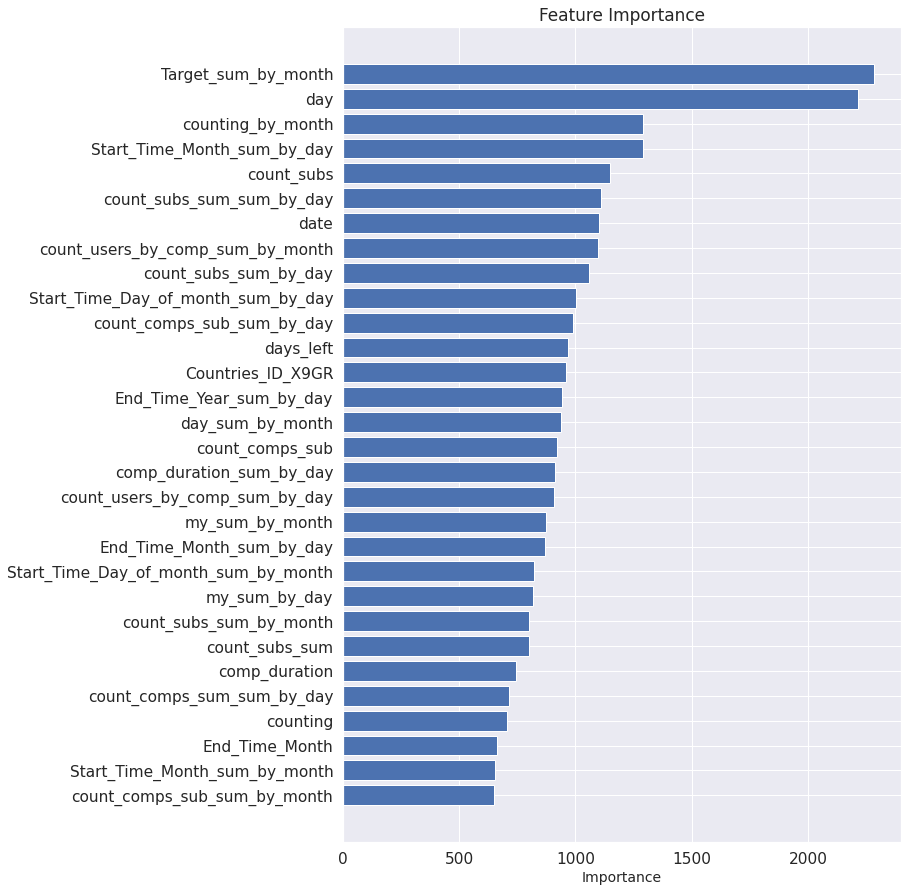

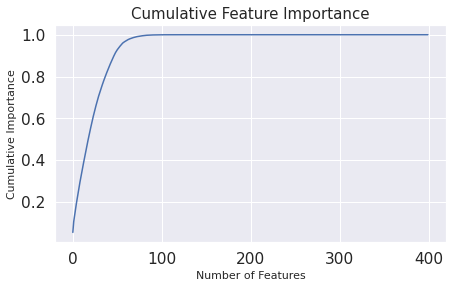

75 Features accounts for 99.3% of the cumulative importance.
TEST AUC TARGET1 CLUSTER 1: 0.9944508568260313

[[15551   644]
 [ 1021 35104]] 

              precision    recall  f1-score   support

         0.0       0.94      0.96      0.95     16195
         1.0       0.98      0.97      0.98     36125

    accuracy                           0.97     52320
   macro avg       0.96      0.97      0.96     52320
weighted avg       0.97      0.97      0.97     52320



In [251]:
test_auc1c1 = roc_auc_score(y.values.reshape(-1,1), oof_predictions1c1.reshape(-1,1))
importantx1c1 = get_importance_plot(feature_importances1c1, list(X.columns))

print(f'TEST AUC TARGET1 CLUSTER 1: {test_auc1c1}\n')
oof_pred1_01c1 = np.round(oof_predictions1c1,0)
print(metrics.confusion_matrix(y.values.reshape(-1,1), oof_pred1_01c1), '\n')
print(metrics.classification_report(y.values.reshape(-1,1), oof_pred1_01c1))

all_ys = []
all_preds = []
all_ys.append(y.values.reshape(-1,1))
all_preds.append(oof_predictions1c1)

### Target 1 Cluster 2

In [252]:
FS = False
features1 = []
drop = ['year']
target = 'target1'

if FS:
    X = train_1[features1]
    for_test_1 = for_test_c2[features1]
    final_test_1 = test[for_test_1.columns]
else: 
    # DROPPING USERID, TARGET AND OUTLIERS
    X = train_1.drop(['User_ID', target]+drop,1).drop(out1, 0)
    for_test_1 = for_test_c2.drop(['User_ID']+drop,1)
    final_test_1 = test[for_test_1.columns]
    
y = train_1[[target]].drop(out1, 0)

print(X.shape, y.shape, for_test_1.shape)

(54486, 400) (54486, 1) (11976, 400)


In [253]:
%%time
final_test_predictions1c2, test_predictions1c2, oof_predictions1c2, feature_importances1c2 = evaluate_lgb(X, y, for_test_1, final_test_1,
                                                                             cv=5, 
                                                                             params_lgbm=params_lgbm1,
                                                                             prefix='target1c2',
                                                                             task=task, path=model_path)

Training Data:  (43588, 400) (43588, 1)
Validation Data:  (10898, 400) (10898, 1) 


 ******* Training fold 1 ******* 

[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.996577	training's binary_logloss: 0.296165	valid_1's auc: 0.996323	valid_1's binary_logloss: 0.300033
[200]	training's auc: 0.99669	training's binary_logloss: 0.165603	valid_1's auc: 0.996418	valid_1's binary_logloss: 0.168324
[300]	training's auc: 0.996932	training's binary_logloss: 0.108481	valid_1's auc: 0.9966	valid_1's binary_logloss: 0.111116
[400]	training's auc: 0.997213	training's binary_logloss: 0.0814356	valid_1's auc: 0.996742	valid_1's binary_logloss: 0.0839933
[500]	training's auc: 0.997557	training's binary_logloss: 0.0678093	valid_1's auc: 0.997062	valid_1's binary_logloss: 0.0708485
[600]	training's auc: 0.99782	training's binary_logloss: 0.060219

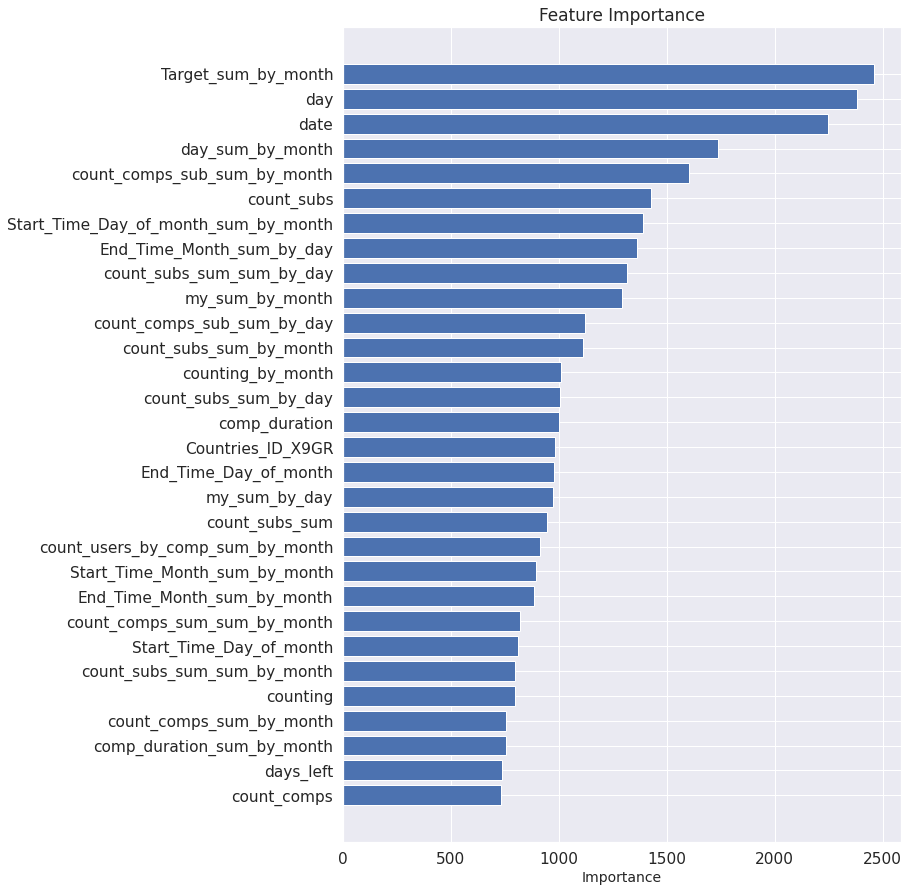

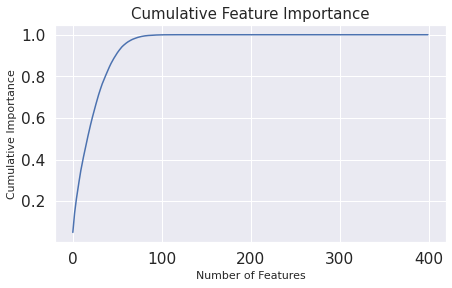

79 Features accounts for 99.3% of the cumulative importance.
TEST AUC TARGET1 CLUSTER 2: 0.9973252020297221

[[19829   363]
 [  832 33462]] 

              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97     20192
         1.0       0.99      0.98      0.98     34294

    accuracy                           0.98     54486
   macro avg       0.97      0.98      0.98     54486
weighted avg       0.98      0.98      0.98     54486



In [254]:
test_auc1c2 = roc_auc_score(y.values.reshape(-1,1), oof_predictions1c2.reshape(-1,1))
importantx1c2 = get_importance_plot(feature_importances1c2, list(X.columns))

print(f'TEST AUC TARGET1 CLUSTER 2: {test_auc1c2}\n')
oof_pred1_01c2 = np.round(oof_predictions1c2,0)
print(metrics.confusion_matrix(y.values.reshape(-1,1), oof_pred1_01c2), '\n')
print(metrics.classification_report(y.values.reshape(-1,1), oof_pred1_01c2))

all_ys.append(y.values.reshape(-1,1))
all_preds.append(oof_predictions1c2)

### Target 1 Cluster 3

In [255]:
drop = ['year']
target = 'target1'

if FS:
    X = train1_c3[features1]
    for_test_1 = for_test_c3[features1]
    final_test_1 = test[for_test_1.columns]
else: 
    X = train1_c3.drop(['User_ID', target]+drop,1)
    for_test_1 = for_test_c3.drop(['User_ID']+drop,1)
    final_test_1 = test[for_test_1.columns]
    
y = train1_c3[[target]]

print(X.shape, y.shape, for_test_1.shape)

(4251, 400) (4251, 1) (158, 400)


In [256]:
%%time
final_test_predictions1c3, test_predictions1c3, oof_predictions1c3, feature_importances1c3 = evaluate_lgb(X, y, for_test_1, final_test_1,
                                                                             cv=5, 
                                                                             params_lgbm=params_lgbm1,
                                                                             prefix='target1c3',
                                                                             task=task, path=model_path)

Training Data:  (3400, 400) (3400, 1)
Validation Data:  (851, 400) (851, 1) 


 ******* Training fold 1 ******* 

[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.998918	training's binary_logloss: 0.192582	valid_1's auc: 0.999323	valid_1's binary_logloss: 0.187263
Early stopping, best iteration is:
[7]	training's auc: 0.998476	training's binary_logloss: 0.410802	valid_1's auc: 0.999328	valid_1's binary_logloss: 0.410995
AUC TEST: 0.9993280656373779
AUC TRAIN: 0.9984756010419268
Training Data:  (3401, 400) (3401, 1)
Validation Data:  (850, 400) (850, 1) 


 ******* Training fold 2 ******* 

[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.998868	training's binary_logloss: 0.

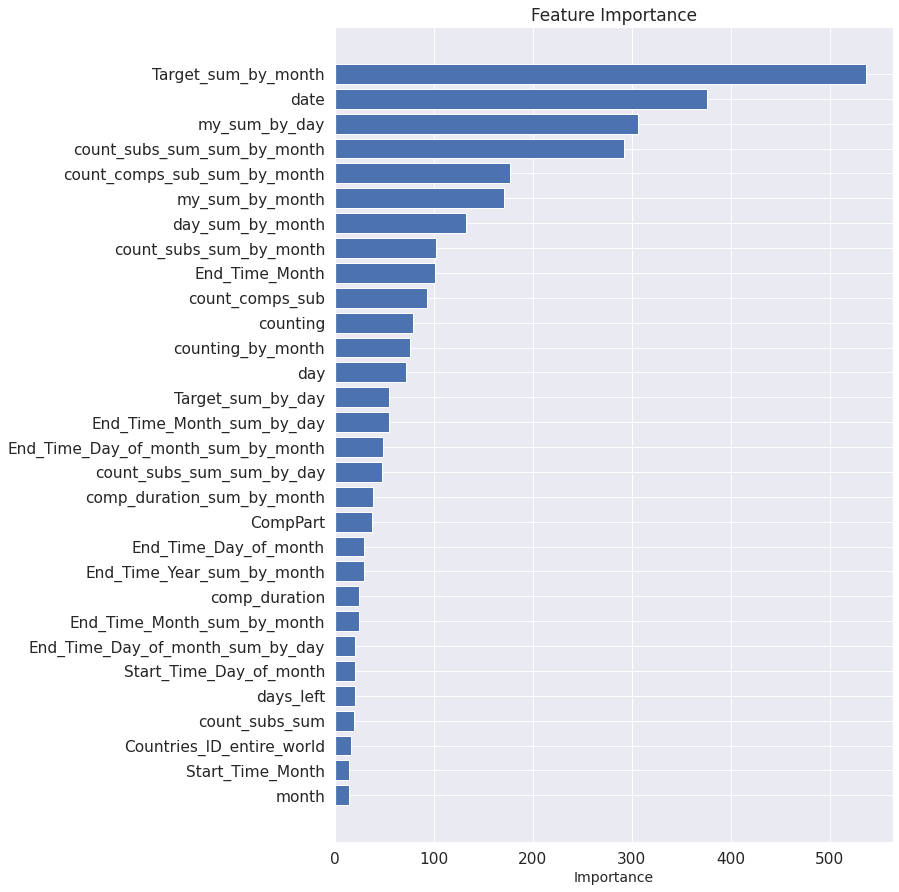

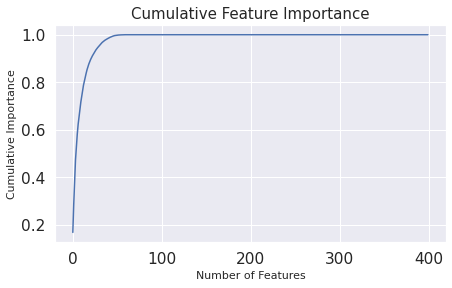

45 Features accounts for 99.3% of the cumulative importance.
TEST AUC TARGET1 CLUSTER 3: 0.9906349529890028

[[3547   12]
 [ 162  530]] 

              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98      3559
         1.0       0.98      0.77      0.86       692

    accuracy                           0.96      4251
   macro avg       0.97      0.88      0.92      4251
weighted avg       0.96      0.96      0.96      4251



In [257]:
test_auc1c3 = roc_auc_score(y.values.reshape(-1,1), oof_predictions1c3.reshape(-1,1))
importantx1c3 = get_importance_plot(feature_importances1c3, list(X.columns))

print(f'TEST AUC TARGET1 CLUSTER 3: {test_auc1c3}\n')
oof_pred1_01c3 = np.round(oof_predictions1c3,0)
print(metrics.confusion_matrix(y.values.reshape(-1,1), oof_pred1_01c3), '\n')
print(metrics.classification_report(y.values.reshape(-1,1), oof_pred1_01c3))

all_ys.append(y.values.reshape(-1,1))
all_preds.append(oof_predictions1c3)

In [258]:
# MERGING AND REORDERING OF TEST PREDICTIONS FOR 1 MONTH AHEAD
for_test_c1['target1'] = test_predictions1c1
for_test_c2['target1'] = test_predictions1c2
for_test_c3['target1'] = test_predictions1c3
for_test_c123 = for_test_c1[['User_ID','target1']].append(for_test_c2[['User_ID','target1']]).append(for_test_c3[['User_ID','target1']])
#for_test_c123 = for_test_c123.set_index('User_ID').reindex(for_test_user_order.index)
for_test_c123 = for_test_c123.reset_index()
test_predictions1 = for_test_c123['target1'].values.reshape(-1,1)

del for_test_c123, for_test_c1['target1'], for_test_c2['target1'], for_test_c3
gc.collect()

9127

In [259]:
# MERGING AND REORDERING OF FINAL_TEST PREDICTIONS FOR 1 MONTH AHEAD
final_test_for_submission = pd.DataFrame([])

final_test_for_submission['User_ID'] = test['User_ID']
final_test_for_submission['month'] = test['month']
final_test_for_submission['target1c1'] = final_test_predictions1c1
final_test_for_submission['target1c2'] = final_test_predictions1c2
final_test_for_submission['target1c3'] = final_test_predictions1c3

del final_test_predictions1c1, final_test_predictions1c2, final_test_predictions1c3
gc.collect()

23

### Target 2 Cluster 1

In [260]:
for_test_c2 = for_test[~for_test['User_ID'].isin(c1)]
print(for_test_c2.shape)

(12134, 402)


In [261]:
FS = False
features2 = []
drop = ['year']

In [262]:
target = 'target2'
if FS:
    X = train_2[features2]
    for_test_2 = for_test[features2]
    final_test_2 = test[for_test_2.columns]
else: 
    X = train2_c1.drop(['User_ID', target]+drop,1)
    for_test_2 = for_test_c1.drop(['User_ID']+drop,1)
    final_test_2 = test[for_test_2.columns]
    
y = train2_c1[[target]]

print(X.shape, y.shape, for_test_2.shape)

(48869, 400) (48869, 1) (2800, 400)


In [263]:
%%time
final_test_predictions2c1, test_predictions2c1, oof_predictions2c1, feature_importances2c1 = evaluate_lgb(X, y, for_test_2, final_test_2,
                                                                             cv=5, 
                                                                             params_lgbm=params_lgbm2,
                                                                             prefix='target2c1',
                                                                             task=task, path=model_path)

Training Data:  (39095, 400) (39095, 1)
Validation Data:  (9774, 400) (9774, 1) 


 ******* Training fold 1 ******* 

[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.991666	training's binary_logloss: 0.233216	valid_1's auc: 0.987039	valid_1's binary_logloss: 0.247628
[200]	training's auc: 0.993173	training's binary_logloss: 0.139313	valid_1's auc: 0.988057	valid_1's binary_logloss: 0.162151
[300]	training's auc: 0.994235	training's binary_logloss: 0.105528	valid_1's auc: 0.988722	valid_1's binary_logloss: 0.134798
[400]	training's auc: 0.995062	training's binary_logloss: 0.0902694	valid_1's auc: 0.989036	valid_1's binary_logloss: 0.125185
[500]	training's auc: 0.995773	training's binary_logloss: 0.0816181	valid_1's auc: 0.989146	valid_1's binary_logloss: 0.122085
[600]	training's auc: 0.99629	training's binary_logloss: 0.07629	v

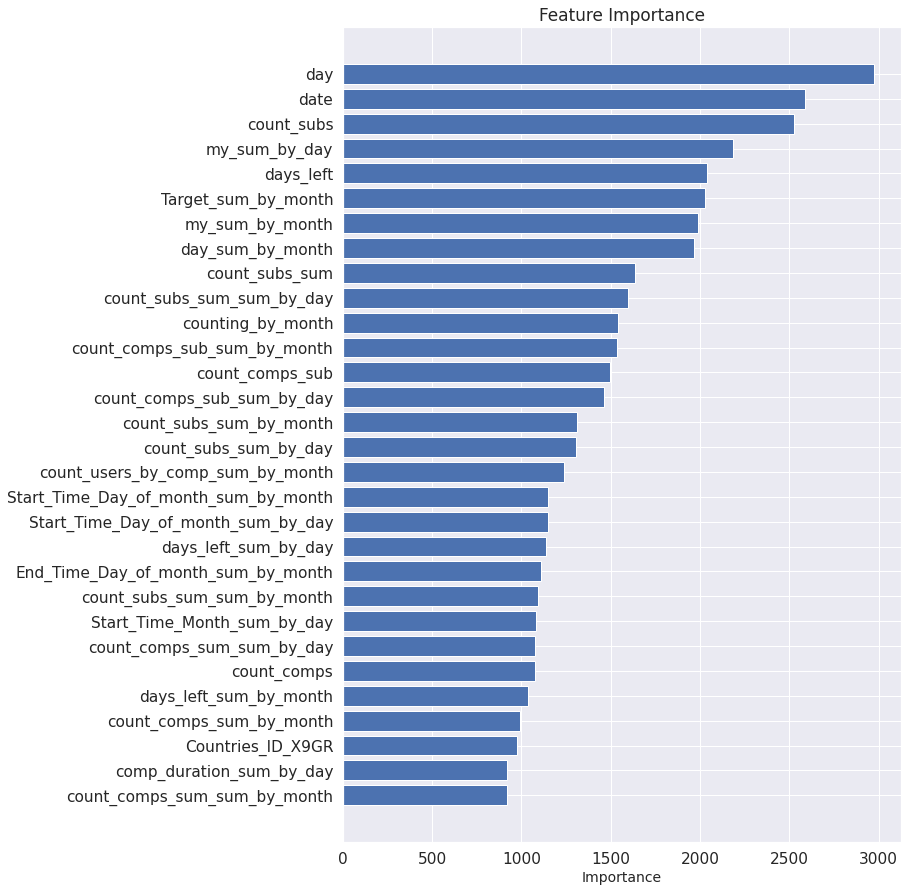

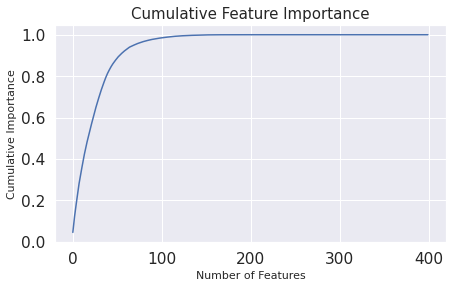

117 Features accounts for 99.3% of the cumulative importance.
TEST AUC TARGET2 CLUSTER 1: 0.9910553259050364

[[13097  1080]
 [ 1425 33267]] 

              precision    recall  f1-score   support

         0.0       0.90      0.92      0.91     14177
         1.0       0.97      0.96      0.96     34692

    accuracy                           0.95     48869
   macro avg       0.94      0.94      0.94     48869
weighted avg       0.95      0.95      0.95     48869



In [264]:
test_auc2c1 = roc_auc_score(y.values.reshape(-1,1), oof_predictions2c1.reshape(-1,1))
importantx2c1 = get_importance_plot(feature_importances2c1, list(X.columns))

print(f'TEST AUC TARGET2 CLUSTER 1: {test_auc2c1}\n')
oof_pred2_01c1 = np.round(oof_predictions2c1,0)
print(metrics.confusion_matrix(y.values.reshape(-1,1), oof_pred2_01c1), '\n')
print(metrics.classification_report(y.values.reshape(-1,1), oof_pred2_01c1))

all_ys.append(y.values.reshape(-1,1))
all_preds.append(oof_predictions2c1)

### Target 2 Cluster 2

In [265]:
FS = False
features2 = []
drop = ['year']

In [266]:
target = 'target2'
if FS:
    X = train_2[features2]
    for_test_2 = for_test[features2]
    final_test_2 = test[for_test_2.columns]
else: 
    # DROPPING USERID, TARGET AND OUTLIERS
    X = train_2.drop(['User_ID', target]+drop,1).drop(out2, 0)
    for_test_2 = for_test_c2.drop(['User_ID']+drop,1)
    final_test_2 = test[for_test_2.columns]
    
y = train_2[[target]].drop(out2, 0)

print(X.shape, y.shape, for_test_2.shape)

(48769, 400) (48769, 1) (12134, 400)


In [267]:
%%time
final_test_predictions2c2, test_predictions2c2, oof_predictions2c2, feature_importances2c2 = evaluate_lgb(X, y, for_test_2, final_test_2,
                                                                             cv=5, 
                                                                             params_lgbm=params_lgbm2,
                                                                             prefix='target2c2',
                                                                             task=task, path=model_path)

Training Data:  (39015, 400) (39015, 1)
Validation Data:  (9754, 400) (9754, 1) 


 ******* Training fold 1 ******* 

[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.993408	training's binary_logloss: 0.232077	valid_1's auc: 0.992792	valid_1's binary_logloss: 0.234686
[200]	training's auc: 0.995199	training's binary_logloss: 0.129485	valid_1's auc: 0.993908	valid_1's binary_logloss: 0.136297
[300]	training's auc: 0.996152	training's binary_logloss: 0.0926625	valid_1's auc: 0.994275	valid_1's binary_logloss: 0.104414
[400]	training's auc: 0.996796	training's binary_logloss: 0.0767394	valid_1's auc: 0.994474	valid_1's binary_logloss: 0.0928681
[500]	training's auc: 0.99717	training's binary_logloss: 0.0694315	valid_1's auc: 0.994645	valid_1's binary_logloss: 0.0882238
[600]	training's auc: 0.997336	training's binary_logloss: 0.0663

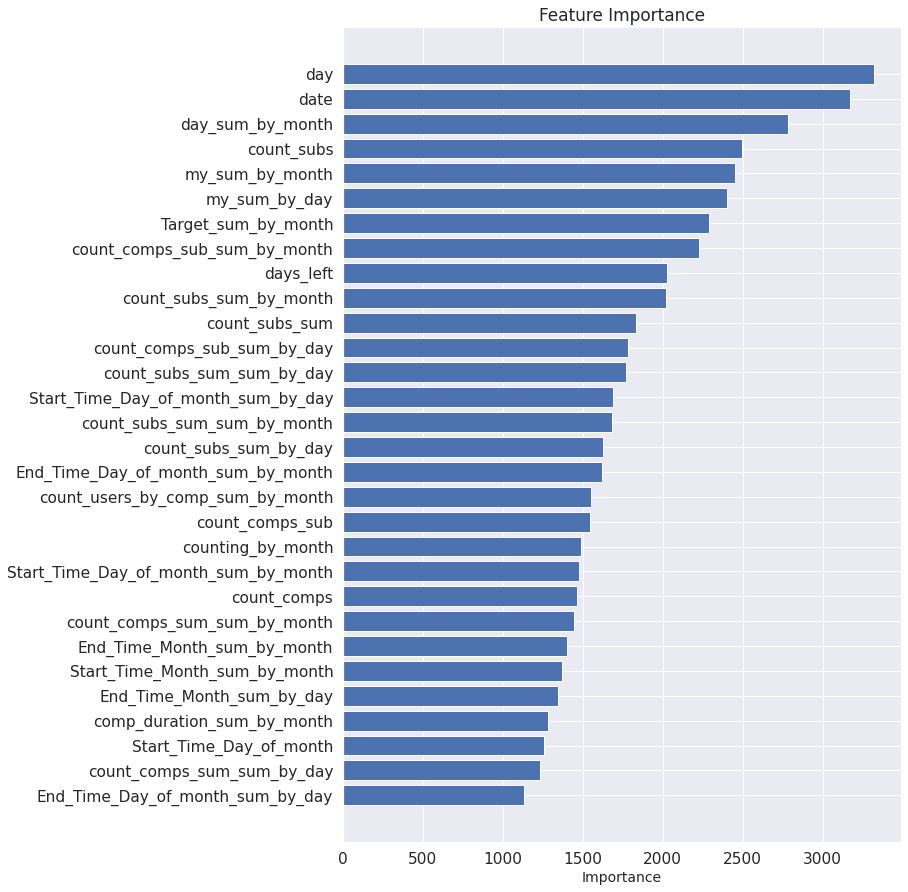

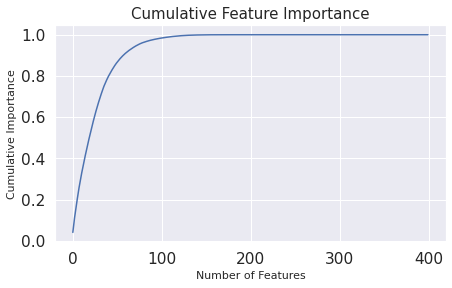

116 Features accounts for 99.3% of the cumulative importance.
TEST AUC TARGET2 CLUSTER 2: 0.9944590368255772

[[14896   777]
 [ 1154 31942]] 

              precision    recall  f1-score   support

         0.0       0.93      0.95      0.94     15673
         1.0       0.98      0.97      0.97     33096

    accuracy                           0.96     48769
   macro avg       0.95      0.96      0.95     48769
weighted avg       0.96      0.96      0.96     48769



In [268]:
test_auc2c2 = roc_auc_score(y.values.reshape(-1,1), oof_predictions2c2.reshape(-1,1))
importantx2c2 = get_importance_plot(feature_importances2c2, list(X.columns))

print(f'TEST AUC TARGET2 CLUSTER 2: {test_auc2c2}\n')
oof_pred2_01c2 = np.round(oof_predictions2c2,0)
print(metrics.confusion_matrix(y.values.reshape(-1,1), oof_pred2_01c2), '\n')
print(metrics.classification_report(y.values.reshape(-1,1), oof_pred2_01c2))

all_ys.append(y.values.reshape(-1,1))
all_preds.append(oof_predictions2c2)

In [269]:
# MERGING AND REORDERING OF TEST PREDICTIONS FOR 2 MONTHS AHEAD
for_test_c1['target2'] = test_predictions2c1
for_test_c2['target2'] = test_predictions2c2
for_test_c12 = for_test_c1[['User_ID','target2']].append(for_test_c2[['User_ID','target2']])
#for_test_c12 = for_test_c12.set_index('User_ID').reindex(for_test_user_order.index)
for_test_c12 = for_test_c12.reset_index()
test_predictions2 = for_test_c12['target2'].values.reshape(-1,1)

del for_test_c12, for_test_c1['target2'], for_test_c2['target2']
gc.collect()

9279

In [270]:
# MERGING AND REORDERING OF FINAL_TEST PREDICTIONS FOR 2 MONTH AHEAD

final_test_for_submission['target2c1'] = final_test_predictions2c1
final_test_for_submission['target2c2'] = final_test_predictions2c2

del final_test_predictions2c1, final_test_predictions2c2
gc.collect()

23

### Target 3 Cluster 1

In [271]:
FS = False
features3 = []
drop = ['year']
target = 'target3'

if FS:
    X = train3_c1[features3]
    for_test_3 = for_test_c1[features3]
    final_test_3 = test[for_test_3.columns]
else: 
    X = train3_c1.drop(['User_ID', target]+drop,1)
    for_test_3 = for_test_c1.drop(['User_ID']+drop,1)
    final_test_3 = test[for_test_3.columns]
    
y = train3_c1[[target]]

print(X.shape, y.shape, for_test_3.shape)

(45418, 400) (45418, 1) (2800, 400)


In [272]:
%%time
final_test_predictions3c1, test_predictions3c1, oof_predictions3c1, feature_importances3c1 = evaluate_lgb(X, y, for_test_3, final_test_3,
                                                                             cv=5, 
                                                                             params_lgbm=params_lgbm3,
                                                                             prefix='target3c1',
                                                                             task=task, path=model_path)

Training Data:  (36334, 400) (36334, 1)
Validation Data:  (9084, 400) (9084, 1) 


 ******* Training fold 1 ******* 

[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.988732	training's binary_logloss: 0.254439	valid_1's auc: 0.985211	valid_1's binary_logloss: 0.262045
[200]	training's auc: 0.990356	training's binary_logloss: 0.161568	valid_1's auc: 0.986454	valid_1's binary_logloss: 0.174552
[300]	training's auc: 0.991912	training's binary_logloss: 0.124864	valid_1's auc: 0.987575	valid_1's binary_logloss: 0.142679
[400]	training's auc: 0.993111	training's binary_logloss: 0.106912	valid_1's auc: 0.988299	valid_1's binary_logloss: 0.129421
[500]	training's auc: 0.993942	training's binary_logloss: 0.0969037	valid_1's auc: 0.988753	valid_1's binary_logloss: 0.122864
[600]	training's auc: 0.994595	training's binary_logloss: 0.090853	

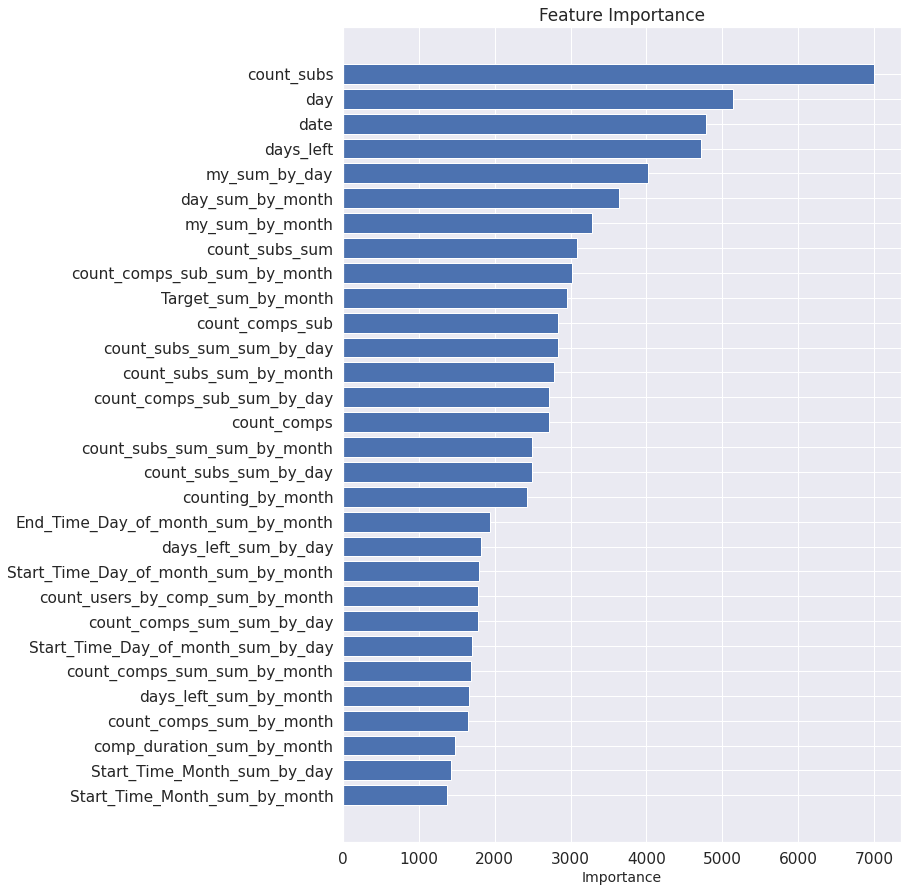

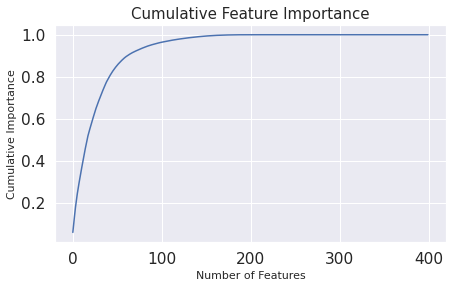

148 Features accounts for 99.3% of the cumulative importance.
TEST AUC TARGET3 CLUSTER 1: 0.9902198561989081

[[11143  1117]
 [ 1244 31914]] 

              precision    recall  f1-score   support

         0.0       0.90      0.91      0.90     12260
         1.0       0.97      0.96      0.96     33158

    accuracy                           0.95     45418
   macro avg       0.93      0.94      0.93     45418
weighted avg       0.95      0.95      0.95     45418



In [273]:
test_auc3c1 = roc_auc_score(y.values.reshape(-1,1), oof_predictions3c1.reshape(-1,1))
importantx3c1 = get_importance_plot(feature_importances3c1, list(X.columns))

print(f'TEST AUC TARGET3 CLUSTER 1: {test_auc3c1}\n')
oof_pred3_01c1 = np.round(oof_predictions3c1,0)
print(metrics.confusion_matrix(y.values.reshape(-1,1), oof_pred3_01c1), '\n')
print(metrics.classification_report(y.values.reshape(-1,1), oof_pred3_01c1))

all_ys.append(y.values.reshape(-1,1))
all_preds.append(oof_predictions3c1)

### Target 3 Cluster 2

In [274]:
FS = False
features3 = []
drop = ['year']
target = 'target3'

if FS:
    X = train_3[features3]
    for_test_3 = for_test_c2[features3]
    final_test_3 = test[for_test_3.columns]
else: 
    X = train_3.drop(['User_ID', target]+drop,1)
    for_test_3 = for_test_c2.drop(['User_ID']+drop,1)
    final_test_3 = test[for_test_3.columns]
    
y = train_3[[target]]

print(X.shape, y.shape, for_test_3.shape)

(46369, 400) (46369, 1) (12134, 400)


In [275]:
%%time
final_test_predictions3c2, test_predictions3c2, oof_predictions3c2, feature_importances3c2 = evaluate_lgb(X, y, for_test_3, final_test_3,
                                                                             cv=5, 
                                                                             params_lgbm=params_lgbm3,
                                                                             prefix='target3c2',
                                                                             task=task, path=model_path)

Training Data:  (37095, 400) (37095, 1)
Validation Data:  (9274, 400) (9274, 1) 


 ******* Training fold 1 ******* 

[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.98877	training's binary_logloss: 0.258164	valid_1's auc: 0.986301	valid_1's binary_logloss: 0.263905
[200]	training's auc: 0.990571	training's binary_logloss: 0.163056	valid_1's auc: 0.98778	valid_1's binary_logloss: 0.173867
[300]	training's auc: 0.992027	training's binary_logloss: 0.125631	valid_1's auc: 0.988468	valid_1's binary_logloss: 0.141355
[400]	training's auc: 0.993151	training's binary_logloss: 0.107732	valid_1's auc: 0.98914	valid_1's binary_logloss: 0.12728
[500]	training's auc: 0.993973	training's binary_logloss: 0.0976054	valid_1's auc: 0.989446	valid_1's binary_logloss: 0.121002
[600]	training's auc: 0.994657	training's binary_logloss: 0.0910233	val

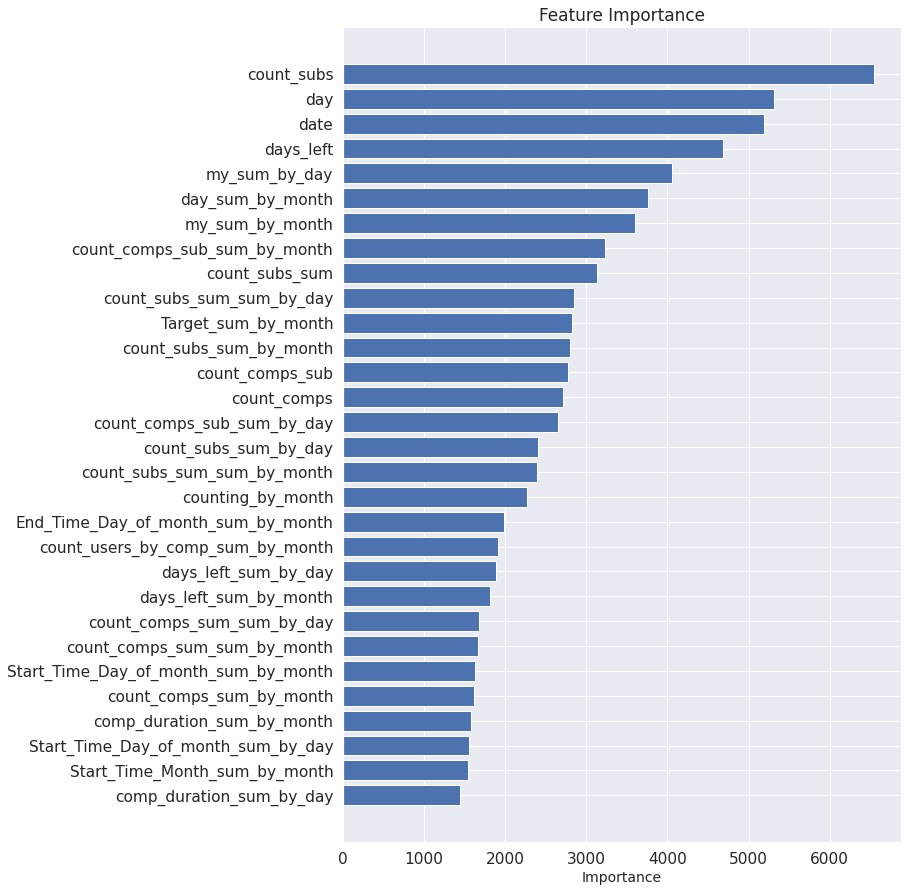

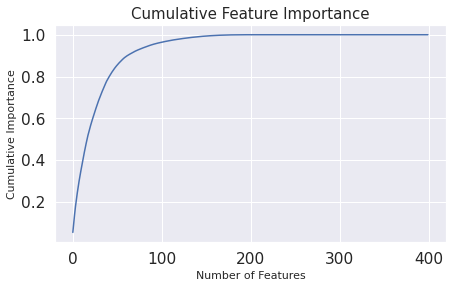

148 Features accounts for 99.3% of the cumulative importance.
TEST AUC TARGET3 CLUSTER 2: 0.9904967532701322

[[11805  1143]
 [ 1271 32150]] 

              precision    recall  f1-score   support

         0.0       0.90      0.91      0.91     12948
         1.0       0.97      0.96      0.96     33421

    accuracy                           0.95     46369
   macro avg       0.93      0.94      0.94     46369
weighted avg       0.95      0.95      0.95     46369



In [276]:
test_auc3c2 = roc_auc_score(y.values.reshape(-1,1), oof_predictions3c2.reshape(-1,1))
importantx3c2 = get_importance_plot(feature_importances3c2, list(X.columns))

print(f'TEST AUC TARGET3 CLUSTER 2: {test_auc3c2}\n')
oof_pred3_01c2 = np.round(oof_predictions3c2,0)
print(metrics.confusion_matrix(y.values.reshape(-1,1), oof_pred3_01c2), '\n')
print(metrics.classification_report(y.values.reshape(-1,1), oof_pred3_01c2))

all_ys.append(y.values.reshape(-1,1))
all_preds.append(oof_predictions3c2)

In [277]:
# MERGING AND REORDERING OF TEST PREDICTIONS FOR 3 MONTHS AHEAD
for_test_c1['target3'] = test_predictions3c1
for_test_c2['target3'] = test_predictions3c2
for_test_c12 = for_test_c1[['User_ID','target3']].append(for_test_c2[['User_ID','target3']])
#for_test_c12 = for_test_c12.set_index('User_ID').reindex(for_test_user_order.index)
for_test_c12 = for_test_c12.reset_index()
test_predictions3 = for_test_c12['target3'].values.reshape(-1,1)

del for_test_c12, for_test_c1, for_test_c2
gc.collect()

9203

In [278]:
# MERGING AND REORDERING OF FINAL_TEST PREDICTIONS FOR 2 MONTH AHEAD

final_test_for_submission['target3c1'] = final_test_predictions3c1
final_test_for_submission['target3c2'] = final_test_predictions3c2

del final_test_predictions3c1, final_test_predictions3c2
gc.collect()

23

In [279]:
# DELETE OLD VARIABLES
del for_test_1, for_test_2, for_test_3, X, y

---

### OUT OF FOLD CV SCORE

In [280]:
all_ys = np.vstack(all_ys)
all_preds = np.vstack(all_preds)

test_auc = roc_auc_score(all_ys,all_preds)

print(f'TEST AUC: {test_auc}\n')
oof_preds = np.round(all_preds,0)
print(metrics.confusion_matrix(all_ys, oof_preds), '\n')
print(metrics.classification_report(all_ys, oof_preds))

TEST AUC: 0.9937355706314401

[[ 89868   5136]
 [  7109 198369]] 

              precision    recall  f1-score   support

         0.0       0.93      0.95      0.94     95004
         1.0       0.97      0.97      0.97    205478

    accuracy                           0.96    300482
   macro avg       0.95      0.96      0.95    300482
weighted avg       0.96      0.96      0.96    300482



In [281]:
print(f'TEST AUC TARGET1 C1: {test_auc1c1}')
print(f'TEST AUC TARGET1 C2: {test_auc1c2}')
print(f'TEST AUC TARGET1 C3: {test_auc1c3}\n')
print(f'TEST AUC TARGET2 C1: {test_auc2c1}')
print(f'TEST AUC TARGET2 C2: {test_auc2c2}\n')
print(f'TEST AUC TARGET3 C1: {test_auc3c1}')
print(f'TEST AUC TARGET3 C2: {test_auc3c2}\n')

TEST AUC TARGET1 C1: 0.9944508568260313
TEST AUC TARGET1 C2: 0.9973252020297221
TEST AUC TARGET1 C3: 0.9906349529890028

TEST AUC TARGET2 C1: 0.9910553259050364
TEST AUC TARGET2 C2: 0.9944590368255772

TEST AUC TARGET3 C1: 0.9902198561989081
TEST AUC TARGET3 C2: 0.9904967532701322



---

### GETTING PREDICTIONS INTO SUBMISSION FORMAT

In [282]:
for_test_users = for_test['User_ID']

In [283]:
test_predictions = np.concatenate([test_predictions1, test_predictions2, test_predictions3], axis=1)
print(test_predictions.shape)
test_predictions

(14934, 3)


array([[0.99378245, 0.9814367 , 0.98345111],
       [0.99375223, 0.98629212, 0.98730743],
       [0.99861206, 0.99958626, 0.99997451],
       ...,
       [0.09653271, 0.97172448, 0.97345363],
       [0.09653271, 0.99908058, 0.93127941],
       [0.74970182, 0.29700004, 0.44044027]])

In [284]:
# ADD PREDICTIONS TO TEST SET
for_test[['target1', 'target2', 'target3']] = test_predictions
for_test['User_ID'] = for_test_users
for_test = for_test.sort_values('User_ID')
for_test

,CompPart,CompPart_shift1,CompPart_shift2,CompPart_shift3,Comp_ID_ID_0D02,Comp_ID_ID_0SN1,Comp_ID_ID_0W7H,Comp_ID_ID_0Y9T,Comp_ID_ID_1261,Comp_ID_ID_1CTF,Comp_ID_ID_1DWD,Comp_ID_ID_1Q60,Comp_ID_ID_1ZWS,Comp_ID_ID_208Z,Comp_ID_ID_20XL,Comp_ID_ID_2MIC,Comp_ID_ID_3AG0,Comp_ID_ID_3MK3,Comp_ID_ID_3RMM,Comp_ID_ID_44CX,Comp_ID_ID_45W9,Comp_ID_ID_51ZG,Comp_ID_ID_528W,Comp_ID_ID_53GM,Comp_ID_ID_540G,Comp_ID_ID_56O8,Comp_ID_ID_5KD8,Comp_ID_ID_5NAE,Comp_ID_ID_61E9,Comp_ID_ID_64EM,Comp_ID_ID_66QC,Comp_ID_ID_6E1C,Comp_ID_ID_6IDY,Comp_ID_ID_7079,Comp_ID_ID_7CF2,Comp_ID_ID_7YDI,Comp_ID_ID_89DI,Comp_ID_ID_8B8I,Comp_ID_ID_8BH9,Comp_ID_ID_8DGC,Comp_ID_ID_8SHD,Comp_ID_ID_9BU8,Comp_ID_ID_9TS1,Comp_ID_ID_A1ZA,Comp_ID_ID_AL6C,Comp_ID_ID_AS79,Comp_ID_ID_BARV,Comp_ID_ID_BR9A,Comp_ID_ID_BXIL,Comp_ID_ID_BZV0,Comp_ID_ID_CFN7,Comp_ID_ID_CMWO,Comp_ID_ID_CNBR,Comp_ID_ID_CR6P,Comp_ID_ID_CVUS,Comp_ID_ID_CYEF,Comp_ID_ID_D242,Comp_ID_ID_D3SA,Comp_ID_ID_D6NX,Comp_ID_ID_DD5S,Comp_ID_ID_DFKK,Comp_ID_ID_E1KX,Comp_ID_ID_F5JG,Comp_ID_ID_F7QD,Comp_ID_ID_FCRM,Comp_ID_ID_FM77,Comp_ID_ID_FN7K,Comp_ID_ID_FZ48,Comp_ID_ID_G05Z,Comp_ID_ID_G5IQ,Comp_ID_ID_GAV9,Comp_ID_ID_GR92,Comp_ID_ID_GVGW,Comp_ID_ID_GWL0,Comp_ID_ID_H3QQ,Comp_ID_ID_HCN1,Comp_ID_ID_HCST,Comp_ID_ID_HGJN,Comp_ID_ID_I9BN,Comp_ID_ID_IMTG,Comp_ID_ID_IQLI,Comp_ID_ID_IV5D,Comp_ID_ID_IVH9,Comp_ID_ID_J5IZ,Comp_ID_ID_J883,Comp_ID_ID_JRC2,Comp_ID_ID_JX23,Comp_ID_ID_KESL,Comp_ID_ID_KGUF,Comp_ID_ID_KHED,Comp_ID_ID_KU2G,Comp_ID_ID_L3EB,Comp_ID_ID_L9R0,Comp_ID_ID_LFJT,Comp_ID_ID_LSIO,Comp_ID_ID_M3G0,Comp_ID_ID_MN35,Comp_ID_ID_N5MO,Comp_ID_ID_NKJR,Comp_ID_ID_OAR6,...,FeatureE_3.0,FeatureE_sum_by_day,FeatureE_sum_by_month,FeatureX_0.0,FeatureX_1.0,FeatureX_sum_by_day,FeatureX_sum_by_month,FeatureY_0.0,FeatureY_1.0,FeatureY_3.0,FeatureY_sum_by_day,FeatureY_sum_by_month,Personal,Personal_sum_by_day,Personal_sum_by_month,Start_Time_Day_of_month,Start_Time_Day_of_month_sum_by_day,Start_Time_Day_of_month_sum_by_month,Start_Time_Month,Start_Time_Month_sum_by_day,Start_Time_Month_sum_by_month,Sub,Sub_shift1,Sub_shift2,Sub_shift3,Sub_sum,Sub_sum_by_day,Sub_sum_by_month,Sub_sum_sum_by_day,Sub_sum_sum_by_month,Target,Target_shift1,Target_shift2,Target_shift3,Target_sum_by_day,Target_sum_by_month,Theme,Theme_sum_by_day,Theme_sum_by_month,User_ID,comp_duration,comp_duration_sum_by_day,comp_duration_sum_by_month,count_blogs,count_blogs_sum,count_blogs_sum_by_day,count_blogs_sum_by_month,count_blogs_sum_sum_by_day,count_blogs_sum_sum_by_month,count_comments,count_comments_sum_by_day,count_comments_sum_by_month,count_comps,count_comps_sub,count_comps_sub_sum_by_day,count_comps_sub_sum_by_month,count_comps_sum,count_comps_sum_by_day,count_comps_sum_by_month,count_comps_sum_sum_by_day,count_comps_sum_sum_by_month,count_subs,count_subs_sum,count_subs_sum_by_day,count_subs_sum_by_month,count_subs_sum_sum_by_day,count_subs_sum_sum_by_month,count_users_by_comp,count_users_by_comp_sum_by_day,count_users_by_comp_sum_by_month,counting,counting_by_month,date,day,day_sum_by_month,days_left,days_left_sum_by_day,days_left_sum_by_month,feature_A_,feature_A_1,feature_A_1_sum_by_day,feature_A_1_sum_by_month,feature_A_4,feature_A_5,feature_A_5_sum_by_day,feature_A_5_sum_by_month,feature_A__sum_by_month,feature_F_2,feature_F_2_sum_by_day,feature_F_2_sum_by_month,feature_G_,feature_G__sum_by_day,feature_G__sum_by_month,month,my_sum_by_day,my_sum_by_month,year,target1,target2,target3
80935,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0.0,0.0,1,0,0.0,0.0,0,1,0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ID_000H9XOP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,6.0,0.0,0.0,1.0,0.0,1.0,1.0,5.0,1.0,2.0,5.0,6.0,0.0,0.0,0.0,1,2,204,22,48,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10,20

In [285]:
# RESHAPE PREDICTIONS INTO 1D ARRAY OF LENGTH TESTSET X 3
targets_reshaped = for_test[['target1', 'target2', 'target3']].values.reshape(-1,1)
targets_reshaped.shape

(44802, 1)

In [286]:
# CREATE 3 COPIES OF EACH USERID SAMPLE IN TESTSET
for_test = for_test.append([for_test]*2,ignore_index=True).sort_values('User_ID')
# ADD PREDICTIONS TO TESTSET
for_test['Target'] = targets_reshaped
# SELECT ONLY THE COLUMNS WE NEED
cols = ['User_ID','day', 'month', 'year', 'Target']
for_test = for_test[cols].reset_index(drop=True)
display(for_test)

,User_ID,day,month,year,Target
0,ID_000H9XOP,22,10,1,0.999203
1,ID_000H9XOP,22,10,1,0.963962
2,ID_000H9XOP,26,10,1,0.976235
3,ID_000H9XOP,22,10,1,0.212245
4,ID_000H9XOP,26,10,1,0.997824
...,...,...,...,...,...
44797,ID_ZZFZI3DK,5,10,1,0.762252
44798,ID_ZZFZI3DK,4,10,1,0.814473
44799,ID_ZZFZI3DK,4,10,1,0.998612
44800,ID_ZZFZI3DK,5,10,1,0.999582


In [287]:
for Target in ['target1c1', 'target1c2', 'target1c3', 'target2c1', 'target2c2', 'target3c1', 'target3c2']:
    final_test_for_submission[Target][final_test_for_submission[Target]>0.5]=1
    final_test_for_submission[Target][final_test_for_submission[Target]<=0.5]=0
    
final_test_for_submission = final_test_for_submission.drop_duplicates()

final_test_for_submission['User_ID_Next_month_Activity'] = [x+'_Month_5'  for x in final_test_for_submission.User_ID]

In [288]:
display(final_test_for_submission[['target1c1', 'target1c2', 'target1c3', 'target2c1', 'target2c2', 'target3c1', 'target3c2']].sum())
final_test_for_submission.shape

target1c1    368.0
target1c2    396.0
target1c3    443.0
target2c1    386.0
target2c2    399.0
target3c1    536.0
target3c2    477.0
dtype: float64

(1503, 10)

In [289]:
display(final_test_for_submission)

,User_ID,month,target1c1,target1c2,target1c3,target2c1,target2c2,target3c1,target3c2,User_ID_Next_month_Activity
0,ID_39PBR6FN,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ID_39PBR6FN_Month_5
12,ID_39PBR6FN,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ID_39PBR6FN_Month_5
18,ID_EOMLYHOK,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ID_EOMLYHOK_Month_5
33,ID_CJKAYZ5Z,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ID_CJKAYZ5Z_Month_5
34,ID_RHLBATWR,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ID_RHLBATWR_Month_5
...,...,...,...,...,...,...,...,...,...,...
4196,ID_ZCIE3QEA,9,1.0,1.0,1.0,1.0,1.0,1.0,1.0,ID_ZCIE3QEA_Month_5
4197,ID_938EZZ0U,9,0.0,0.0,0.0,0.0,0.0,1.0,0.0,ID_938EZZ0U_Month_5
4198,ID_VTWGITIF,9,0.0,0.0,0.0,0.0,0.0,1.0,0.0,ID_VTWGITIF_Month_5
4199,ID_VYAE10S9,9,0.0,0.0,0.0,0.0,0.0,1.0,0.0,ID_VYAE10S9_Month_5


In [290]:
submission = pd.DataFrame([])
submission['User_ID_Next_month_Activity'] = final_test_for_submission['User_ID_Next_month_Activity']

for Target in ['target1c1', 'target1c2', 'target1c3', 'target2c1', 'target2c2', 'target3c1', 'target3c2']:
    submission['Active'] = final_test_for_submission[Target].astype(int)
    submission.to_csv(Target+'.csv',index=False)
    display(Counter(submission.Active))

Counter({0: 1135, 1: 368})

Counter({0: 1107, 1: 396})

Counter({0: 1060, 1: 443})

Counter({0: 1117, 1: 386})

Counter({0: 1104, 1: 399})

Counter({0: 967, 1: 536})

Counter({0: 1026, 1: 477})

---

## LIGHT GBM _ NO.2
## Predicting for unseen users

#### There seems to be users in the provided test dataframe for which we have no data on in the train dataframe. We still need predictions for these users and will need to create a training set similar to these new users.

In [291]:
# LOAD IN SAVED TRAIN
train = pd.read_feather('./feathers/train.feather')
# LOAD IN SAVED TEST
test = pd.read_feather('./feathers/test.feather')

#### THE UNSEEN NEW USERS

In [292]:
# unseen_test_users = list(set(test['User_ID'])  - set(train['User_ID']))
# unseen_test_users_df = users[users['User_ID'].isin(unseen_test_users)]
unseen_test_users_df = test.copy()
display(unseen_test_users_df.head(2), unseen_test_users_df.shape)

,CompPart,CompPart_shift1,CompPart_shift2,CompPart_shift3,Comp_ID_ID_0D02,Comp_ID_ID_0SN1,Comp_ID_ID_0W7H,Comp_ID_ID_0Y9T,Comp_ID_ID_1261,Comp_ID_ID_1CTF,Comp_ID_ID_1DWD,Comp_ID_ID_1Q60,Comp_ID_ID_1ZWS,Comp_ID_ID_208Z,Comp_ID_ID_20XL,Comp_ID_ID_2MIC,Comp_ID_ID_3AG0,Comp_ID_ID_3MK3,Comp_ID_ID_3RMM,Comp_ID_ID_44CX,Comp_ID_ID_45W9,Comp_ID_ID_51ZG,Comp_ID_ID_528W,Comp_ID_ID_53GM,Comp_ID_ID_540G,Comp_ID_ID_56O8,Comp_ID_ID_5KD8,Comp_ID_ID_5NAE,Comp_ID_ID_61E9,Comp_ID_ID_64EM,Comp_ID_ID_66QC,Comp_ID_ID_6E1C,Comp_ID_ID_6IDY,Comp_ID_ID_7079,Comp_ID_ID_7CF2,Comp_ID_ID_7YDI,Comp_ID_ID_89DI,Comp_ID_ID_8B8I,Comp_ID_ID_8BH9,Comp_ID_ID_8DGC,Comp_ID_ID_8SHD,Comp_ID_ID_9BU8,Comp_ID_ID_9TS1,Comp_ID_ID_A1ZA,Comp_ID_ID_AL6C,Comp_ID_ID_AS79,Comp_ID_ID_BARV,Comp_ID_ID_BR9A,Comp_ID_ID_BXIL,Comp_ID_ID_BZV0,Comp_ID_ID_CFN7,Comp_ID_ID_CMWO,Comp_ID_ID_CNBR,Comp_ID_ID_CR6P,Comp_ID_ID_CVUS,Comp_ID_ID_CYEF,Comp_ID_ID_D242,Comp_ID_ID_D3SA,Comp_ID_ID_D6NX,Comp_ID_ID_DD5S,Comp_ID_ID_DFKK,Comp_ID_ID_E1KX,Comp_ID_ID_F5JG,Comp_ID_ID_F7QD,Comp_ID_ID_FCRM,Comp_ID_ID_FM77,Comp_ID_ID_FN7K,Comp_ID_ID_FZ48,Comp_ID_ID_G05Z,Comp_ID_ID_G5IQ,Comp_ID_ID_GAV9,Comp_ID_ID_GR92,Comp_ID_ID_GVGW,Comp_ID_ID_GWL0,Comp_ID_ID_H3QQ,Comp_ID_ID_HCN1,Comp_ID_ID_HCST,Comp_ID_ID_HGJN,Comp_ID_ID_I9BN,Comp_ID_ID_IMTG,Comp_ID_ID_IQLI,Comp_ID_ID_IV5D,Comp_ID_ID_IVH9,Comp_ID_ID_J5IZ,Comp_ID_ID_J883,Comp_ID_ID_JRC2,Comp_ID_ID_JX23,Comp_ID_ID_KESL,Comp_ID_ID_KGUF,Comp_ID_ID_KHED,Comp_ID_ID_KU2G,Comp_ID_ID_L3EB,Comp_ID_ID_L9R0,Comp_ID_ID_LFJT,Comp_ID_ID_LSIO,Comp_ID_ID_M3G0,Comp_ID_ID_MN35,Comp_ID_ID_N5MO,Comp_ID_ID_NKJR,Comp_ID_ID_OAR6,...,FeatureD_sum_by_month,FeatureE_1.0,FeatureE_2.0,FeatureE_3.0,FeatureE_sum_by_day,FeatureE_sum_by_month,FeatureX_0.0,FeatureX_1.0,FeatureX_sum_by_day,FeatureX_sum_by_month,FeatureY_0.0,FeatureY_1.0,FeatureY_3.0,FeatureY_sum_by_day,FeatureY_sum_by_month,Personal,Personal_sum_by_day,Personal_sum_by_month,Start_Time_Day_of_month,Start_Time_Day_of_month_sum_by_day,Start_Time_Day_of_month_sum_by_month,Start_Time_Month,Start_Time_Month_sum_by_day,Start_Time_Month_sum_by_month,Sub,Sub_shift1,Sub_shift2,Sub_shift3,Sub_sum,Sub_sum_by_day,Sub_sum_by_month,Sub_sum_sum_by_day,Sub_sum_sum_by_month,Target,Target_shift1,Target_shift2,Target_shift3,Target_sum_by_day,Target_sum_by_month,Theme,Theme_sum_by_day,Theme_sum_by_month,User_ID,comp_duration,comp_duration_sum_by_day,comp_duration_sum_by_month,count_blogs,count_blogs_sum,count_blogs_sum_by_day,count_blogs_sum_by_month,count_blogs_sum_sum_by_day,count_blogs_sum_sum_by_month,count_comments,count_comments_sum_by_day,count_comments_sum_by_month,count_comps,count_comps_sub,count_comps_sub_sum_by_day,count_comps_sub_sum_by_month,count_comps_sum,count_comps_sum_by_day,count_comps_sum_by_month,count_comps_sum_sum_by_day,count_comps_sum_sum_by_month,count_subs,count_subs_sum,count_subs_sum_by_day,count_subs_sum_by_month,count_subs_sum_sum_by_day,count_subs_sum_sum_by_month,count_users_by_comp,count_users_by_comp_sum_by_day,count_users_by_comp_sum_by_month,counting,counting_by_month,date,day,day_sum_by_month,days_left,days_left_sum_by_day,days_left_sum_by_month,feature_A_,feature_A_1,feature_A_1_sum_by_day,feature_A_1_sum_by_month,feature_A_4,feature_A_5,feature_A_5_sum_by_day,feature_A_5_sum_by_month,feature_A__sum_by_month,feature_F_2,feature_F_2_sum_by_day,feature_F_2_sum_by_month,feature_G_,feature_G__sum_by_day,feature_G__sum_by_month,month,my_sum_by_day,my_sum_by_month,year
0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0,0,0,0.0,0.0,0,0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ID_39PBR6FN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,8.0,45.0,4.0,2.0,6.0,8.0,23.0,2.0,8.0,4.0,19.0,16.0,71.0,0.0,0.0,0.0,2,12,9,10,181,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

(4208, 402)

In [293]:
print(set(train_1.columns) - set(train.columns), '\n')
print(set(train_1.columns) - set(test.columns))

{'target1'} 

{'target1'}


#### CREATING A TRAINSET BY TAKING THE FIRST 3 MONTHS DATA OF EACH USER IN TRAIN DATAFRAME

In [294]:
# %%time
# users = pd.read_csv(root+'Users.csv').drop_duplicates()
# users.columns = users.columns.str.replace(' ', '_')
# users = pd.get_dummies(users, columns=['FeatureY', 'FeatureX'], drop_first=False)

# train_3months_in = train.groupby('User_ID').head(3)
# train_3months_in = train_3months_in.reset_index(drop=True)
# train_vc = train_3months_in['User_ID'].value_counts().to_frame().reset_index()
# train_new_users = train_vc[train_vc['User_ID'].isin([3])]['index'].values
# train_3months_in = train_3months_in[train_3months_in['User_ID'].isin(train_new_users)]

# cols = set(['User_ID','day', 'month', 'year', 'Target'] + list(users.columns)) - set(['Countries_ID'])
# train_3months_in = train_3months_in[cols]

# cols = [c for c in train_3months_in if c not in ['User_ID', 'month','year', 'day',
#                                                  'UserDate_Month', 'UserDate_Year', 'Target']]
# train_3months_in = train_3months_in[['User_ID','day', 'month','year', 'UserDate_Month', 
#                                      'UserDate_Year', 'Target']+cols]


# train_3months_in = train_3months_in.merge(users[['User_ID','Countries_ID']], on='User_ID', how='left')
# train_3months_in = pd.get_dummies(train_3months_in, columns=['Countries_ID'])
    
# train_3months_in.reset_index(drop=True).to_feather('./feathers/train_3months_in.feather')

In [295]:
train.groupby('User_ID').head(3).shape, train.shape

((26860, 402), (83428, 402))

In [296]:
%%time

train_3months_in = train.groupby('User_ID').head(3) #################################
train_3months_in = train_3months_in.reset_index(drop=True)
train_vc = train_3months_in['User_ID'].value_counts().to_frame().reset_index()
train_new_users = train_vc[train_vc['User_ID'].isin([3])]['index'].values #################################
train_3months_in = train_3months_in[train_3months_in['User_ID'].isin(train_new_users)]
   
train_3months_in.reset_index(drop=True).to_feather('./feathers/train_3months_in.feather')
display(train_3months_in.sample(2), train_3months_in.shape) #################################

,CompPart,CompPart_shift1,CompPart_shift2,CompPart_shift3,Comp_ID_ID_0D02,Comp_ID_ID_0SN1,Comp_ID_ID_0W7H,Comp_ID_ID_0Y9T,Comp_ID_ID_1261,Comp_ID_ID_1CTF,Comp_ID_ID_1DWD,Comp_ID_ID_1Q60,Comp_ID_ID_1ZWS,Comp_ID_ID_208Z,Comp_ID_ID_20XL,Comp_ID_ID_2MIC,Comp_ID_ID_3AG0,Comp_ID_ID_3MK3,Comp_ID_ID_3RMM,Comp_ID_ID_44CX,Comp_ID_ID_45W9,Comp_ID_ID_51ZG,Comp_ID_ID_528W,Comp_ID_ID_53GM,Comp_ID_ID_540G,Comp_ID_ID_56O8,Comp_ID_ID_5KD8,Comp_ID_ID_5NAE,Comp_ID_ID_61E9,Comp_ID_ID_64EM,Comp_ID_ID_66QC,Comp_ID_ID_6E1C,Comp_ID_ID_6IDY,Comp_ID_ID_7079,Comp_ID_ID_7CF2,Comp_ID_ID_7YDI,Comp_ID_ID_89DI,Comp_ID_ID_8B8I,Comp_ID_ID_8BH9,Comp_ID_ID_8DGC,Comp_ID_ID_8SHD,Comp_ID_ID_9BU8,Comp_ID_ID_9TS1,Comp_ID_ID_A1ZA,Comp_ID_ID_AL6C,Comp_ID_ID_AS79,Comp_ID_ID_BARV,Comp_ID_ID_BR9A,Comp_ID_ID_BXIL,Comp_ID_ID_BZV0,Comp_ID_ID_CFN7,Comp_ID_ID_CMWO,Comp_ID_ID_CNBR,Comp_ID_ID_CR6P,Comp_ID_ID_CVUS,Comp_ID_ID_CYEF,Comp_ID_ID_D242,Comp_ID_ID_D3SA,Comp_ID_ID_D6NX,Comp_ID_ID_DD5S,Comp_ID_ID_DFKK,Comp_ID_ID_E1KX,Comp_ID_ID_F5JG,Comp_ID_ID_F7QD,Comp_ID_ID_FCRM,Comp_ID_ID_FM77,Comp_ID_ID_FN7K,Comp_ID_ID_FZ48,Comp_ID_ID_G05Z,Comp_ID_ID_G5IQ,Comp_ID_ID_GAV9,Comp_ID_ID_GR92,Comp_ID_ID_GVGW,Comp_ID_ID_GWL0,Comp_ID_ID_H3QQ,Comp_ID_ID_HCN1,Comp_ID_ID_HCST,Comp_ID_ID_HGJN,Comp_ID_ID_I9BN,Comp_ID_ID_IMTG,Comp_ID_ID_IQLI,Comp_ID_ID_IV5D,Comp_ID_ID_IVH9,Comp_ID_ID_J5IZ,Comp_ID_ID_J883,Comp_ID_ID_JRC2,Comp_ID_ID_JX23,Comp_ID_ID_KESL,Comp_ID_ID_KGUF,Comp_ID_ID_KHED,Comp_ID_ID_KU2G,Comp_ID_ID_L3EB,Comp_ID_ID_L9R0,Comp_ID_ID_LFJT,Comp_ID_ID_LSIO,Comp_ID_ID_M3G0,Comp_ID_ID_MN35,Comp_ID_ID_N5MO,Comp_ID_ID_NKJR,Comp_ID_ID_OAR6,...,FeatureD_sum_by_month,FeatureE_1.0,FeatureE_2.0,FeatureE_3.0,FeatureE_sum_by_day,FeatureE_sum_by_month,FeatureX_0.0,FeatureX_1.0,FeatureX_sum_by_day,FeatureX_sum_by_month,FeatureY_0.0,FeatureY_1.0,FeatureY_3.0,FeatureY_sum_by_day,FeatureY_sum_by_month,Personal,Personal_sum_by_day,Personal_sum_by_month,Start_Time_Day_of_month,Start_Time_Day_of_month_sum_by_day,Start_Time_Day_of_month_sum_by_month,Start_Time_Month,Start_Time_Month_sum_by_day,Start_Time_Month_sum_by_month,Sub,Sub_shift1,Sub_shift2,Sub_shift3,Sub_sum,Sub_sum_by_day,Sub_sum_by_month,Sub_sum_sum_by_day,Sub_sum_sum_by_month,Target,Target_shift1,Target_shift2,Target_shift3,Target_sum_by_day,Target_sum_by_month,Theme,Theme_sum_by_day,Theme_sum_by_month,User_ID,comp_duration,comp_duration_sum_by_day,comp_duration_sum_by_month,count_blogs,count_blogs_sum,count_blogs_sum_by_day,count_blogs_sum_by_month,count_blogs_sum_sum_by_day,count_blogs_sum_sum_by_month,count_comments,count_comments_sum_by_day,count_comments_sum_by_month,count_comps,count_comps_sub,count_comps_sub_sum_by_day,count_comps_sub_sum_by_month,count_comps_sum,count_comps_sum_by_day,count_comps_sum_by_month,count_comps_sum_sum_by_day,count_comps_sum_sum_by_month,count_subs,count_subs_sum,count_subs_sum_by_day,count_subs_sum_by_month,count_subs_sum_sum_by_day,count_subs_sum_sum_by_month,count_users_by_comp,count_users_by_comp_sum_by_day,count_users_by_comp_sum_by_month,counting,counting_by_month,date,day,day_sum_by_month,days_left,days_left_sum_by_day,days_left_sum_by_month,feature_A_,feature_A_1,feature_A_1_sum_by_day,feature_A_1_sum_by_month,feature_A_4,feature_A_5,feature_A_5_sum_by_day,feature_A_5_sum_by_month,feature_A__sum_by_month,feature_F_2,feature_F_2_sum_by_day,feature_F_2_sum_by_month,feature_G_,feature_G__sum_by_day,feature_G__sum_by_month,month,my_sum_by_day,my_sum_by_month,year
8272,1.0,1.0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0,0,0,0.0,0.0,1,0,0.0,0.0,1,0,0,0.0,0.0,1.0,30.0,50.0,28.0,840.0,1400.0,5.0,150.0,250.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,30.0,50.0,1.0,1.0,1.0,1.0,30.0,50.0,0.0,0.0,0.0,ID_BANW8DIX,36.0,1080.0,1800.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,30.0,50.0,0.0,10.0,300.0,380.0,2.0,10.0,15.0,60.0,65.0,16.0,35.0,155.0,180.0,1050.0,1140.0,1.0,30.0,50.0,30,50,65,5,5

(20868, 402)

CPU times: user 350 ms, sys: 19.9 ms, total: 370 ms
Wall time: 335 ms


#### CREATING THE TARGET FOR NEXT FEW MONTHS

In [297]:
train_3months_in['Target'] = train_3months_in.groupby('User_ID')['Target'].\
                                              transform(lambda x:'_'.join(x.values.astype(str)))

train_3months_in = train_3months_in.groupby('User_ID').first().reset_index()
train_3months_in['Target'] = train_3months_in['Target'].str.split('_')
train_3months_in[['target1','target2', 'target3']] = pd.DataFrame(train_3months_in.Target.tolist(), index=train_3months_in.index)
train_3months_in = train_3months_in.drop(['Target', 'day', 'month', 'year'], 1)
display(train_3months_in)

cols = list(set(unseen_test_users_df.columns) - set(train_3months_in.columns))
train_3months_in[cols] = 0
train_3months_in[['target1', 'target2','target3']] = train_3months_in[['target1', 'target2','target3']].astype(float).astype(int)

,User_ID,CompPart,CompPart_shift1,CompPart_shift2,CompPart_shift3,Comp_ID_ID_0D02,Comp_ID_ID_0SN1,Comp_ID_ID_0W7H,Comp_ID_ID_0Y9T,Comp_ID_ID_1261,Comp_ID_ID_1CTF,Comp_ID_ID_1DWD,Comp_ID_ID_1Q60,Comp_ID_ID_1ZWS,Comp_ID_ID_208Z,Comp_ID_ID_20XL,Comp_ID_ID_2MIC,Comp_ID_ID_3AG0,Comp_ID_ID_3MK3,Comp_ID_ID_3RMM,Comp_ID_ID_44CX,Comp_ID_ID_45W9,Comp_ID_ID_51ZG,Comp_ID_ID_528W,Comp_ID_ID_53GM,Comp_ID_ID_540G,Comp_ID_ID_56O8,Comp_ID_ID_5KD8,Comp_ID_ID_5NAE,Comp_ID_ID_61E9,Comp_ID_ID_64EM,Comp_ID_ID_66QC,Comp_ID_ID_6E1C,Comp_ID_ID_6IDY,Comp_ID_ID_7079,Comp_ID_ID_7CF2,Comp_ID_ID_7YDI,Comp_ID_ID_89DI,Comp_ID_ID_8B8I,Comp_ID_ID_8BH9,Comp_ID_ID_8DGC,Comp_ID_ID_8SHD,Comp_ID_ID_9BU8,Comp_ID_ID_9TS1,Comp_ID_ID_A1ZA,Comp_ID_ID_AL6C,Comp_ID_ID_AS79,Comp_ID_ID_BARV,Comp_ID_ID_BR9A,Comp_ID_ID_BXIL,Comp_ID_ID_BZV0,Comp_ID_ID_CFN7,Comp_ID_ID_CMWO,Comp_ID_ID_CNBR,Comp_ID_ID_CR6P,Comp_ID_ID_CVUS,Comp_ID_ID_CYEF,Comp_ID_ID_D242,Comp_ID_ID_D3SA,Comp_ID_ID_D6NX,Comp_ID_ID_DD5S,Comp_ID_ID_DFKK,Comp_ID_ID_E1KX,Comp_ID_ID_F5JG,Comp_ID_ID_F7QD,Comp_ID_ID_FCRM,Comp_ID_ID_FM77,Comp_ID_ID_FN7K,Comp_ID_ID_FZ48,Comp_ID_ID_G05Z,Comp_ID_ID_G5IQ,Comp_ID_ID_GAV9,Comp_ID_ID_GR92,Comp_ID_ID_GVGW,Comp_ID_ID_GWL0,Comp_ID_ID_H3QQ,Comp_ID_ID_HCN1,Comp_ID_ID_HCST,Comp_ID_ID_HGJN,Comp_ID_ID_I9BN,Comp_ID_ID_IMTG,Comp_ID_ID_IQLI,Comp_ID_ID_IV5D,Comp_ID_ID_IVH9,Comp_ID_ID_J5IZ,Comp_ID_ID_J883,Comp_ID_ID_JRC2,Comp_ID_ID_JX23,Comp_ID_ID_KESL,Comp_ID_ID_KGUF,Comp_ID_ID_KHED,Comp_ID_ID_KU2G,Comp_ID_ID_L3EB,Comp_ID_ID_L9R0,Comp_ID_ID_LFJT,Comp_ID_ID_LSIO,Comp_ID_ID_M3G0,Comp_ID_ID_MN35,Comp_ID_ID_N5MO,Comp_ID_ID_NKJR,...,FeatureD_0.0,FeatureD_sum_by_day,FeatureD_sum_by_month,FeatureE_1.0,FeatureE_2.0,FeatureE_3.0,FeatureE_sum_by_day,FeatureE_sum_by_month,FeatureX_0.0,FeatureX_1.0,FeatureX_sum_by_day,FeatureX_sum_by_month,FeatureY_0.0,FeatureY_1.0,FeatureY_3.0,FeatureY_sum_by_day,FeatureY_sum_by_month,Personal,Personal_sum_by_day,Personal_sum_by_month,Start_Time_Day_of_month,Start_Time_Day_of_month_sum_by_day,Start_Time_Day_of_month_sum_by_month,Start_Time_Month,Start_Time_Month_sum_by_day,Start_Time_Month_sum_by_month,Sub,Sub_shift1,Sub_shift2,Sub_shift3,Sub_sum,Sub_sum_by_day,Sub_sum_by_month,Sub_sum_sum_by_day,Sub_sum_sum_by_month,Target_shift1,Target_shift2,Target_shift3,Target_sum_by_day,Target_sum_by_month,Theme,Theme_sum_by_day,Theme_sum_by_month,comp_duration,comp_duration_sum_by_day,comp_duration_sum_by_month,count_blogs,count_blogs_sum,count_blogs_sum_by_day,count_blogs_sum_by_month,count_blogs_sum_sum_by_day,count_blogs_sum_sum_by_month,count_comments,count_comments_sum_by_day,count_comments_sum_by_month,count_comps,count_comps_sub,count_comps_sub_sum_by_day,count_comps_sub_sum_by_month,count_comps_sum,count_comps_sum_by_day,count_comps_sum_by_month,count_comps_sum_sum_by_day,count_comps_sum_sum_by_month,count_subs,count_subs_sum,count_subs_sum_by_day,count_subs_sum_by_month,count_subs_sum_sum_by_day,count_subs_sum_sum_by_month,count_users_by_comp,count_users_by_comp_sum_by_day,count_users_by_comp_sum_by_month,counting,counting_by_month,date,day_sum_by_month,days_left,days_left_sum_by_day,days_left_sum_by_month,feature_A_,feature_A_1,feature_A_1_sum_by_day,feature_A_1_sum_by_month,feature_A_4,feature_A_5,feature_A_5_sum_by_day,feature_A_5_sum_by_month,feature_A__sum_by_month,feature_F_2,feature_F_2_sum_by_day,feature_F_2_sum_by_month,feature_G_,feature_G__sum_by_day,feature_G__sum_by_month,my_sum_by_day,my_sum_by_month,target1,target2,target3
0,ID_004UKSJV,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0.0,0.0,0,0,0,0.0,0.0,1,0,0.0,0.0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,7.0,8.0,0.0,0.0,0.0,0.0,0.0,1.0,7.0,1.0,5.0,7.0,11.0,0.0,0.0,0.0,1,2,57,57,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

#### PREDICT THE NEXT FEW MONTHS IN ONE GO

In [298]:
set_seed(42)
params_lgbm = {'boosting_type':     'gbdt',    
               'verbosity':         -1,
               'seed':              42,
               'objective':         'binary',
               'min_data_in_leaf':  20,
               'num_leaves':        300,
               'max_depth':         15,
               'n_estimators':      4000,
               'path_smooth':       4500,
               'n_jobs':            -1,
               'first_metric_only': False,
#                'is_unbalance':      True,
               'learning_rate':     0.1  }

binary_rel_clf = BinaryRelevance(LGBMClassifier(**params_lgbm))

X = train_3months_in.drop(['User_ID', 'target1', 'target2','target3', 'Target'],1)
y = train_3months_in[['target1', 'target2','target3']]

X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.01,random_state=42)

In [299]:
%%time
set_seed(42)

# TRAIN
binary_rel_clf.fit(X_train,y_train)

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
CPU times: user 3min 59s, sys: 3.01 s, total: 4min 2s
Wall time: 1min 2s


BinaryRelevance(classifier=LGBMClassifier(first_metric_only=False, max_depth=15,
                                          min_data_in_leaf=20,
                                          n_estimators=4000, num_leaves=300,
                                          objective='binary', path_smooth=4500,
                                          seed=42, verbosity=-1),
                require_dense=[True, True])

In [300]:
# VALIDATE
br_prediction = binary_rel_clf.predict_proba(X_test)
print(roc_auc_score(y_test, br_prediction.toarray()))

0.9987922705314011


In [301]:
# VALIDATE
br_prediction = binary_rel_clf.predict(X_test)
print(f1_score(y_test, br_prediction.toarray(), average='samples'))

0.3547619047619048


#### PREDICT FOR TEST

In [302]:
X_test = unseen_test_users_df[X_train.columns]

test_predictions = binary_rel_clf.predict_proba(X_test)
test_predictions.toarray()

array([[3.80787025e-08, 1.39114870e-14, 7.25569154e-10],
       [3.80787025e-08, 1.24762816e-14, 6.72437756e-10],
       [3.84203250e-08, 2.24418552e-13, 3.80262153e-09],
       ...,
       [1.15836012e-07, 7.55055914e-16, 5.14651566e-12],
       [1.15836012e-07, 7.55055914e-16, 5.50169298e-12],
       [9.99999872e-01, 1.00000000e+00, 9.99993429e-01]])

### GETTING PREDICTIONS INTO SUBMISSION FORMAT

In [303]:
unseen_test_users_df[['target1', 'target2', 'target3']] = test_predictions.toarray()
unseen_test_users_df = unseen_test_users_df.sort_values('User_ID')
unseen_test_users_df.sample(2)

,CompPart,CompPart_shift1,CompPart_shift2,CompPart_shift3,Comp_ID_ID_0D02,Comp_ID_ID_0SN1,Comp_ID_ID_0W7H,Comp_ID_ID_0Y9T,Comp_ID_ID_1261,Comp_ID_ID_1CTF,Comp_ID_ID_1DWD,Comp_ID_ID_1Q60,Comp_ID_ID_1ZWS,Comp_ID_ID_208Z,Comp_ID_ID_20XL,Comp_ID_ID_2MIC,Comp_ID_ID_3AG0,Comp_ID_ID_3MK3,Comp_ID_ID_3RMM,Comp_ID_ID_44CX,Comp_ID_ID_45W9,Comp_ID_ID_51ZG,Comp_ID_ID_528W,Comp_ID_ID_53GM,Comp_ID_ID_540G,Comp_ID_ID_56O8,Comp_ID_ID_5KD8,Comp_ID_ID_5NAE,Comp_ID_ID_61E9,Comp_ID_ID_64EM,Comp_ID_ID_66QC,Comp_ID_ID_6E1C,Comp_ID_ID_6IDY,Comp_ID_ID_7079,Comp_ID_ID_7CF2,Comp_ID_ID_7YDI,Comp_ID_ID_89DI,Comp_ID_ID_8B8I,Comp_ID_ID_8BH9,Comp_ID_ID_8DGC,Comp_ID_ID_8SHD,Comp_ID_ID_9BU8,Comp_ID_ID_9TS1,Comp_ID_ID_A1ZA,Comp_ID_ID_AL6C,Comp_ID_ID_AS79,Comp_ID_ID_BARV,Comp_ID_ID_BR9A,Comp_ID_ID_BXIL,Comp_ID_ID_BZV0,Comp_ID_ID_CFN7,Comp_ID_ID_CMWO,Comp_ID_ID_CNBR,Comp_ID_ID_CR6P,Comp_ID_ID_CVUS,Comp_ID_ID_CYEF,Comp_ID_ID_D242,Comp_ID_ID_D3SA,Comp_ID_ID_D6NX,Comp_ID_ID_DD5S,Comp_ID_ID_DFKK,Comp_ID_ID_E1KX,Comp_ID_ID_F5JG,Comp_ID_ID_F7QD,Comp_ID_ID_FCRM,Comp_ID_ID_FM77,Comp_ID_ID_FN7K,Comp_ID_ID_FZ48,Comp_ID_ID_G05Z,Comp_ID_ID_G5IQ,Comp_ID_ID_GAV9,Comp_ID_ID_GR92,Comp_ID_ID_GVGW,Comp_ID_ID_GWL0,Comp_ID_ID_H3QQ,Comp_ID_ID_HCN1,Comp_ID_ID_HCST,Comp_ID_ID_HGJN,Comp_ID_ID_I9BN,Comp_ID_ID_IMTG,Comp_ID_ID_IQLI,Comp_ID_ID_IV5D,Comp_ID_ID_IVH9,Comp_ID_ID_J5IZ,Comp_ID_ID_J883,Comp_ID_ID_JRC2,Comp_ID_ID_JX23,Comp_ID_ID_KESL,Comp_ID_ID_KGUF,Comp_ID_ID_KHED,Comp_ID_ID_KU2G,Comp_ID_ID_L3EB,Comp_ID_ID_L9R0,Comp_ID_ID_LFJT,Comp_ID_ID_LSIO,Comp_ID_ID_M3G0,Comp_ID_ID_MN35,Comp_ID_ID_N5MO,Comp_ID_ID_NKJR,Comp_ID_ID_OAR6,...,FeatureE_3.0,FeatureE_sum_by_day,FeatureE_sum_by_month,FeatureX_0.0,FeatureX_1.0,FeatureX_sum_by_day,FeatureX_sum_by_month,FeatureY_0.0,FeatureY_1.0,FeatureY_3.0,FeatureY_sum_by_day,FeatureY_sum_by_month,Personal,Personal_sum_by_day,Personal_sum_by_month,Start_Time_Day_of_month,Start_Time_Day_of_month_sum_by_day,Start_Time_Day_of_month_sum_by_month,Start_Time_Month,Start_Time_Month_sum_by_day,Start_Time_Month_sum_by_month,Sub,Sub_shift1,Sub_shift2,Sub_shift3,Sub_sum,Sub_sum_by_day,Sub_sum_by_month,Sub_sum_sum_by_day,Sub_sum_sum_by_month,Target,Target_shift1,Target_shift2,Target_shift3,Target_sum_by_day,Target_sum_by_month,Theme,Theme_sum_by_day,Theme_sum_by_month,User_ID,comp_duration,comp_duration_sum_by_day,comp_duration_sum_by_month,count_blogs,count_blogs_sum,count_blogs_sum_by_day,count_blogs_sum_by_month,count_blogs_sum_sum_by_day,count_blogs_sum_sum_by_month,count_comments,count_comments_sum_by_day,count_comments_sum_by_month,count_comps,count_comps_sub,count_comps_sub_sum_by_day,count_comps_sub_sum_by_month,count_comps_sum,count_comps_sum_by_day,count_comps_sum_by_month,count_comps_sum_sum_by_day,count_comps_sum_sum_by_month,count_subs,count_subs_sum,count_subs_sum_by_day,count_subs_sum_by_month,count_subs_sum_sum_by_day,count_subs_sum_sum_by_month,count_users_by_comp,count_users_by_comp_sum_by_day,count_users_by_comp_sum_by_month,counting,counting_by_month,date,day,day_sum_by_month,days_left,days_left_sum_by_day,days_left_sum_by_month,feature_A_,feature_A_1,feature_A_1_sum_by_day,feature_A_1_sum_by_month,feature_A_4,feature_A_5,feature_A_5_sum_by_day,feature_A_5_sum_by_month,feature_A__sum_by_month,feature_F_2,feature_F_2_sum_by_day,feature_F_2_sum_by_month,feature_G_,feature_G__sum_by_day,feature_G__sum_by_month,month,my_sum_by_day,my_sum_by_month,year,target1,target2,target3
2599,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0.0,0.0,1,0,0.0,0.0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ID_E24DDH2S,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,21.0,102.0,5.0,5.0,25.0,15.0,74.0,1.0,18.0,14.0,122.0,54.0,478.0,1.0,3.0,18.0,3,18,169,17,311,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [304]:
targets_reshaped = unseen_test_users_df[['target1', 'target2', 'target3']].values.reshape(-1,1)
targets_reshaped.shape

(12624, 1)

In [305]:
unseen_test_users_df2 = unseen_test_users_df.copy()

In [306]:
sum_targets = unseen_test_users_df[['target1', 'target2', 'target3']].T.sum()/3

In [307]:
#sum_targets = unseen_test_users_df2['target3']

In [308]:
unseen_test_users_df = unseen_test_users_df2.sort_values('User_ID')
unseen_test_users_df['Target'] = sum_targets

cols = ['User_ID', 'month', 'Target']
unseen_test_users_df = unseen_test_users_df[cols].reset_index(drop=True)

display(unseen_test_users_df.sample(3))

,User_ID,month,Target
3315,ID_RD0Z1464,9,0.000040
612,ID_48DUARE9,9,0.024983
1557,ID_CMBQL60L,9,1.000000


In [309]:
%%time
unseen_test_users_df['User_ID_Next_month_Activity'] = unseen_test_users_df['User_ID'].astype(str) +'_Month_5'#+ unseen_test_users_df['month'].astype(str)
                                      
display(unseen_test_users_df)

,User_ID,month,Target,User_ID_Next_month_Activity
0,ID_003YJHQA,9,1.597434e-07,ID_003YJHQA_Month_5
1,ID_003YJHQA,9,4.628461e-07,ID_003YJHQA_Month_5
2,ID_028JJTDW,9,9.999993e-01,ID_028JJTDW_Month_5
3,ID_028JJTDW,9,9.999996e-01,ID_028JJTDW_Month_5
4,ID_028JJTDW,9,9.999998e-01,ID_028JJTDW_Month_5
...,...,...,...,...
4203,ID_ZWDD4T41,9,3.864837e-08,ID_ZWDD4T41_Month_5
4204,ID_ZWDD4T41,9,3.864838e-08,ID_ZWDD4T41_Month_5
4205,ID_ZWDD4T41,9,3.517354e-08,ID_ZWDD4T41_Month_5
4206,ID_ZZMHNLNT,9,1.385130e-04,ID_ZZMHNLNT_Month_5


CPU times: user 14.1 ms, sys: 1.99 ms, total: 16.1 ms
Wall time: 15.1 ms


In [310]:
sub = pd.read_csv('../input/engagement-prediction/SampleSubmission.csv')

In [311]:
# ONLY SELECT THE PREDICTIONS FOR THE THE MONTHS AND USERS WE NEED
test_ids = sub[sub['User_ID_Next_month_Activity'].isin(unseen_test_users_df.User_ID_Next_month_Activity.unique())]['User_ID_Next_month_Activity']

unseen_test_users_df = unseen_test_users_df[unseen_test_users_df['User_ID_Next_month_Activity'].isin(test_ids)]
unseen_test_users_df = unseen_test_users_df[['User_ID_Next_month_Activity', 'Target']]
display(unseen_test_users_df)

,User_ID_Next_month_Activity,Target
0,ID_003YJHQA_Month_5,1.597434e-07
1,ID_003YJHQA_Month_5,4.628461e-07
2,ID_028JJTDW_Month_5,9.999993e-01
3,ID_028JJTDW_Month_5,9.999996e-01
4,ID_028JJTDW_Month_5,9.999998e-01
...,...,...
4203,ID_ZWDD4T41_Month_5,3.864837e-08
4204,ID_ZWDD4T41_Month_5,3.864838e-08
4205,ID_ZWDD4T41_Month_5,3.517354e-08
4206,ID_ZZMHNLNT_Month_5,1.385130e-04


----
----

## FINAL SUBMISSION 

In [312]:
unseen_test_users_df = unseen_test_users_df.set_index('User_ID_Next_month_Activity')
sub = sub.set_index('User_ID_Next_month_Activity')
sub.drop(unseen_test_users_df.index, 0, inplace=True)
sub = sub.append(unseen_test_users_df).reset_index()

In [313]:
sub.Active[sub.Target>0.5]=1
sub.Active[sub.Target<=0.5]=0

sub = sub[['User_ID_Next_month_Activity', 'Active']]
sub = sub.drop_duplicates()
display(sub.sample(3))

,User_ID_Next_month_Activity,Active
3794,ID_W7ATAOUK_Month_5,0.0
3238,ID_QQFF8S2L_Month_5,1.0
2907,ID_NKRXKO9S_Month_5,0.0


In [314]:
sub.to_csv('sub.csv', index=False)

In [315]:
Counter(sub.Active)

Counter({0.0: 1077, 1.0: 322})

---

---

In [316]:
import session_info
session_info.show(html=False)

ModuleNotFoundError: No module named 'session_info'